<a href="https://colab.research.google.com/github/siris11/Time-series_hydrological-dynamics/blob/main/ID_8029500_hot_humid_Seasonal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import shap
import seaborn as sns
import math

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
#warnings.filterwarnings("ignore", category=SettingWithCopyWarning)

In [2]:
from zipfile import ZipFile
import os

# === CONFIGURATION ===
site_id = "ID_8029500"
usgs_code = site_id.split("_")[1]
zip_path = f"/content/{site_id}.zip"
unzip_dir = "/content/data_unzipped"

with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

# List all files extracted
for root, dirs, files in os.walk(unzip_dir):
    for file in files:
        print(os.path.join(root, file))


/content/data_unzipped/ID_8029500/AET_mean_avg_8029500.csv
/content/data_unzipped/ID_8029500/SW_ID_2048.csv
/content/data_unzipped/ID_8029500/Climate_8029500.csv
/content/data_unzipped/ID_8029500/Baseflow_cumec.csv
/content/data_unzipped/ID_8029500/Streamflow_8029500.csv
/content/data_unzipped/ID_8029500/LULC_8029500.csv
/content/data_unzipped/ID_8029500/Coding/Perniyal stream checking.R
/content/data_unzipped/ID_8029500/Coding/Streamflow missing values calculation.R
/content/data_unzipped/ID_8029500/Coding/Recession constant estimation_08029500.R
/content/data_unzipped/ID_8029500/Coding/Recession constant estimation.R
/content/data_unzipped/ID_8029500/Baseflow seperation/baseflow seperation file_2012_2020.xlsx
/content/data_unzipped/ID_8029500/Baseflow seperation/baseflow seperation file.xlsx
/content/data_unzipped/ID_8029500/Baseflow seperation/baseflow seperation file_1993_2011.xlsx
/content/data_unzipped/ID_8029500/Baseflow seperation/baseflow_1953_2020.xlsx
/content/data_unzipped/

In [3]:
usgs_code

'8029500'

In [4]:
import pandas as pd

#file paths
base_path = f"/content/data_unzipped/{site_id}"
files = {
    "aet": f"{base_path}/AET_mean_avg_{usgs_code}.csv",
    "streamflow": f"{base_path}/Streamflow_{usgs_code}.csv",
    "baseflow": f"{base_path}/Baseflow_cumec.csv",
    "climate": f"{base_path}/Climate_{usgs_code}.csv",
    "lulc": f"{base_path}/LULC_{usgs_code}.csv"
}

# Load each dataset
aet_df = pd.read_csv(files["aet"])
streamflow_df = pd.read_csv(files["streamflow"])
baseflow_df = pd.read_csv(files["baseflow"])
climate_df = pd.read_csv(files["climate"])
lulc_path = f"{base_path}/LULC_{usgs_code}.csv"
lulc_df = pd.read_csv(lulc_path)

# printing values
{
    "AET": aet_df.head(),
    "Streamflow": streamflow_df.head(),
    "Baseflow": baseflow_df.head(),
    "Climate": climate_df.head(),
    "LULC": lulc_df.head()
}


{'AET':          date  AET_mean
 0  1950-01-01  0.474724
 1  1950-02-01  0.712690
 2  1950-03-01  1.328809
 3  1950-04-01  2.152614
 4  1950-05-01  2.979788,
 'Streamflow':          date     cumec
 0  01/01/1953  9.033059
 1  01/02/1953  4.530688
 2  01/03/1953  3.114848
 3  01/04/1953  2.520195
 4  01/05/1953  2.038810,
 'Baseflow':           day  Base flow (cumec)
 0  01/01/1953           4.516535
 1  01/02/1953           3.742636
 2  01/03/1953           2.657535
 3  01/04/1953           2.101109
 4  01/05/1953           1.693346,
 'Climate':          date       prcp      tmin       tmax
 0  1951-01-01  17.340122  1.340180  14.392110
 1  1951-01-02  72.327281  8.155457  19.039022
 2  1951-01-03  32.534822  6.975040  19.719877
 3  1951-01-04   0.000000  2.492389  16.439663
 4  1951-01-05   0.000000  2.510989  20.062564,
 'LULC':    year  urbn    agrl    past    fomi  rngb  rnge    wehb  wetn  bsvg
 0  1951   0.0  0.0031  0.0162  0.8921   0.0   0.0  0.0886   0.0   0.0
 1  1952   0.0  

In [5]:
print(aet_df.info())
print('\n')
print(streamflow_df.info())
print('\n')
print(baseflow_df.info())
print('\n')
print(climate_df.info())
print('\n')
print(lulc_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      825 non-null    object 
 1   AET_mean  825 non-null    float64
dtypes: float64(1), object(1)
memory usage: 13.0+ KB
None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25112 entries, 0 to 25111
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    24837 non-null  object 
 1   cumec   24837 non-null  float64
dtypes: float64(1), object(1)
memory usage: 392.5+ KB
None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24837 entries, 0 to 24836
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   day                24837 non-null  object 
 1   Base flow (cumec)  24837 non-null  float64
dtypes: float64(1), object(1)
memory usage: 388.2+ KB
None


<c

In [6]:
# Converting to datetime
aet_df['date'] = pd.to_datetime(aet_df['date'])
streamflow_df['date'] = pd.to_datetime(streamflow_df['date'], format='%m/%d/%Y')
baseflow_df['date'] = pd.to_datetime(baseflow_df['day'], format='%m/%d/%Y')
climate_df['date'] = pd.to_datetime(climate_df['date'])

# Add 'year' column for grouping
aet_df['year'] = aet_df['date'].dt.year
streamflow_df['year'] = streamflow_df['date'].dt.year
baseflow_df['year'] = baseflow_df['date'].dt.year
climate_df['year'] = climate_df['date'].dt.year

# Aggregate to yearly data
aet_yearly = aet_df.groupby('year')['AET_mean'].mean().reset_index()
streamflow_yearly = streamflow_df.groupby('year')['cumec'].mean().reset_index()
baseflow_yearly = baseflow_df.groupby('year')['Base flow (cumec)'].mean().reset_index()
climate_yearly = climate_df.groupby('year').agg({
    'prcp': 'mean',     # Total precipitation per year
    'tmin': 'mean',    # Average yearly minimum temperature
    'tmax': 'mean'     # Average yearly maximum temperature
}).reset_index()

{
    "AET Yearly": aet_yearly.head(),
    "Streamflow Yearly": streamflow_yearly.head(),
    "Baseflow Yearly": baseflow_yearly.head(),
    "Climate Yearly": climate_yearly.head(),
    "LULC": lulc_df.head()
}


{'AET Yearly':    year  AET_mean
 0  1950  2.257428
 1  1951  2.028859
 2  1952  1.908477
 3  1953  1.871134
 4  1954  1.665417,
 'Streamflow Yearly':      year     cumec
 0  1953.0  5.922478
 1  1954.0  2.072169
 2  1955.0  2.582259
 3  1956.0  1.658312
 4  1957.0  3.086066,
 'Baseflow Yearly':    year  Base flow (cumec)
 0  1953           4.701259
 1  1954           1.653729
 2  1955           2.054234
 3  1956           1.326073
 4  1957           2.463677,
 'Climate Yearly':    year      prcp       tmin       tmax
 0  1951  3.173114  12.200690  25.925593
 1  1952  3.698065  11.523958  25.571832
 2  1953  4.623995  12.554279  25.675994
 3  1954  2.627401  12.420473  26.343199
 4  1955  3.837993  12.909457  25.219120,
 'LULC':    year  urbn    agrl    past    fomi  rngb  rnge    wehb  wetn  bsvg
 0  1951   0.0  0.0031  0.0162  0.8921   0.0   0.0  0.0886   0.0   0.0
 1  1952   0.0  0.0031  0.0131  0.8952   0.0   0.0  0.0886   0.0   0.0
 2  1953   0.0  0.0000  0.0197  0.8917   0.0   0.

In [7]:
print(climate_yearly['year'].unique())
print(aet_yearly['year'].unique())
print(streamflow_yearly['year'].unique())
print(baseflow_yearly['year'].unique())

[1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964
 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978
 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992
 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006
 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020
 2021 2022 2023]
[1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963
 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977
 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991
 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005
 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018]
[1953. 1954. 1955. 1956. 1957. 1958. 1959. 1960. 1961. 1962. 1963. 1964.
 1965. 1966. 1967. 1968. 1969. 1970. 1971. 1972. 1973. 1974. 1975. 1976.
 1977. 1978. 1979. 1980. 1981. 1982. 1983. 1984. 1985. 1986. 1987. 1988.
 1989. 1990. 1991. 1992. 1993. 1994. 1995. 1996. 1997. 199

In [8]:
#lulc_df = pd.read_csv("/content/data_unzipped/ID_5525500/LULC_05525500.csv")
lulc_path = f"{base_path}/LULC_{usgs_code}.csv"
lulc_df = pd.read_csv(lulc_path)
lulc_df

year    urbn    agrl    past    fomi  rngb  rnge    wehb  wetn  bsvg
0   1951  0.0000  0.0031  0.0162  0.8921   0.0   0.0  0.0886   0.0   0.0
1   1952  0.0000  0.0031  0.0131  0.8952   0.0   0.0  0.0886   0.0   0.0
2   1953  0.0000  0.0000  0.0197  0.8917   0.0   0.0  0.0886   0.0   0.0
3   1954  0.0000  0.0031  0.0165  0.8918   0.0   0.0  0.0886   0.0   0.0
4   1955  0.0000  0.0000  0.0132  0.8982   0.0   0.0  0.0886   0.0   0.0
..   ...     ...     ...     ...     ...   ...   ...     ...   ...   ...
65  2016  0.0921  0.0000  0.0100  0.8093   0.0   0.0  0.0886   0.0   0.0
66  2017  0.0952  0.0000  0.0197  0.7964   0.0   0.0  0.0886   0.0   0.0
67  2018  0.1017  0.0000  0.0165  0.7932   0.0   0.0  0.0886   0.0   0.0
68  2019  0.1050  0.0000  0.0100  0.7964   0.0   0.0  0.0886   0.0   0.0
69  2020  0.1082  0.0000  0.0132  0.7899   0.0   0.0  0.0886   0.0   0.0

[70 rows x 10 columns]

In [9]:
# soil_files = [f for f in os.listdir(base_path) if f.startswith("SW_ID_") and f.endswith(".csv")]
# soil_file_paths = [os.path.join(base_path, f) for f in soil_files]

# null_counts = {}
# for path in soil_file_paths:
#     df = pd.read_csv(path)
#     null_counts[os.path.basename(path)] = df.isnull().sum()

# # Print missing values in each file
# for file, nulls in null_counts.items():
#     print(f"\nNull counts in {file}:\n{nulls}")

In [10]:
# # === SOIL MOISTURE CLEANING ===
# soil_files = [os.path.join(base_path, f) for f in os.listdir(base_path)
#                        if f.startswith("SW_ID_") and f.endswith(".csv")]

# soil_dfs = []
# for i, path in enumerate(soil_files):
#     df = pd.read_csv(path)
#     df['date'] = pd.to_datetime(df['date'])
#     df['year'] = df['date'].dt.year
#     df_yearly = df.groupby('year')['soil_moisture'].mean().reset_index()
#     df_yearly.columns = ['year', f'soil_{8795+i}']
#     soil_dfs.append(df_yearly)

# # Merge all three soil moisture DataFrames on 'year'
# soil_combined = soil_dfs[0]
# for df in soil_dfs[1:]:
#     soil_combined = soil_combined.merge(df, on='year', how='outer')

# # Compute average soil moisture across the three sites
# soil_combined['soil_moisture_avg'] = soil_combined.iloc[:, 1:4].mean(axis=1)

# soil_yearly = soil_combined[['year', 'soil_moisture_avg']]

# soil_yearly.head()

In [11]:
# Merge all into one modeling DataFrame
df = aet_yearly \
    .merge(baseflow_yearly, on='year') \
    .merge(streamflow_yearly, on='year') \
    .merge(climate_yearly, on='year') \
    .merge(lulc_df, on='year')

#df = df.dropna()
print(df.head())

   year  AET_mean  Base flow (cumec)     cumec      prcp       tmin  \
0  1953  1.871134           4.701259  5.922478  4.623995  12.554279   
1  1954  1.665417           1.653729  2.072169  2.627401  12.420473   
2  1955  2.183959           2.054234  2.582259  3.837993  12.909457   
3  1956  1.810965           1.326073  1.658312  3.029909  11.796711   
4  1957  2.359139           2.463677  3.086066  4.573945  13.222672   

        tmax  urbn    agrl    past    fomi  rngb  rnge    wehb  wetn  bsvg  
0  25.675994   0.0  0.0000  0.0197  0.8917   0.0   0.0  0.0886   0.0   0.0  
1  26.343199   0.0  0.0031  0.0165  0.8918   0.0   0.0  0.0886   0.0   0.0  
2  25.219120   0.0  0.0000  0.0132  0.8982   0.0   0.0  0.0886   0.0   0.0  
3  26.045321   0.0  0.0031  0.0132  0.8951   0.0   0.0  0.0886   0.0   0.0  
4  25.202713   0.0  0.0031  0.0068  0.9015   0.0   0.0  0.0886   0.0   0.0  


In [12]:
df.isnull().sum()

year                 0
AET_mean             0
Base flow (cumec)    0
cumec                0
prcp                 0
tmin                 0
tmax                 0
urbn                 0
agrl                 0
past                 0
fomi                 0
rngb                 0
rnge                 0
wehb                 0
wetn                 0
bsvg                 0
dtype: int64

In [13]:
unique_years = df['year'].nunique()
unique_years #1979-2018
#print(f"Unique years range from {unique_years.min()} to {unique_years.max()}")

66

In [14]:
df.head()

year  AET_mean  Base flow (cumec)     cumec      prcp       tmin  \
0  1953  1.871134           4.701259  5.922478  4.623995  12.554279   
1  1954  1.665417           1.653729  2.072169  2.627401  12.420473   
2  1955  2.183959           2.054234  2.582259  3.837993  12.909457   
3  1956  1.810965           1.326073  1.658312  3.029909  11.796711   
4  1957  2.359139           2.463677  3.086066  4.573945  13.222672   

        tmax  urbn    agrl    past    fomi  rngb  rnge    wehb  wetn  bsvg  
0  25.675994   0.0  0.0000  0.0197  0.8917   0.0   0.0  0.0886   0.0   0.0  
1  26.343199   0.0  0.0031  0.0165  0.8918   0.0   0.0  0.0886   0.0   0.0  
2  25.219120   0.0  0.0000  0.0132  0.8982   0.0   0.0  0.0886   0.0   0.0  
3  26.045321   0.0  0.0031  0.0132  0.8951   0.0   0.0  0.0886   0.0   0.0  
4  25.202713   0.0  0.0031  0.0068  0.9015   0.0   0.0  0.0886   0.0   0.0

In [15]:
print(df['rngb'].value_counts())
print(df['wehb'].value_counts())
print(df['bsvg'].value_counts())

rngb
0.0    66
Name: count, dtype: int64
wehb
0.0886    66
Name: count, dtype: int64
bsvg
0.0    66
Name: count, dtype: int64


In [16]:
features = list(df.columns)
print(features)

['year', 'AET_mean', 'Base flow (cumec)', 'cumec', 'prcp', 'tmin', 'tmax', 'urbn', 'agrl', 'past', 'fomi', 'rngb', 'rnge', 'wehb', 'wetn', 'bsvg']


In [17]:
df.drop(columns=['rngb', 'wehb', 'bsvg','wetn'], axis=1, inplace=True)
df

year  AET_mean  Base flow (cumec)     cumec      prcp       tmin  \
0   1953  1.871134           4.701259  5.922478  4.623995  12.554279   
1   1954  1.665417           1.653729  2.072169  2.627401  12.420473   
2   1955  2.183959           2.054234  2.582259  3.837993  12.909457   
3   1956  1.810965           1.326073  1.658312  3.029909  11.796711   
4   1957  2.359139           2.463677  3.086066  4.573945  13.222672   
..   ...       ...                ...       ...       ...        ...   
61  2014  2.102858           1.270850  1.589566  3.313846  12.078890   
62  2015  2.528003           2.836547  3.563906  4.844690  13.503690   
63  2016  2.172705           3.699035  4.655808  4.121401  13.862180   
64  2017  2.192127           5.940607  7.511982  4.961647  14.135850   
65  2018  2.587296           4.493507  5.641250  5.590555  13.464854   

         tmax    urbn    agrl    past    fomi  rnge  
0   25.675994  0.0000  0.0000  0.0197  0.8917   0.0  
1   26.343199  0.0000  0.0031  0.0165  0.8918   0.0  
2   25.219120  0.0000  0.0000  0.0132  0.8982   0.0  
3   26.045321  0.0000  0.0031  0.0132  0.8951   0.0  
4   25.202713  0.0000  0.0031  0.0068  0.9015   0.0  
..        ...     ...     ...     ...     ...   ...  
61  23.964549  0.0814  0.0000  0.0132  0.8168   0.0  
62  25.799699  0.0824  0.0000  0.0184  0.8107   0.0  
63  26.018679  0.0921  0.0000  0.0100  0.8093   0.0  
64  26.365156  0.0952  0.0000  0.0197  0.7964   0.0  
65  25.425723  0.1017  0.0000  0.0165  0.7932   0.0  

[66 rows x 12 columns]

In [18]:
df.to_csv('df.csv', index=False)

In [19]:
df = pd.read_csv('df.csv')
df.head()

year  AET_mean  Base flow (cumec)     cumec      prcp       tmin  \
0  1953  1.871134           4.701259  5.922478  4.623995  12.554279   
1  1954  1.665417           1.653729  2.072169  2.627401  12.420473   
2  1955  2.183959           2.054234  2.582259  3.837993  12.909457   
3  1956  1.810965           1.326073  1.658312  3.029909  11.796711   
4  1957  2.359139           2.463677  3.086066  4.573945  13.222672   

        tmax  urbn    agrl    past    fomi  rnge  
0  25.675994   0.0  0.0000  0.0197  0.8917   0.0  
1  26.343199   0.0  0.0031  0.0165  0.8918   0.0  
2  25.219120   0.0  0.0000  0.0132  0.8982   0.0  
3  26.045321   0.0  0.0031  0.0132  0.8951   0.0  
4  25.202713   0.0  0.0031  0.0068  0.9015   0.0

In [20]:
# === Units for reference ===
# year: Year (unitless)
# cumec: Streamflow (m³/s)
# Baseflow(cumec): Baseflow (m³/s)
# AET_mean: Actual Evapotranspiration (mm/day)
# prcp: Precipitation (mm)
# tmin, tmax: Temperature (°C)
# soil_moisture_avg: Soil Moisture (m³/m³)
# LULC variables (urbn, agrl, etc.): Land use fraction (0-1, unitless)

In [21]:
df.describe()

year   AET_mean  Base flow (cumec)      cumec       prcp  \
count    66.000000  66.000000          66.000000  66.000000  66.000000   
mean   1985.500000   2.154506           2.977622   3.736678   3.893848   
std      19.196354   0.184807           1.310300   1.651361   0.734699   
min    1953.000000   1.665417           0.592419   0.740127   2.352493   
25%    1969.250000   2.023765           1.976359   2.477192   3.324726   
50%    1985.500000   2.167808           2.717453   3.385520   3.931339   
75%    2001.750000   2.268215           3.965822   4.967927   4.387529   
max    2018.000000   2.587296           6.137307   7.690222   5.590555   

            tmin       tmax       urbn       agrl       past       fomi  rnge  
count  66.000000  66.000000  66.000000  66.000000  66.000000  66.000000  66.0  
mean   12.592084  25.074669   0.019859   0.000235   0.008691   0.882633   0.0  
std     0.664150   0.678617   0.028463   0.000827   0.004626   0.030706   0.0  
min    11.125187  23.639256   0.000000   0.000000   0.000300   0.793200   0.0  
25%    12.101343  24.650809   0.000000   0.000000   0.006700   0.866525   0.0  
50%    12.623433  25.087756   0.004900   0.000000   0.007200   0.896600   0.0  
75%    12.980804  25.457744   0.038100   0.000000   0.012825   0.902425   0.0  
max    14.159017  26.492767   0.101700   0.003100   0.019700   0.907900   0.0

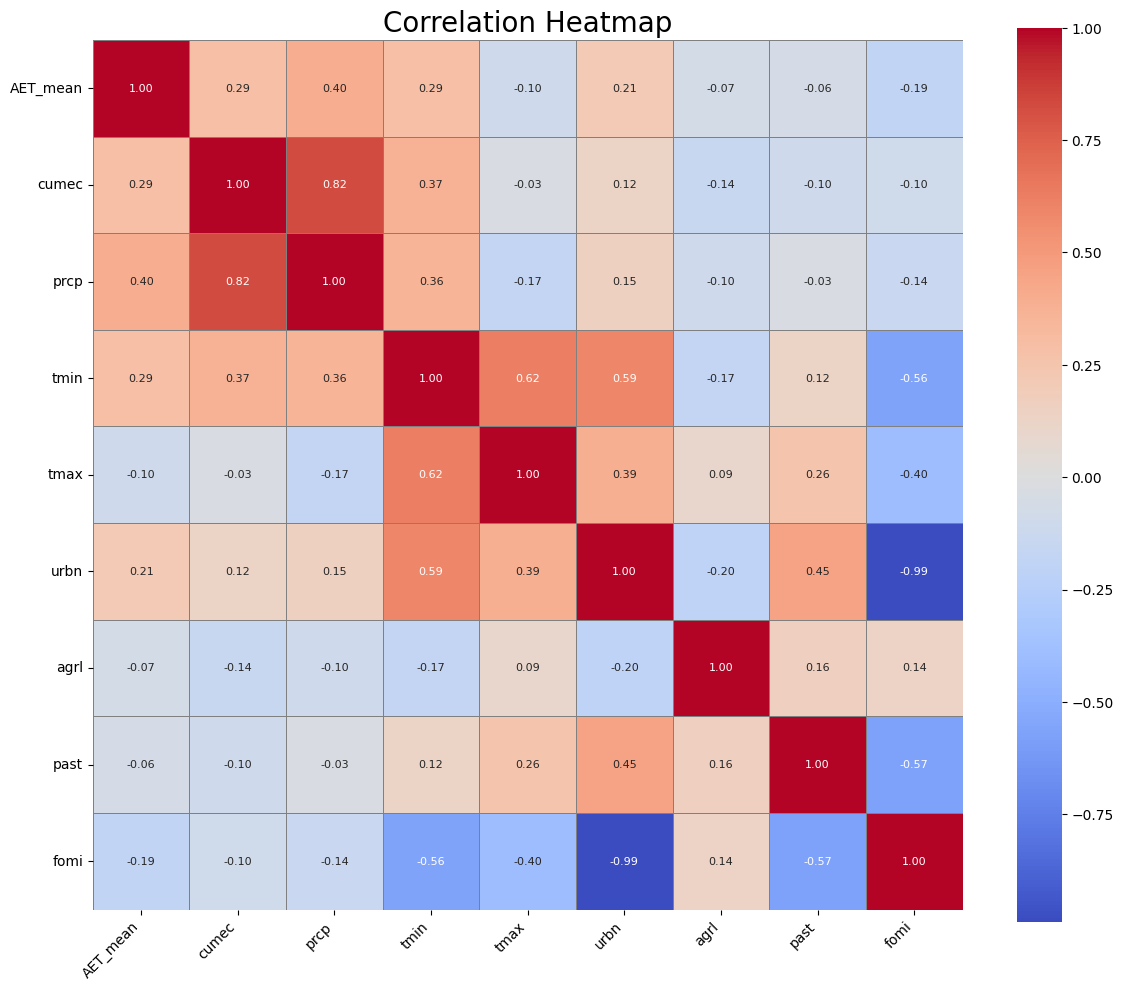

In [22]:
df_corr = df.dropna(axis=1, how='all')
df_corr = df_corr.loc[:, df_corr.nunique() > 1]
df_corr = df.drop(columns=['year','rnge','Base flow (cumec)'])
numerical_feats = df_corr.select_dtypes(include=['int64', 'float64'])
#numerical_feats = drop(columns=['year'])
correlation_matrix = numerical_feats.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            square=True, cbar=True, linewidths=0.5, linecolor='gray',
            annot_kws={"size": 8}, mask=correlation_matrix.isnull())

plt.title("Correlation Heatmap", fontsize=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

- **Streamflow**, **Baseflow(cumec)**, and **prcp** show strong positive correlations (ρ ≈ 0.88–1.00), indicating that precipitation and baseflow are key contributors to streamflow.

- **soil_moisture_avg** is moderately correlated with **streamflow **(ρ ≈ 0.64), suggesting that wetter soils enhance runoff and flow.

- **tmin** and **tmax** have a strong positive correlation (ρ ≈ 0.84), reflecting consistent temperature trends.

- **agrl (agricultural land)** shows weak to moderate negative correlations with streamflow (ρ ≈ -0.26) and very strong inverse relation with** mge (ρ ≈ -0.96)**, indicating possible land cover trade-offs.

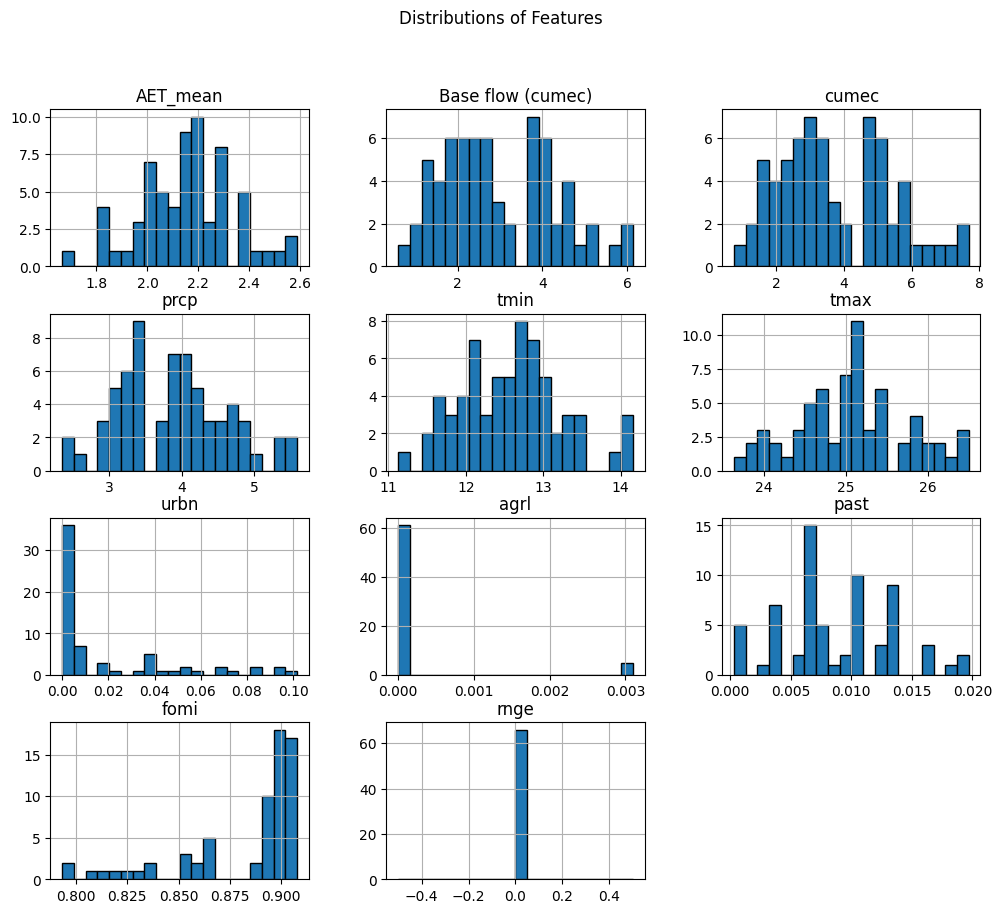

In [23]:
# Histogram of each feature
df.drop(columns='year').hist(bins=20, figsize=(12, 10), edgecolor='black')
plt.suptitle("Distributions of Features")
plt.show()

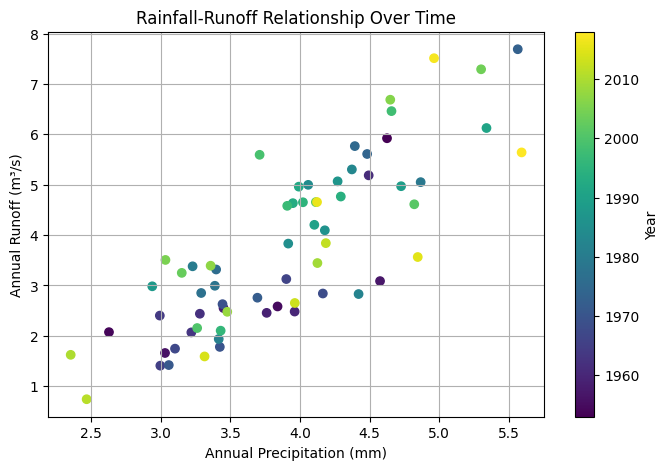

In [24]:
#Plot rainfall-runoff relationship over time
plt.figure(figsize=(8, 5))
plt.scatter(df['prcp'], df['cumec'], c=df['year'], cmap='viridis')
plt.xlabel("Annual Precipitation (mm)")
plt.ylabel("Annual Runoff (m³/s)")
plt.title("Rainfall-Runoff Relationship Over Time")
plt.colorbar(label='Year')
plt.grid(True)
plt.show()

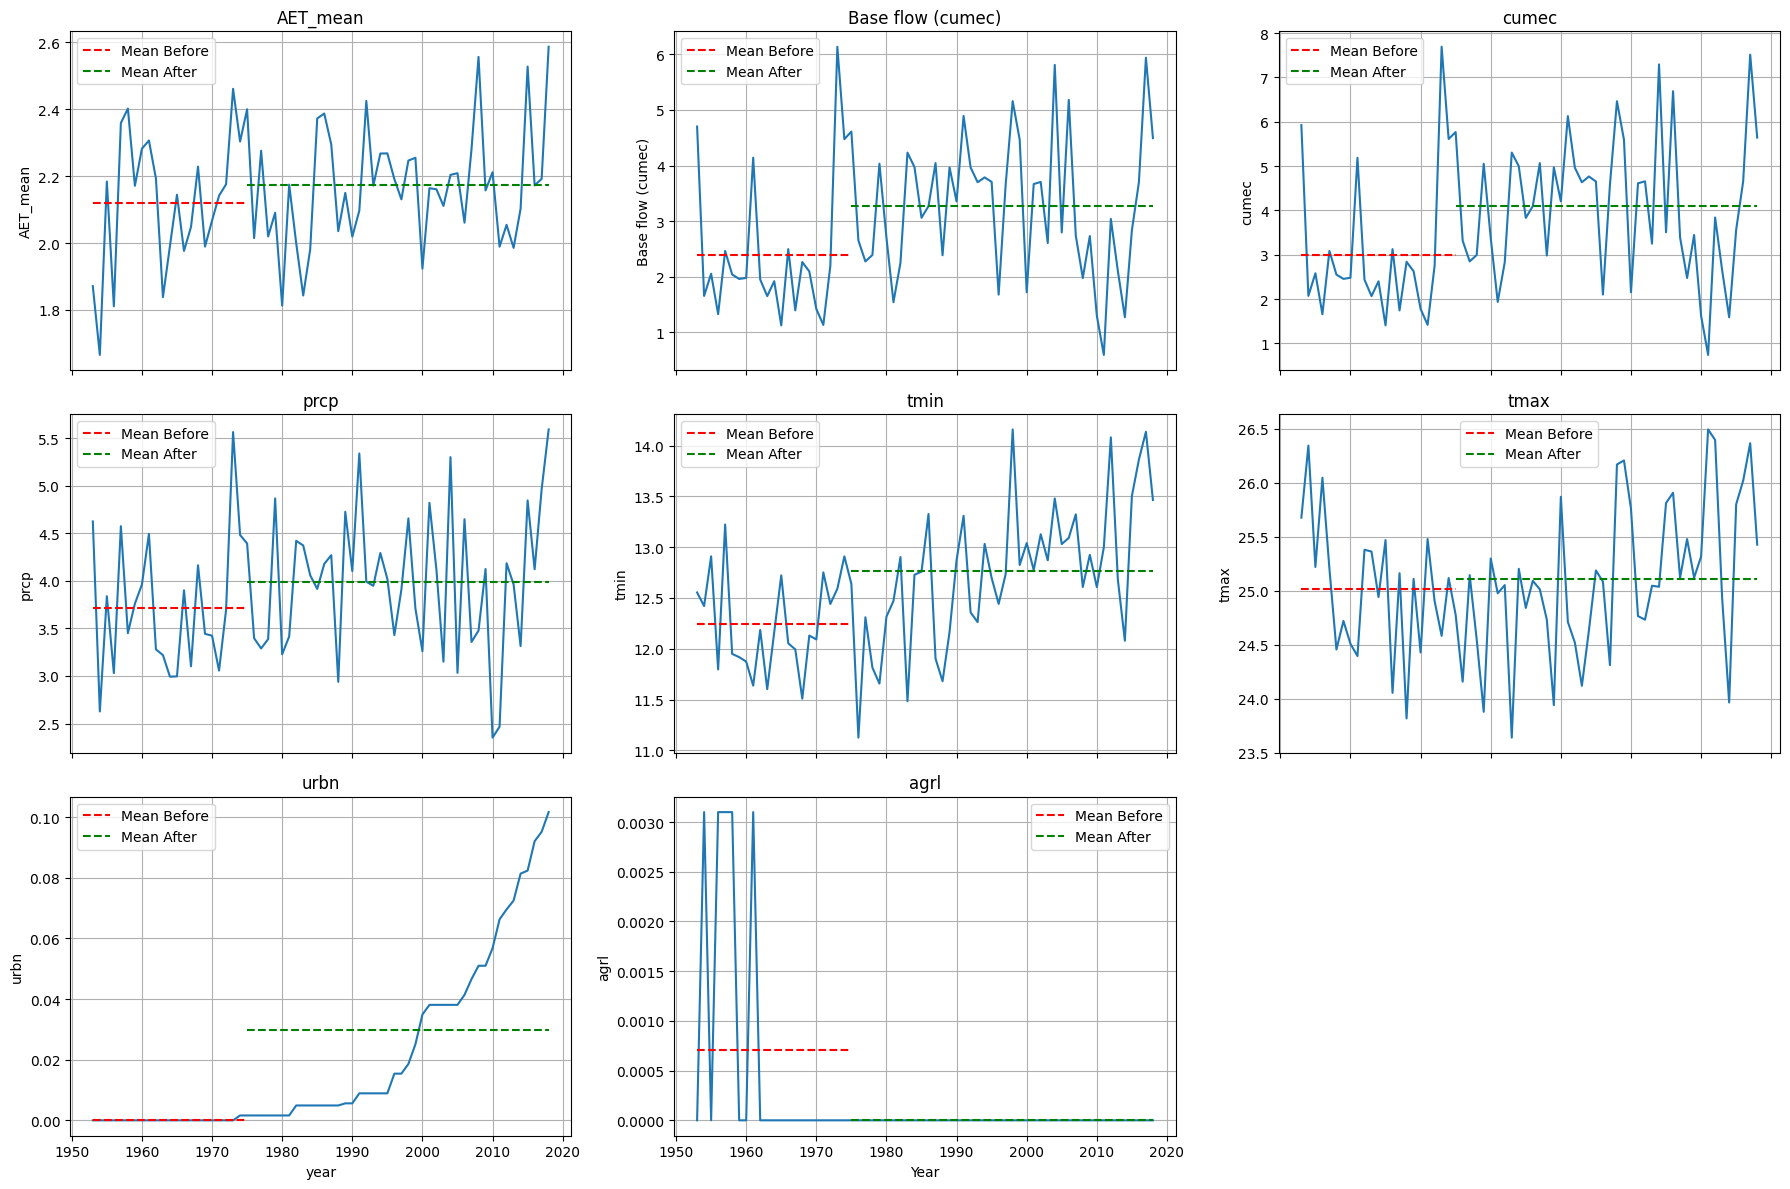

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

features = ['AET_mean','Base flow (cumec)','cumec','prcp','tmin','tmax',
            'urbn','agrl']
change_point = 1975

n_features = len(features)
n_cols = 3
n_rows = math.ceil(n_features / n_cols)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows), sharex=True)
axes = axes.flatten()

for i, feature in enumerate(features):
    ax = axes[i]

    # Plot line
    sns.lineplot(x=df['year'], y=df[feature], ax=ax)

    # Mean before/after change point
    mean_before = df[df['year'] < change_point][feature].mean()
    mean_after = df[df['year'] >= change_point][feature].mean()

    # Horizontal mean lines
    ax.hlines(mean_before, xmin=df['year'].min(), xmax=change_point, colors='red', linestyles='dashed', label='Mean Before')
    ax.hlines(mean_after, xmin=change_point, xmax=df['year'].max(), colors='green', linestyles='dashed', label='Mean After')

    ax.set_title(f"{feature}")
    ax.set_ylabel(feature)
    ax.grid(True)
    ax.legend()

# Remove unused subplots if features < total grid size
for j in range(i + 1, len(axes)):
     fig.delaxes(axes[j])
plt.xlabel("Year")
plt.tight_layout()
plt.show()


In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def seq_mk(data):
    """
    Sequential Mann-Kendall test.
    Input: 2-column NumPy array or DataFrame with [year, values]
    Output: DataFrame with columns [u_prog, u_retr, turning_point]
    """
    year = data[:, 0]
    values = data[:, 1]
    m = len(values)

    # Progressive series
    n = np.zeros((m, m))
    for j in range(m):
        for i in range(j):
            n[j, i] = 1 if values[j] > values[i] else 0
    num = np.sum(n, axis=1)
    t = np.cumsum(num)
    var = np.array([i * (i - 1) * (2 * i + 5) / 72 for i in range(1, m + 1)])
    mean = np.array([i * (i - 1) / 4 for i in range(1, m + 1)])
    u_prog = (t - mean) / np.sqrt(var)

    # Retrograde series
    values_rev = values[::-1]
    n1 = np.zeros((m, m))
    for j in range(m):
        for i in range(j):
            n1[j, i] = 1 if values_rev[j] > values_rev[i] else 0
    num1 = np.sum(n1, axis=1)
    t1 = np.cumsum(num1)
    var1 = var
    mean1 = mean
    u_retr = (t1 - mean1) / np.sqrt(var1)
    u_retr = u_retr[::-1]

    # Turning points
    diff = u_prog - u_retr
    turning_point = np.zeros(m)
    for i in range(1, m - 2):
        if np.sign(diff[i]) != np.sign(diff[i + 1]):
            turning_point[i + 1] = 1

    # Plot
    # plt.figure(figsize=(10, 5))
    # plt.plot(year, u_prog, 'r', label='Progressive Series')
    # plt.plot(year, u_retr, 'b', label='Retrograde Series')
    # plt.grid(True)
    # plt.title('Sequential Mann-Kendall Test')
    # plt.xlabel('Year')
    # plt.legend()
    # plt.show()

    return pd.DataFrame({
        'year': year,
        'u_prog': u_prog,
        'u_retr': u_retr,
        'turning_point': turning_point.astype(int)
    })


In [27]:
#Applying S M Test to streamflow
df = pd.read_csv('df.csv')
data_array = df[['year', 'cumec']].to_numpy()
result = seq_mk(data_array)

# View detected change years
change_years = result[result['turning_point'] == 1]['year'].drop_duplicates().sort_values().astype(int).tolist()
print("Non-stationary turning point years:", change_years)

Non-stationary turning point years: [1965, 1975]


In [28]:
features = ['AET_mean','Base flow (cumec)','cumec','prcp','tmin','tmax',
            'urbn','agrl']

for feat in features:
    print(f"Testing variable: {feat}")
    data_array = df[['year', feat]].to_numpy()
    result = seq_mk(data_array)
    turning_years = result[result['turning_point'] == 1]['year'].values
    if len(turning_years) > 0:
        print("Turning points found in year(s):", turning_years)
    else:
        print("No turning point found.")
    print('\n')

Testing variable: AET_mean
Turning points found in year(s): [1984. 1986. 1991. 1992.]


Testing variable: Base flow (cumec)
Turning points found in year(s): [1965. 1975. 1982. 1984.]


Testing variable: cumec
Turning points found in year(s): [1965. 1975.]


Testing variable: prcp
Turning points found in year(s): [1965. 1974. 1981. 1983.]


Testing variable: tmin
No turning point found.


Testing variable: tmax
Turning points found in year(s): [1993. 2000. 2004. 2006.]


Testing variable: urbn
No turning point found.


Testing variable: agrl
Turning points found in year(s): [1987.]




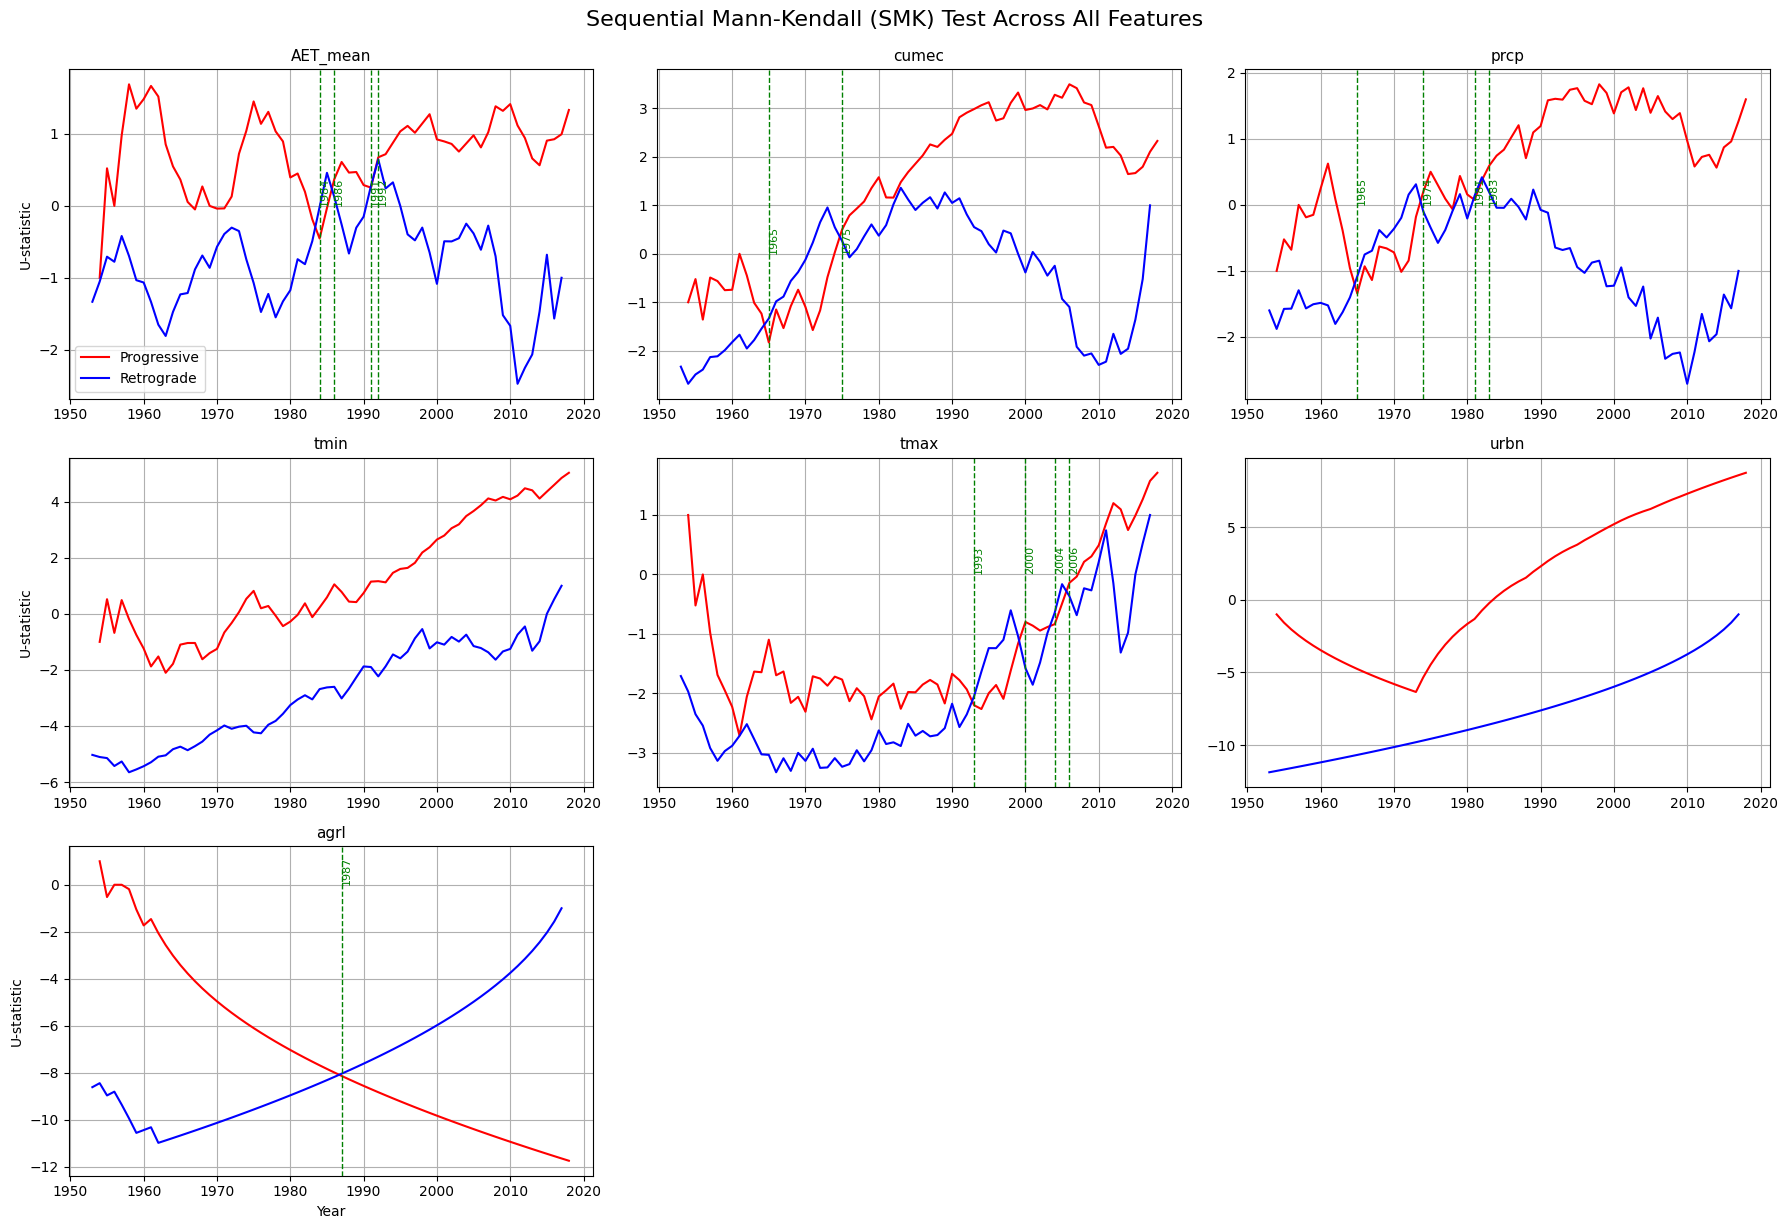

In [29]:
df = pd.read_csv("df.csv")

# List of features to analyze
features = ['AET_mean', 'cumec', 'prcp', 'tmin', 'tmax',
            'urbn', 'agrl']

# Plot configuration
cols = 3
rows = math.ceil(len(features) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4))
axes = axes.flatten()

# Sequential MK for each feature
for idx, feature in enumerate(features):
    ax = axes[idx]
    data_array = df[['year', feature]].to_numpy()
    result = seq_mk(data_array)

    year = result['year']
    u_prog = result['u_prog']
    u_retr = result['u_retr']
    turning_years = result[result['turning_point'] == 1]['year'].values

    ax.plot(year, u_prog, 'r', label='Progressive')
    ax.plot(year, u_retr, 'b', label='Retrograde')

    for ty in turning_years:
        ax.axvline(ty, color='green', linestyle='--', linewidth=1)
        ax.text(ty, 0, f'{int(ty)}', color='green', fontsize=8, rotation=90, va='bottom')

    ax.set_title(f"{feature}", fontsize=11)
    ax.grid(True)

    if idx % cols == 0:
        ax.set_ylabel("U-statistic")
    if idx >= (rows - 1) * cols:
        ax.set_xlabel("Year")

# Remove empty subplots if any
for j in range(len(features), len(axes)):
    fig.delaxes(axes[j])

# Final touches
fig.tight_layout()
fig.suptitle("Sequential Mann-Kendall (SMK) Test Across All Features", fontsize=16, y=1.02)
axes[0].legend()
plt.show()

In [30]:
df['urban_precip'] = df['urbn'] * df['prcp']
df['urban_tmin'] = df['urbn'] * df['tmin']

In [31]:
# Dataset bounds
turning_points = change_years.copy()
start_year = 1953
end_year = 2018
min_interval_gap = 10  # minimum gap in years

# Step 1: Filter turning points with ~10-year separation
filtered_tp = []
last_added = 1953
for year in turning_points:
    if last_added is None or (year - last_added >= min_interval_gap):
        filtered_tp.append(year)
        last_added = year

# Step 2: Add start_year if far enough from first filtered_tp
if filtered_tp and (filtered_tp[0] - start_year >= min_interval_gap):
    filtered_tp = [start_year] + filtered_tp

# Step 3: Add end_year if needed
if filtered_tp[-1] < end_year:
    filtered_tp.append(end_year)

# Step 4: Form intervals
intervals = [(filtered_tp[i], filtered_tp[i + 1]) for i in range(len(filtered_tp) - 1)]
filtered_tp = [(1953,1975),(1976,2018)]

# Output
print("Filtered Turning Points:", filtered_tp)
print("Intervals:", intervals)

Filtered Turning Points: [(1953, 1975), (1976, 2018)]
Intervals: [(1953, 1965), (1965, 1975), (1975, 2018)]


In [32]:
change_points = [1975]

[1975]
[1953, 1975, 2018]


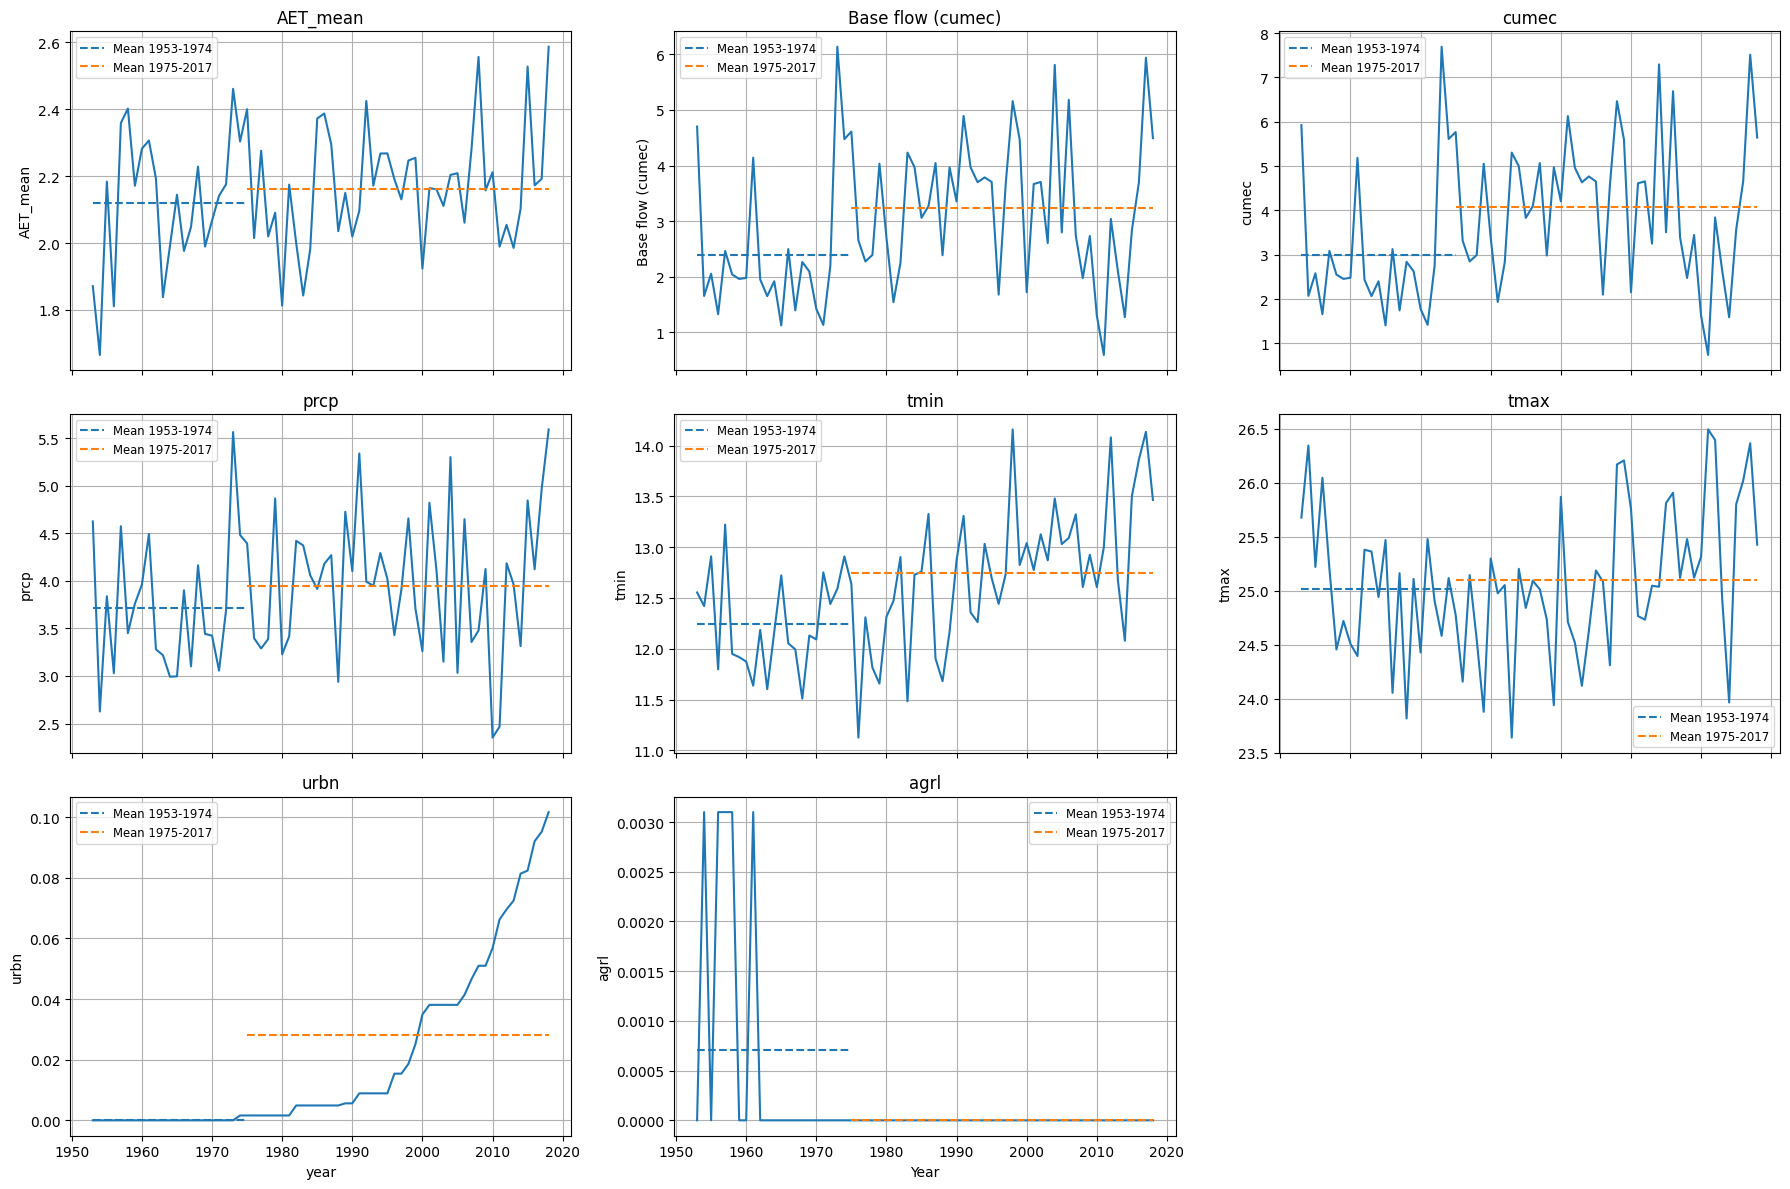

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

features = ['AET_mean', 'Base flow (cumec)', 'cumec', 'prcp', 'tmin', 'tmax', 'urbn', 'agrl']
change_points = [1975]
print(change_points)
all_years = [df['year'].min()] + change_points + [df['year'].max()]
print(all_years)
n_features = len(features)
n_cols = 3
n_rows = math.ceil(n_features / n_cols)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows), sharex=True)
axes = axes.flatten()

for i, feature in enumerate(features):
    ax = axes[i]

    # Plot time series
    sns.lineplot(x=df['year'], y=df[feature], ax=ax)

    # Plot means between change points
    for j in range(len(all_years) - 1):
        start_year = all_years[j]
        end_year = all_years[j + 1]

        mask = (df['year'] >= start_year) & (df['year'] < end_year)
        mean_val = df.loc[mask, feature].mean()

        ax.hlines(mean_val, xmin=start_year, xmax=end_year,
                  colors='C'+str(j), linestyles='dashed',
                  label=f'Mean {start_year}-{end_year-1}')

    ax.set_title(f"{feature}")
    ax.set_ylabel(feature)
    ax.grid(True)
    ax.legend(fontsize='small')

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.xlabel("Year")
plt.tight_layout()
plt.show()


# Model training

[1965, 1975]
 Processing interval: 1953 to 1975
 Processing interval: 1976 to 2018


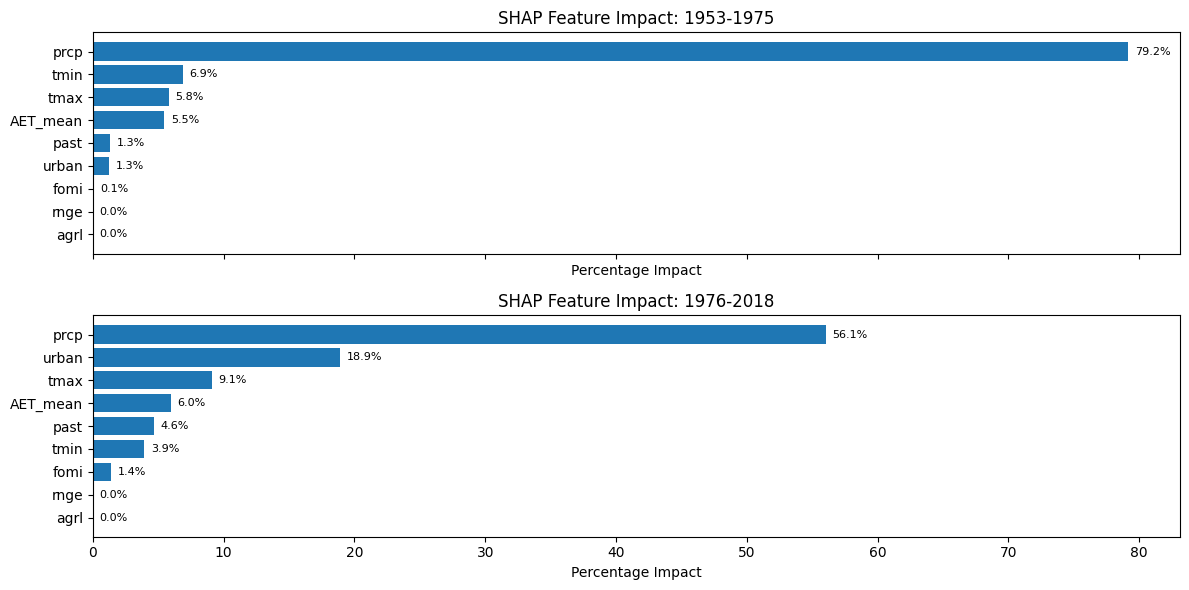

In [34]:
df = df.copy()
print(turning_points)
target = 'cumec'
features = [col for col in df.columns if col not in ['year', target, 'Base flow (cumec)']]
group_map = {
    "urban": ["urban_precip", "urbn", "urban_tmin"]
}

# Best model params
best_params = {
    'colsample_bytree': 1,
    'learning_rate': 0.01,
    'max_depth': 3,
    'n_estimators': 300,
    'subsample': 0.8
}

intervals = [(1953,1975),(1976,2018)]

# Function to compute percentage impact
def get_percentage_impact(shap_vals, columns, group_map):
    df_shap = pd.DataFrame(shap_vals, columns=columns)
    grouped_shap = {}

    for group_name, feature_list in group_map.items():
        grouped_shap[group_name] = df_shap[feature_list].abs().sum(axis=1)

    for col in columns:
        if not any(col in v for v in group_map.values()):
            grouped_shap[col] = df_shap[col].abs()

    grouped_df = pd.DataFrame(grouped_shap)
    mean_abs = grouped_df.mean()
    pct = 100 * mean_abs / mean_abs.sum()
    return pct.sort_values()

# Store all results
interval_importances = {}

for start, end in intervals:
    print(f" Processing interval: {start} to {end}")

    df_interval = df[(df['year'] >= start) & (df['year'] < end)]
    X = df_interval[features].copy()
    y = df_interval[target]
    bool_cols = X.select_dtypes(include='bool').columns
    X[bool_cols] = X[bool_cols].astype(int)

    model = xgb.XGBRegressor(**best_params, random_state=42)
    model.fit(X, y)

    explainer = shap.Explainer(model, X)
    shap_values = explainer(X)

    # SHAP values array
    shap_vals = shap_values.values if hasattr(shap_values, 'values') else shap_values

    impact = get_percentage_impact(shap_vals, features, group_map)
    interval_importances[f"{start}-{end}"] = impact

# =======================
# Plot All Intervals
# =======================
fig, axes = plt.subplots(nrows=len(interval_importances), figsize=(12, len(interval_importances)*3), sharex=True)

for ax, (interval, imp) in zip(axes, interval_importances.items()):
    ax.barh(imp.index, imp.values)
    ax.set_title(f"SHAP Feature Impact: {interval}")
    ax.set_xlabel("Percentage Impact")
    for i, v in enumerate(imp.values):
        ax.text(v + 0.5, i, f"{v:.1f}%", va='center', fontsize=8)

plt.tight_layout()
plt.show();


## Monthly analysis

In [35]:
# ======Data Cleaning ======
aet_df['date'] = pd.to_datetime(aet_df['date'])
streamflow_df['date'] = pd.to_datetime(streamflow_df['date'], format='%m/%d/%Y')
baseflow_df['date'] = pd.to_datetime(baseflow_df['date'], format='%m/%d/%Y')
climate_df['date'] = pd.to_datetime(climate_df['date'])

#  Extract year and month for monthly grouping
for df in [aet_df, streamflow_df, baseflow_df, climate_df]:
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month

# Group by year and month
aet_monthly = aet_df.groupby(['year', 'month'])['AET_mean'].mean().reset_index()
streamflow_monthly = streamflow_df.groupby(['year', 'month'])['cumec'].mean().reset_index()
baseflow_monthly = baseflow_df.groupby(['year', 'month'])['Base flow (cumec)'].mean().reset_index()
climate_monthly = climate_df.groupby(['year', 'month']).agg({
    'prcp': 'mean',
    'tmin': 'mean',
    'tmax': 'mean'
}).reset_index()


In [36]:
# # Find soil moisture CSVs
# soil_files = [os.path.join(base_path, f) for f in os.listdir(base_path)
#               if f.startswith("SW_ID_") and f.endswith(".csv")]

# # Process each file
# soil_dfs = []
# for i, path in enumerate(soil_files):
#     df = pd.read_csv(path)
#     df['date'] = pd.to_datetime(df['date'])
#     df['year'] = df['date'].dt.year
#     df['month'] = df['date'].dt.month
#     df_monthly = df.groupby(['year', 'month'])['soil_moisture'].mean().reset_index()
#     df_monthly.columns = ['year', 'month', f'soil_{8795+i}']
#     soil_dfs.append(df_monthly)

# # Merge and average
# soil_combined = soil_dfs[0]
# for df in soil_dfs[1:]:
#     soil_combined = soil_combined.merge(df, on=['year', 'month'], how='outer')
# soil_combined['soil_moisture_avg'] = soil_combined.iloc[:, 2:5].mean(axis=1)
# soil_monthly = soil_combined[['year', 'month', 'soil_moisture_avg']]


In [37]:
# ===== LULC =====
lulc_monthly = lulc_df.loc[lulc_df.index.repeat(12)].copy()
lulc_monthly['month'] = list(range(1, 13)) * lulc_df.shape[0]
lulc_monthly = lulc_monthly.sort_values(['year', 'month']).reset_index(drop=True)


In [38]:
df_monthly = aet_monthly \
    .merge(baseflow_monthly, on=['year', 'month']) \
    .merge(streamflow_monthly, on=['year', 'month']) \
    .merge(climate_monthly, on=['year', 'month']) \
    .merge(lulc_monthly, on=['year', 'month'])

df_monthly = df_monthly.dropna()

df_monthly = aet_monthly \
    .merge(baseflow_monthly, on=['year', 'month']) \
    .merge(streamflow_monthly, on=['year', 'month']) \
    .merge(climate_monthly, on=['year', 'month']) \
    .merge(lulc_monthly, on=['year', 'month'])

df_monthly = df_monthly.dropna()

print(f"Shape: {df_monthly.shape}")
print('\n')
print(df_monthly.head())

Shape: (789, 17)


   year  month  AET_mean  Base flow (cumec)      cumec       prcp       tmin  \
0  1953      1  0.583884           1.910381   2.477263   2.451741   4.776238   
1  1953      2  0.816403           6.706953   8.405033   6.489219   5.023421   
2  1953      3  0.946147           3.309123   4.121465   3.062908  12.463922   
3  1953      4  1.284196          11.491697  15.090967   9.570047  11.506437   
4  1953      5  2.992212          18.721938  23.146700  11.184686  17.678627   

        tmax  urbn  agrl    past    fomi  rngb  rnge    wehb  wetn  bsvg  
0  18.717121   0.0   0.0  0.0197  0.8917   0.0   0.0  0.0886   0.0   0.0  
1  16.718589   0.0   0.0  0.0197  0.8917   0.0   0.0  0.0886   0.0   0.0  
2  23.972142   0.0   0.0  0.0197  0.8917   0.0   0.0  0.0886   0.0   0.0  
3  25.207965   0.0   0.0  0.0197  0.8917   0.0   0.0  0.0886   0.0   0.0  
4  29.080061   0.0   0.0  0.0197  0.8917   0.0   0.0  0.0886   0.0   0.0  


In [39]:
print(df_monthly.isnull().sum())
print('\n')
print(df_monthly.info())

year                 0
month                0
AET_mean             0
Base flow (cumec)    0
cumec                0
prcp                 0
tmin                 0
tmax                 0
urbn                 0
agrl                 0
past                 0
fomi                 0
rngb                 0
rnge                 0
wehb                 0
wetn                 0
bsvg                 0
dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 789 entries, 0 to 788
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   year               789 non-null    int32  
 1   month              789 non-null    int32  
 2   AET_mean           789 non-null    float64
 3   Base flow (cumec)  789 non-null    float64
 4   cumec              789 non-null    float64
 5   prcp               789 non-null    float64
 6   tmin               789 non-null    float64
 7   tmax               789 non-null    float64
 8   urbn

In [40]:
print(df_monthly.describe())

              year       month    AET_mean  Base flow (cumec)       cumec  \
count   789.000000  789.000000  789.000000         789.000000  789.000000   
mean   1985.376426    6.482890    2.152861           2.981444    3.741362   
std      18.992692    3.449236    1.540187           3.069376    3.898869   
min    1953.000000    1.000000    0.000000           0.095346    0.118492   
25%    1969.000000    3.000000    0.701424           1.091595    1.362982   
50%    1985.000000    6.000000    1.710882           1.910381    2.384092   
75%    2002.000000    9.000000    3.417036           3.946252    4.925896   
max    2018.000000   12.000000    6.268131          33.044755   42.859030   

             prcp        tmin        tmax        urbn        agrl        past  \
count  789.000000  789.000000  789.000000  789.000000  789.000000  789.000000   
mean     3.889743   12.571176   25.057880    0.019548    0.000236    0.008661   
std      2.403146    6.829530    6.807925    0.027862    0.0008

In [41]:
df_monthly.drop(columns=['rngb', 'wehb', 'bsvg','wetn'], axis=1, inplace=True)

In [42]:
df_monthly.head()

year  month  AET_mean  Base flow (cumec)      cumec       prcp       tmin  \
0  1953      1  0.583884           1.910381   2.477263   2.451741   4.776238   
1  1953      2  0.816403           6.706953   8.405033   6.489219   5.023421   
2  1953      3  0.946147           3.309123   4.121465   3.062908  12.463922   
3  1953      4  1.284196          11.491697  15.090967   9.570047  11.506437   
4  1953      5  2.992212          18.721938  23.146700  11.184686  17.678627   

        tmax  urbn  agrl    past    fomi  rnge  
0  18.717121   0.0   0.0  0.0197  0.8917   0.0  
1  16.718589   0.0   0.0  0.0197  0.8917   0.0  
2  23.972142   0.0   0.0  0.0197  0.8917   0.0  
3  25.207965   0.0   0.0  0.0197  0.8917   0.0  
4  29.080061   0.0   0.0  0.0197  0.8917   0.0

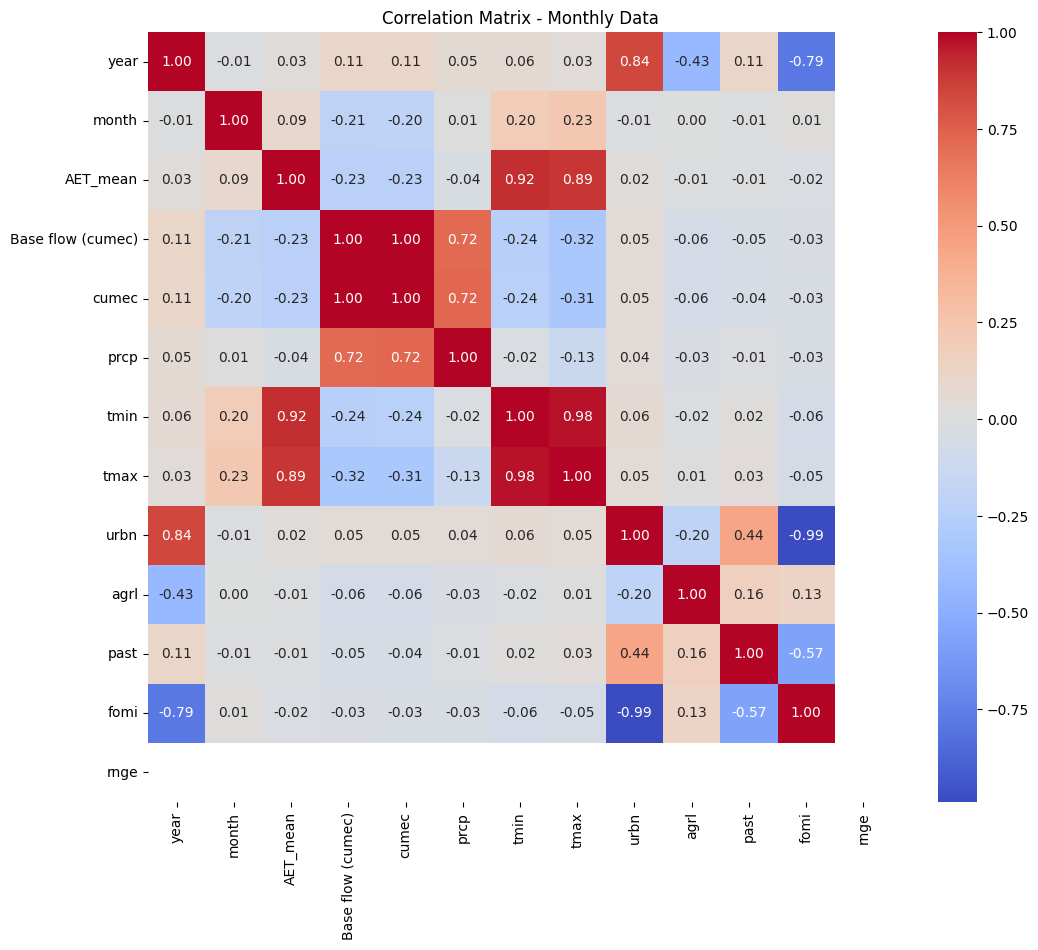

In [43]:
# Correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(df_monthly.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix - Monthly Data")
plt.show()

In [44]:
11%12

11

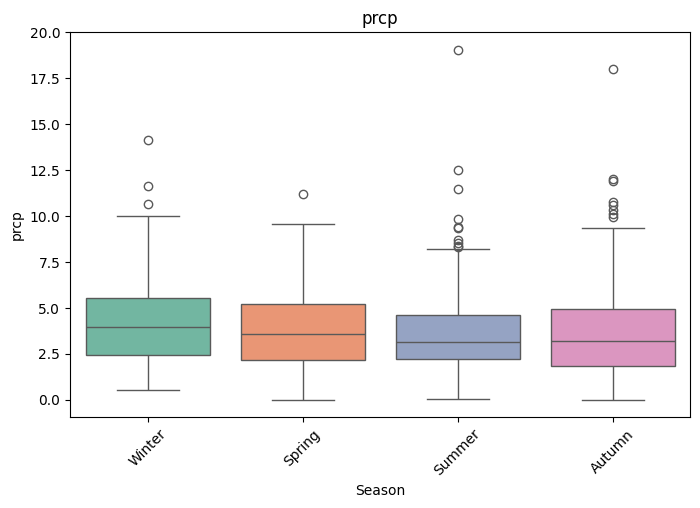

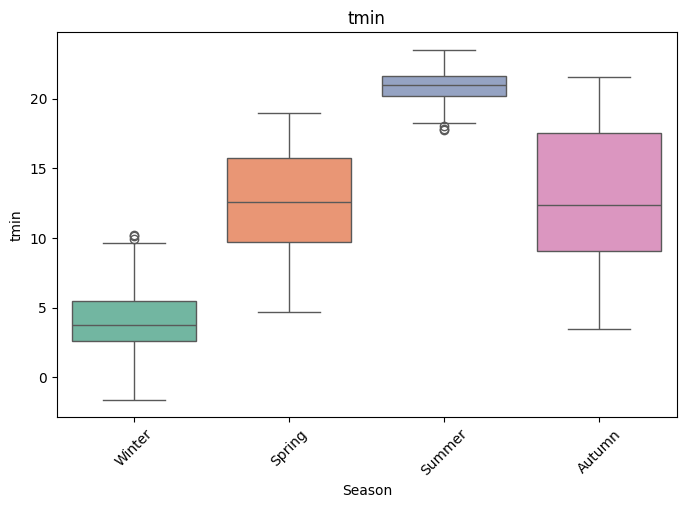

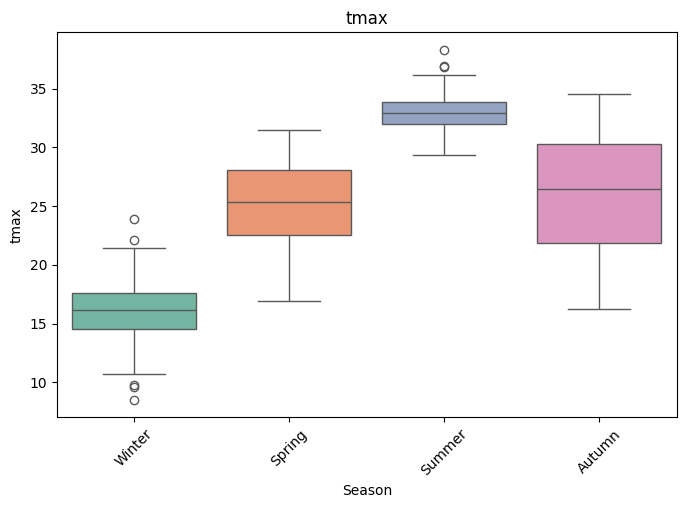

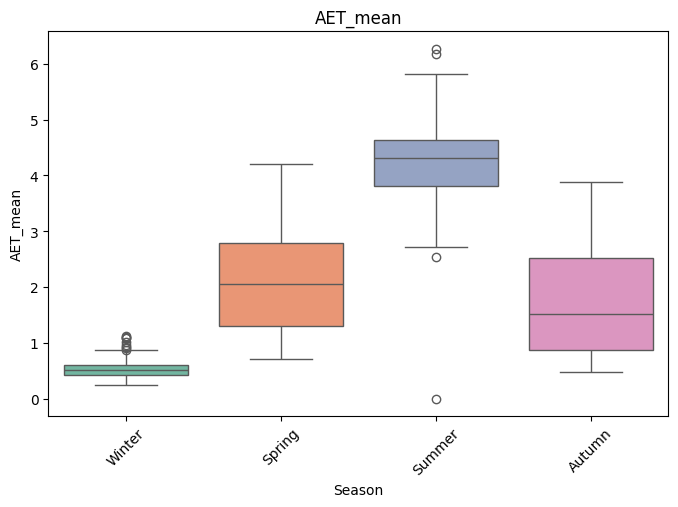

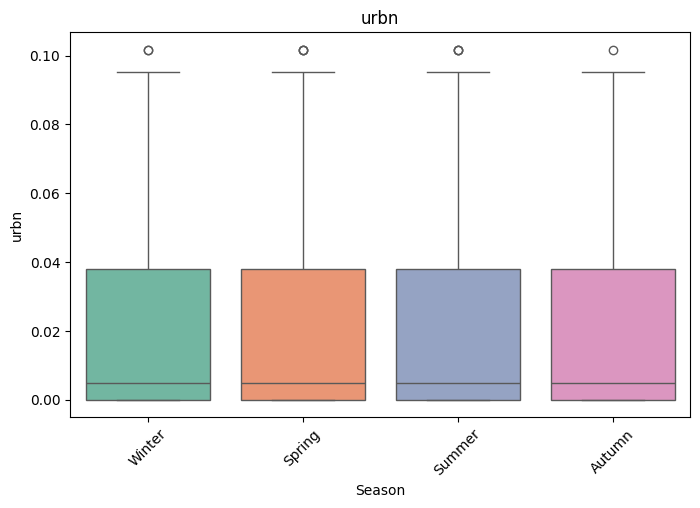

In [45]:
# Seasonal trend analysis
season_labels = ['Winter', 'Spring', 'Summer', 'Autumn']
df_monthly['season'] = df_monthly['month'] % 12 // 3 + 1
df_monthly['season'] = df_monthly['season'].map({1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Autumn'})

variables = ['prcp', 'tmin', 'tmax', 'AET_mean','urbn']

for var in variables:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='season', y=var, data=df_monthly, palette='Set2')
    plt.xticks(rotation=45)
    plt.title(f'{var}')
    plt.xlabel('Season')
    plt.ylabel(var)
    plt.show();

In [46]:
print(df_monthly['season'].value_counts())

season
Spring    198
Summer    198
Winter    197
Autumn    196
Name: count, dtype: int64


- Precipitation:
  - Winter has lowest Precipitation
  - Summer and Autumn have high values
  - Interpretation - Most rainfall occurs in Summer

- TMin:
  - Winter has the lowest Tmin, Summer has the highest Tmax
- TMax:
   - Summer shows the highest tmax (tight spread, consistent heat).
   - Winter has the lowest.

- AET:
   - Summer leads with the highest evapotranspiration due to more heat and possibly moisture.
   - Winter has very low AET, tightly packed (low variability).
- Soil Moisture:
  - Spring has the highest median soil moisture, possibly due to snowmelt or early rains.
  - Summer shows a drop, possibly due to high evapotranspiration.
  - Winter and Autumn have moderate levels.

## One hot encoding

In [47]:
# from sklearn.preprocessing import LabelEncoder

# df_monthly = df_monthly.copy()
# label_encoder = LabelEncoder()

# df_monthly['Season'] = label_encoder.fit_transform(df_monthly['season'])

# Apply One-Hot Encoding
df_monthly = pd.get_dummies(df_monthly, columns=['season'])

In [48]:
df_monthly

year  month  AET_mean  Base flow (cumec)      cumec       prcp  \
0    1953      1  0.583884           1.910381   2.477263   2.451741   
1    1953      2  0.816403           6.706953   8.405033   6.489219   
2    1953      3  0.946147           3.309123   4.121465   3.062908   
3    1953      4  1.284196          11.491697  15.090967   9.570047   
4    1953      5  2.992212          18.721938  23.146700  11.184686   
..    ...    ...       ...                ...        ...        ...   
784  2018      5  4.082064           2.081150   2.595006   1.396756   
785  2018      6  3.938463           1.603573   2.002281   3.640083   
786  2018      7  4.525149           1.549826   1.938970   5.714564   
787  2018      8  4.382000           1.262657   1.576241   2.929829   
788  2018      9  2.871606           2.497667   3.129573   8.212088   

          tmin       tmax    urbn  agrl    past    fomi  rnge  season_Autumn  \
0     4.776238  18.717121  0.0000   0.0  0.0197  0.8917   0.0          False   
1     5.023421  16.718589  0.0000   0.0  0.0197  0.8917   0.0          False   
2    12.463922  23.972142  0.0000   0.0  0.0197  0.8917   0.0          False   
3    11.506437  25.207965  0.0000   0.0  0.0197  0.8917   0.0          False   
4    17.678627  29.080061  0.0000   0.0  0.0197  0.8917   0.0          False   
..         ...        ...     ...   ...     ...     ...   ...            ...   
784  17.713550  31.359965  0.1017   0.0  0.0165  0.7932   0.0          False   
785  21.562815  33.228212  0.1017   0.0  0.0165  0.7932   0.0          False   
786  21.892582  34.292010  0.1017   0.0  0.0165  0.7932   0.0          False   
787  21.504291  33.653701  0.1017   0.0  0.0165  0.7932   0.0          False   
788  21.565969  31.017736  0.1017   0.0  0.0165  0.7932   0.0           True   

     season_Spring  season_Summer  season_Winter  
0            False          False           True  
1            False          False           True  
2             True          False          False  
3             True          False          False  
4             True          False          False  
..             ...            ...            ...  
784           True          False          False  
785          False           True          False  
786          False           True          False  
787          False           True          False  
788          False          False          False  

[789 rows x 17 columns]

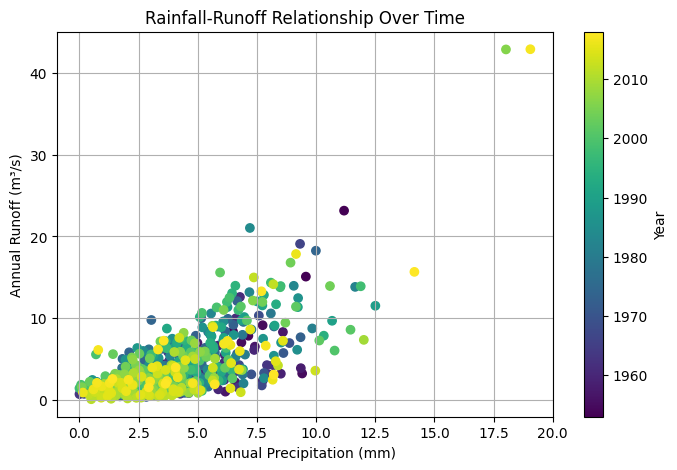

In [49]:
#Plot rainfall-runoff relationship over time
plt.figure(figsize=(8, 5))
plt.scatter(df_monthly['prcp'], df_monthly['cumec'], c=df_monthly['year'], cmap='viridis')
plt.xlabel("Annual Precipitation (mm)")
plt.ylabel("Annual Runoff (m³/s)")
plt.title("Rainfall-Runoff Relationship Over Time")
plt.colorbar(label='Year')
plt.grid(True)
plt.show()

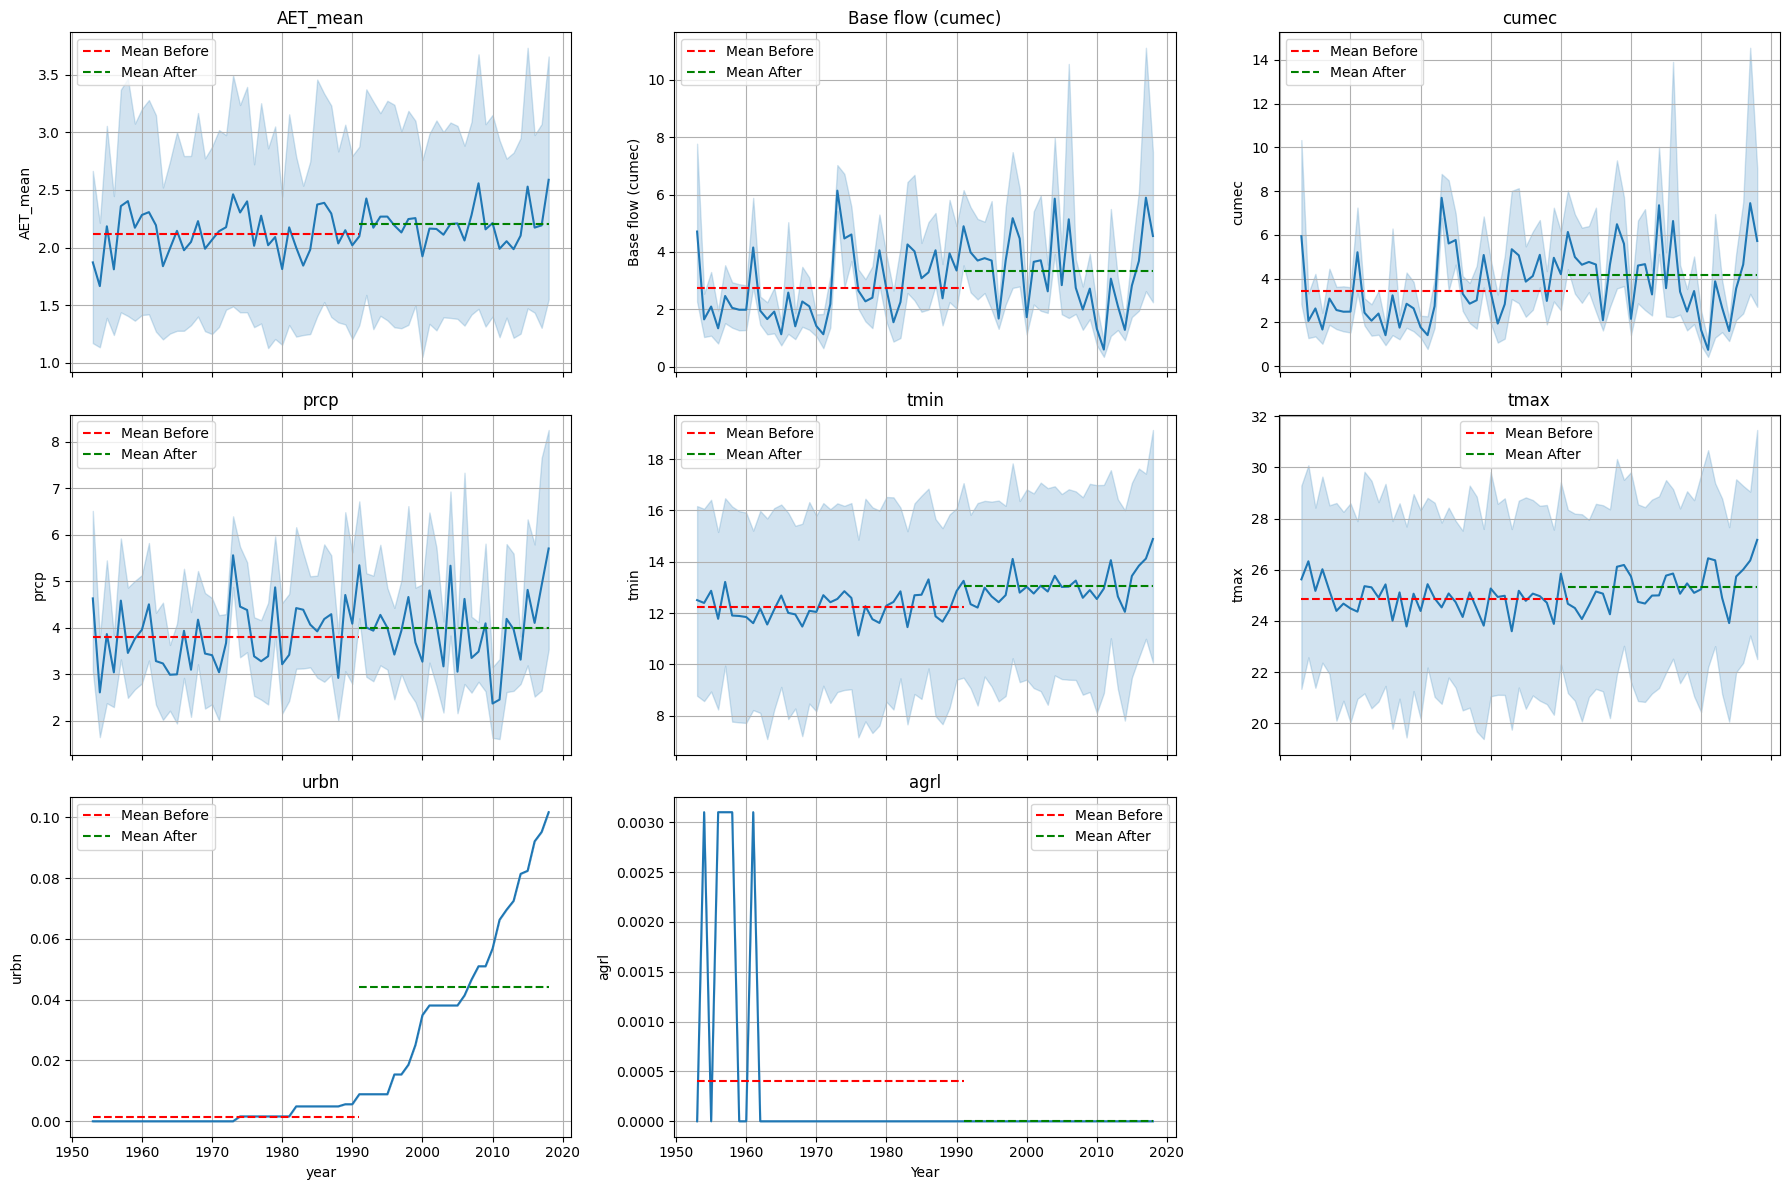

In [50]:
features = ['AET_mean','Base flow (cumec)','cumec','prcp','tmin','tmax',
            'urbn','agrl']
change_point = 1991

n_features = len(features)
n_cols = 3
n_rows = math.ceil(n_features / n_cols)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows), sharex=True)
axes = axes.flatten()

for i, feature in enumerate(features):
    ax = axes[i]

    # Plot line
    sns.lineplot(x=df_monthly['year'], y=df_monthly[feature], ax=ax)

    # Mean before/after change point
    mean_before = df_monthly[df_monthly['year'] < change_point][feature].mean()
    mean_after = df_monthly[df_monthly['year'] >= change_point][feature].mean()

    # Horizontal mean lines
    ax.hlines(mean_before, xmin=df_monthly['year'].min(), xmax=change_point, colors='red', linestyles='dashed', label='Mean Before')
    ax.hlines(mean_after, xmin=change_point, xmax=df_monthly['year'].max(), colors='green', linestyles='dashed', label='Mean After')

    ax.set_title(f"{feature}")
    ax.set_ylabel(feature)
    ax.grid(True)
    ax.legend()

# Remove unused subplots if features < total grid size
for j in range(i + 1, len(axes)):
     fig.delaxes(axes[j])
plt.xlabel("Year")
plt.tight_layout()
plt.show()


In [51]:
df_monthly.head()

year  month  AET_mean  Base flow (cumec)      cumec       prcp       tmin  \
0  1953      1  0.583884           1.910381   2.477263   2.451741   4.776238   
1  1953      2  0.816403           6.706953   8.405033   6.489219   5.023421   
2  1953      3  0.946147           3.309123   4.121465   3.062908  12.463922   
3  1953      4  1.284196          11.491697  15.090967   9.570047  11.506437   
4  1953      5  2.992212          18.721938  23.146700  11.184686  17.678627   

        tmax  urbn  agrl    past    fomi  rnge  season_Autumn  season_Spring  \
0  18.717121   0.0   0.0  0.0197  0.8917   0.0          False          False   
1  16.718589   0.0   0.0  0.0197  0.8917   0.0          False          False   
2  23.972142   0.0   0.0  0.0197  0.8917   0.0          False           True   
3  25.207965   0.0   0.0  0.0197  0.8917   0.0          False           True   
4  29.080061   0.0   0.0  0.0197  0.8917   0.0          False           True   

   season_Summer  season_Winter  
0          False           True  
1          False           True  
2          False          False  
3          False          False  
4          False          False

In [52]:
seasons = ['Winter', 'Spring', 'Summer', 'Autumn']

for season in seasons:
    season_df = df_monthly[df_monthly['season_' + season] == 1]
    if not season_df.empty:
        data_array = season_df[['year', 'cumec']].to_numpy()
        result = seq_mk(data_array)
        change_years = result[result['turning_point'] == 1]['year'].values
        print(f"{season} - Change years:", change_years)


Winter - Change years: [1954. 1955. 1955. 1956. 1956. 1958. 1958. 1960. 1967. 1979. 1981. 1987.
 1989. 1992.]
Spring - Change years: [1956. 1957. 1959. 1959. 1959. 1976. 1978. 1980. 1981. 1985. 1985. 1990.
 2018. 2018.]
Summer - Change years: [1954. 1961. 1964. 1991. 2015.]
Autumn - Change years: [1956. 1957. 1967. 1975. 1982. 1985.]


In [53]:
# SMK TEST
# Exclude first and last 5 years
min_year = df_monthly['year'].min() + 5
max_year = df_monthly['year'].max() - 5
filtered_df = df_monthly[(df_monthly['year'] >= min_year) & (df_monthly['year'] <= max_year)]

# Select year and cumec for SMK
data_array = filtered_df[['year', 'cumec']].to_numpy()

# Run Sequential Mann-Kendall test
result = seq_mk(data_array)

# View detected change years
turning_points = result[result['turning_point'] == 1]['year'].drop_duplicates().sort_values().astype(int).tolist()
print("Non-stationary turning point years:", turning_points)


Non-stationary turning point years: [1958, 1959, 1960, 1961, 1963, 1964, 1976, 1977, 1978, 1979, 1980, 1992, 1993, 1996, 1997, 1998, 2000, 2003, 2004]


In [54]:
print(change_years)

[1956. 1957. 1967. 1975. 1982. 1985.]


In [55]:
df_monthly.to_csv("df_monthly.csv", index=False)

In [56]:
df_monthly.head()

year  month  AET_mean  Base flow (cumec)      cumec       prcp       tmin  \
0  1953      1  0.583884           1.910381   2.477263   2.451741   4.776238   
1  1953      2  0.816403           6.706953   8.405033   6.489219   5.023421   
2  1953      3  0.946147           3.309123   4.121465   3.062908  12.463922   
3  1953      4  1.284196          11.491697  15.090967   9.570047  11.506437   
4  1953      5  2.992212          18.721938  23.146700  11.184686  17.678627   

        tmax  urbn  agrl    past    fomi  rnge  season_Autumn  season_Spring  \
0  18.717121   0.0   0.0  0.0197  0.8917   0.0          False          False   
1  16.718589   0.0   0.0  0.0197  0.8917   0.0          False          False   
2  23.972142   0.0   0.0  0.0197  0.8917   0.0          False           True   
3  25.207965   0.0   0.0  0.0197  0.8917   0.0          False           True   
4  29.080061   0.0   0.0  0.0197  0.8917   0.0          False           True   

   season_Summer  season_Winter  
0          False           True  
1          False           True  
2          False          False  
3          False          False  
4          False          False

In [57]:
# Dataset bounds
start_year = 1953
end_year = 2018
min_interval_gap = 10  # minimum gap in years

# Step 1: Filter turning points with ~10-year separation
filtered_tp = []
last_added = 1953
for year in turning_points:
    if last_added is None or (year - last_added >= min_interval_gap):
        filtered_tp.append(year)
        last_added = year

# Step 2: Add start_year if far enough from first filtered_tp
if filtered_tp and (filtered_tp[0] - start_year >= min_interval_gap):
    filtered_tp = [start_year] + filtered_tp

# Step 3: Add end_year if needed
if filtered_tp[-1] < end_year:
    filtered_tp.append(end_year)

# Step 4: Form intervals
intervals = [(filtered_tp[i], filtered_tp[i + 1]) for i in range(len(filtered_tp) - 1)]

# Output
print("Filtered Turning Points:", filtered_tp)
print("Intervals:", intervals)

Filtered Turning Points: [1953, 1963, 1976, 1992, 2003, 2018]
Intervals: [(1953, 1963), (1963, 1976), (1976, 1992), (1992, 2003), (2003, 2018)]


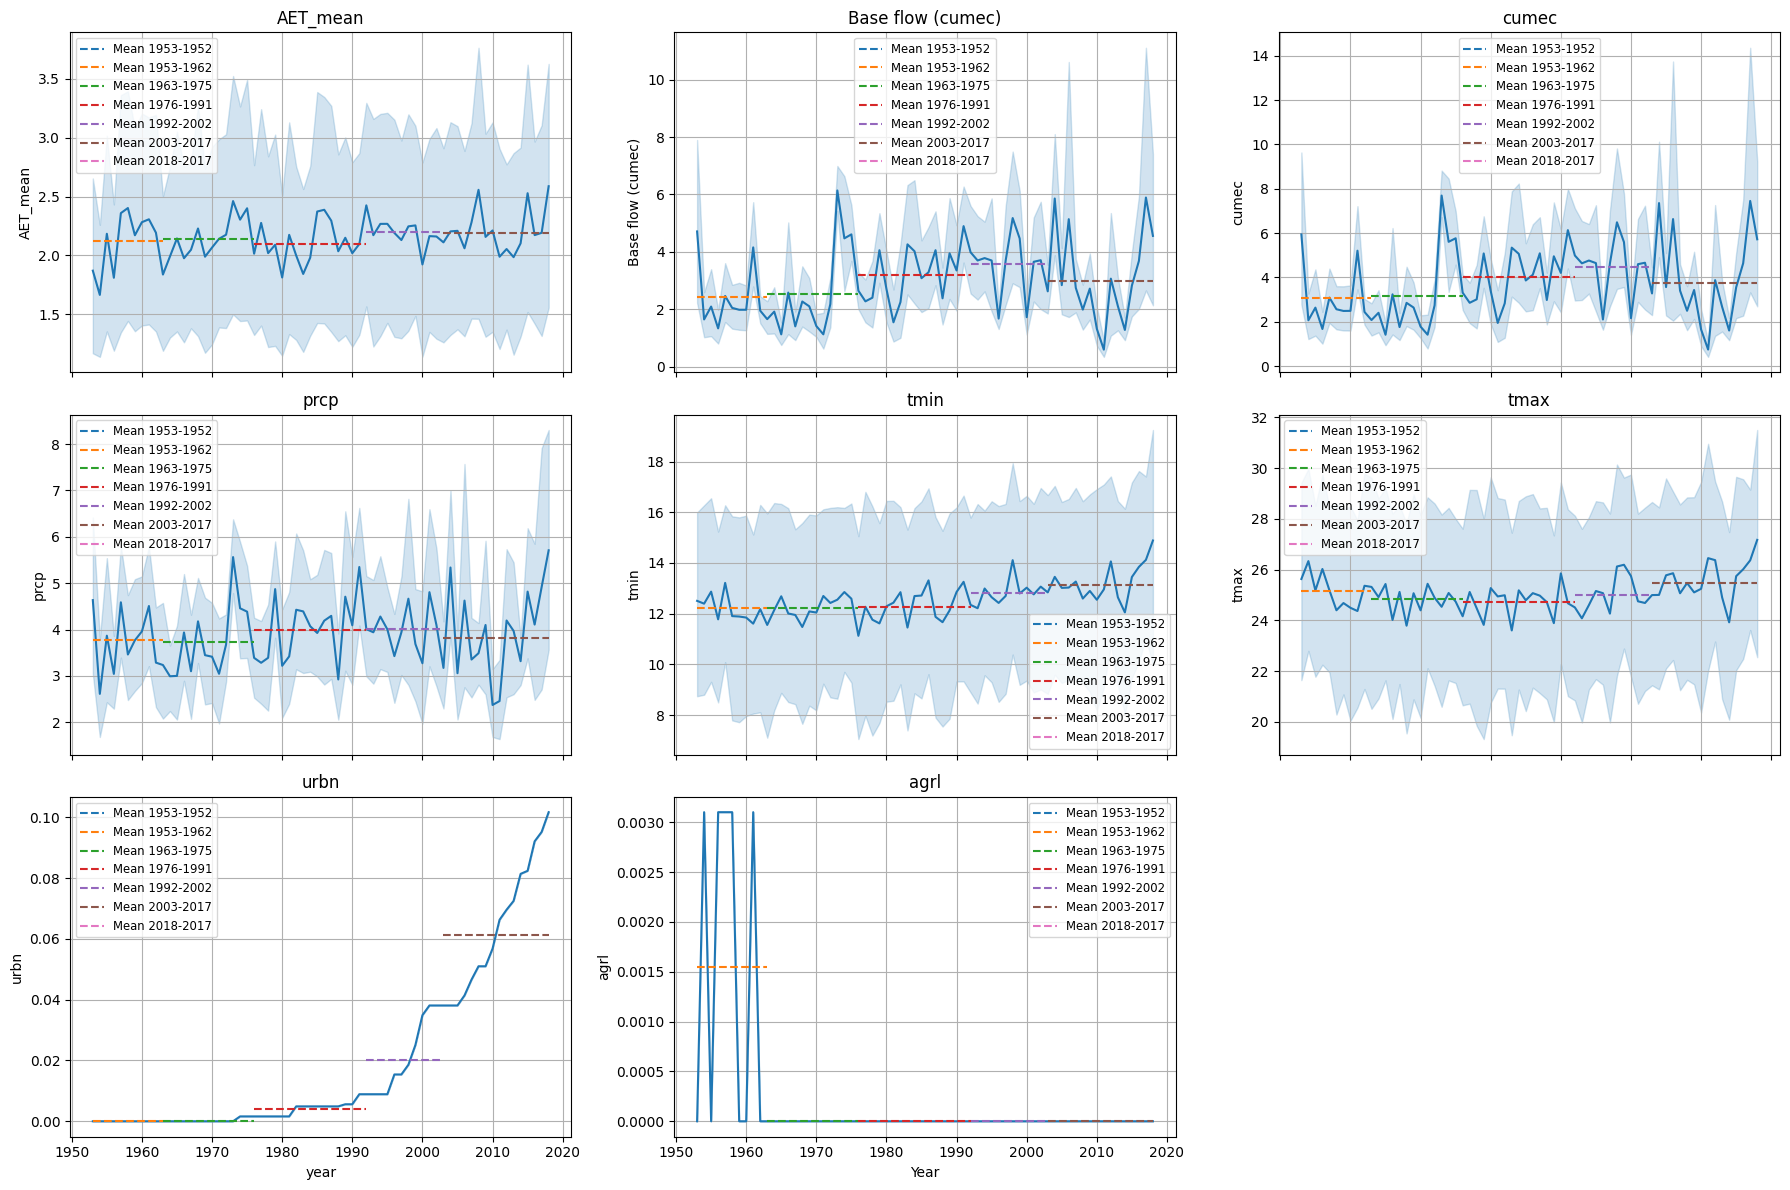

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

features = ['AET_mean', 'Base flow (cumec)', 'cumec', 'prcp', 'tmin', 'tmax', 'urbn', 'agrl']
change_points = filtered_tp
all_years = [df_monthly['year'].min()] + change_points + [df_monthly['year'].max()]

n_features = len(features)
n_cols = 3
n_rows = math.ceil(n_features / n_cols)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows), sharex=True)
axes = axes.flatten()

for i, feature in enumerate(features):
    ax = axes[i]

    # Plot time series
    sns.lineplot(x=df_monthly['year'], y=df_monthly[feature], ax=ax)

    # Plot means between change points
    for j in range(len(all_years) - 1):
        start_year = all_years[j]
        end_year = all_years[j + 1]

        mask = (df_monthly['year'] >= start_year) & (df_monthly['year'] < end_year)
        mean_val = df_monthly.loc[mask, feature].mean()

        ax.hlines(mean_val, xmin=start_year, xmax=end_year,
                  colors='C'+str(j), linestyles='dashed',
                  label=f'Mean {start_year}-{end_year-1}')

    ax.set_title(f"{feature}")
    ax.set_ylabel(feature)
    ax.grid(True)
    ax.legend(fontsize='small')

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.xlabel("Year")
plt.tight_layout()
plt.show()

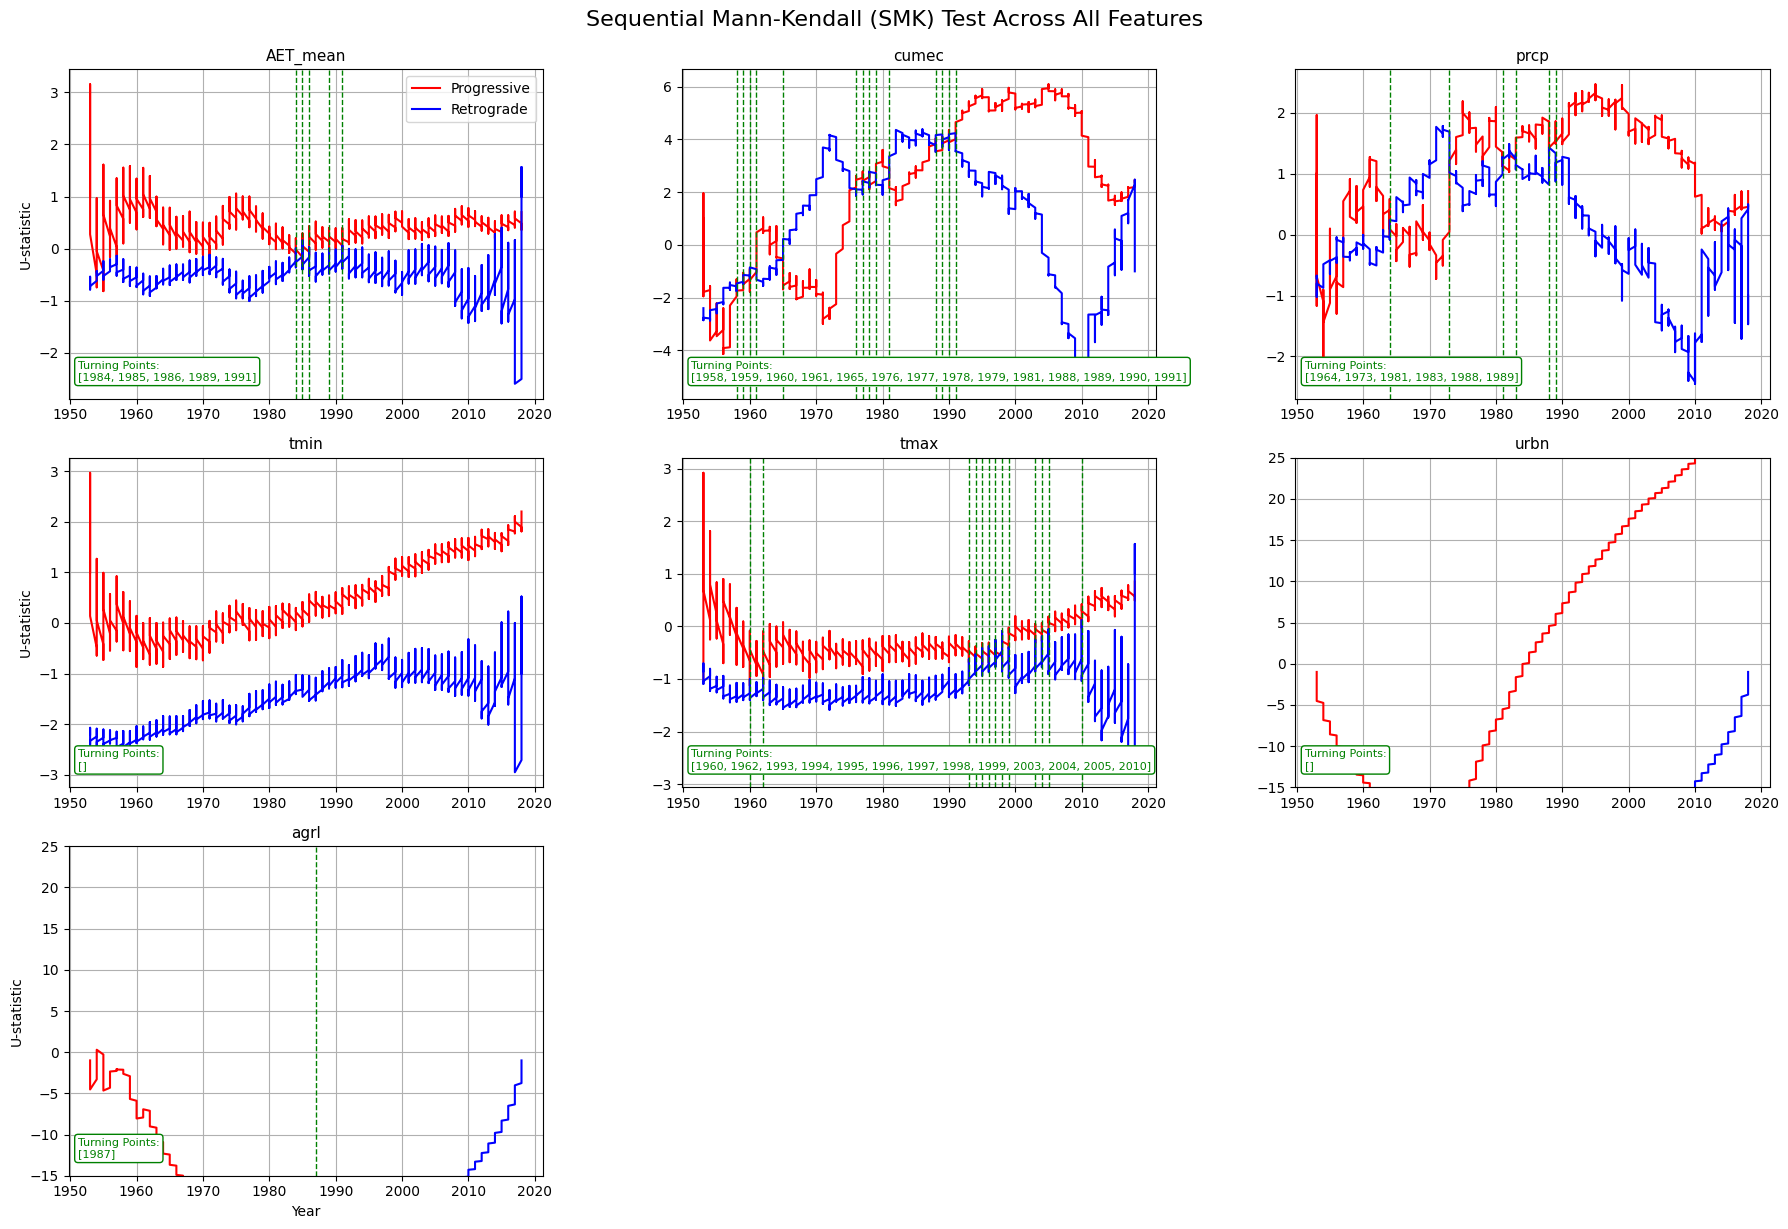

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import math

df_monthly = pd.read_csv("df_monthly.csv")

features = ['AET_mean', 'cumec', 'prcp', 'tmin', 'tmax',
             'urbn', 'agrl']

cols = 3
rows = math.ceil(len(features) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4))
axes = axes.flatten()

for idx, feature in enumerate(features):
    ax = axes[idx]
    data_array = df_monthly[['year', feature]].to_numpy()
    result = seq_mk(data_array)

    year = result['year']
    u_prog = result['u_prog']
    u_retr = result['u_retr']

    # Determine first and last 5 years to exclude
    min_year, max_year = year.min(), year.max()
    exclude_range = 4
    valid_turning = sorted(set(
    result[
        (result['turning_point'] == 1) &
        (result['year'] > min_year + exclude_range) &
        (result['year'] < max_year - exclude_range)
    ]['year'].astype(int)
))

    # Plot lines
    ax.plot(year, u_prog, 'r', label='Progressive')
    ax.plot(year, u_retr, 'b', label='Retrograde')

    # Plot turning points
    for ty in valid_turning:
        ax.axvline(ty, color='green', linestyle='--', linewidth=1)
    # Add turning point list as text
    tp_text = f"Turning Points:\n{valid_turning}"
    ax.text(0.02, 0.05, tp_text,
            transform=ax.transAxes,
            fontsize=8, color='green',
            verticalalignment='bottom',
            bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.3'))

    # Rescale y-axis for extreme cases
    if feature in ['urbn', 'agrl']:
        ax.set_ylim(-15, 25)  # tweak as needed

    ax.set_title(f"{feature}", fontsize=11)
    ax.grid(True)

    if idx % cols == 0:
        ax.set_ylabel("U-statistic")
    if idx >= (rows - 1) * cols:
        ax.set_xlabel("Year")

# Delete unused axes
for j in range(len(features), len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
fig.suptitle("Sequential Mann-Kendall (SMK) Test Across All Features", fontsize=16, y=1.02)
axes[0].legend(loc='upper right')
plt.show()

In [60]:
df_monthly['urban_precip'] = df_monthly['urbn'] * df_monthly['prcp']
df_monthly['urban_tmin'] = df_monthly['urbn'] * df_monthly['tmin']

In [61]:
df_monthly.head()

year  month  AET_mean  Base flow (cumec)      cumec       prcp       tmin  \
0  1953      1  0.583884           1.910381   2.477263   2.451741   4.776238   
1  1953      2  0.816403           6.706953   8.405033   6.489219   5.023421   
2  1953      3  0.946147           3.309123   4.121465   3.062908  12.463922   
3  1953      4  1.284196          11.491697  15.090967   9.570047  11.506437   
4  1953      5  2.992212          18.721938  23.146700  11.184686  17.678627   

        tmax  urbn  agrl    past    fomi  rnge  season_Autumn  season_Spring  \
0  18.717121   0.0   0.0  0.0197  0.8917   0.0          False          False   
1  16.718589   0.0   0.0  0.0197  0.8917   0.0          False          False   
2  23.972142   0.0   0.0  0.0197  0.8917   0.0          False           True   
3  25.207965   0.0   0.0  0.0197  0.8917   0.0          False           True   
4  29.080061   0.0   0.0  0.0197  0.8917   0.0          False           True   

   season_Summer  season_Winter  urban_precip  urban_tmin  
0          False           True           0.0         0.0  
1          False           True           0.0         0.0  
2          False          False           0.0         0.0  
3          False          False           0.0         0.0  
4          False          False           0.0         0.0

In [62]:
intervals

[(1953, 1963), (1963, 1976), (1976, 1992), (1992, 2003), (2003, 2018)]

[1958, 1959, 1960, 1961, 1963, 1964, 1976, 1977, 1978, 1979, 1980, 1992, 1993, 1996, 1997, 1998, 2000, 2003, 2004]
 Processing interval: 1953 to 1963
 Processing interval: 1963 to 1976
 Processing interval: 1976 to 1992
 Processing interval: 1992 to 2003
 Processing interval: 2003 to 2018


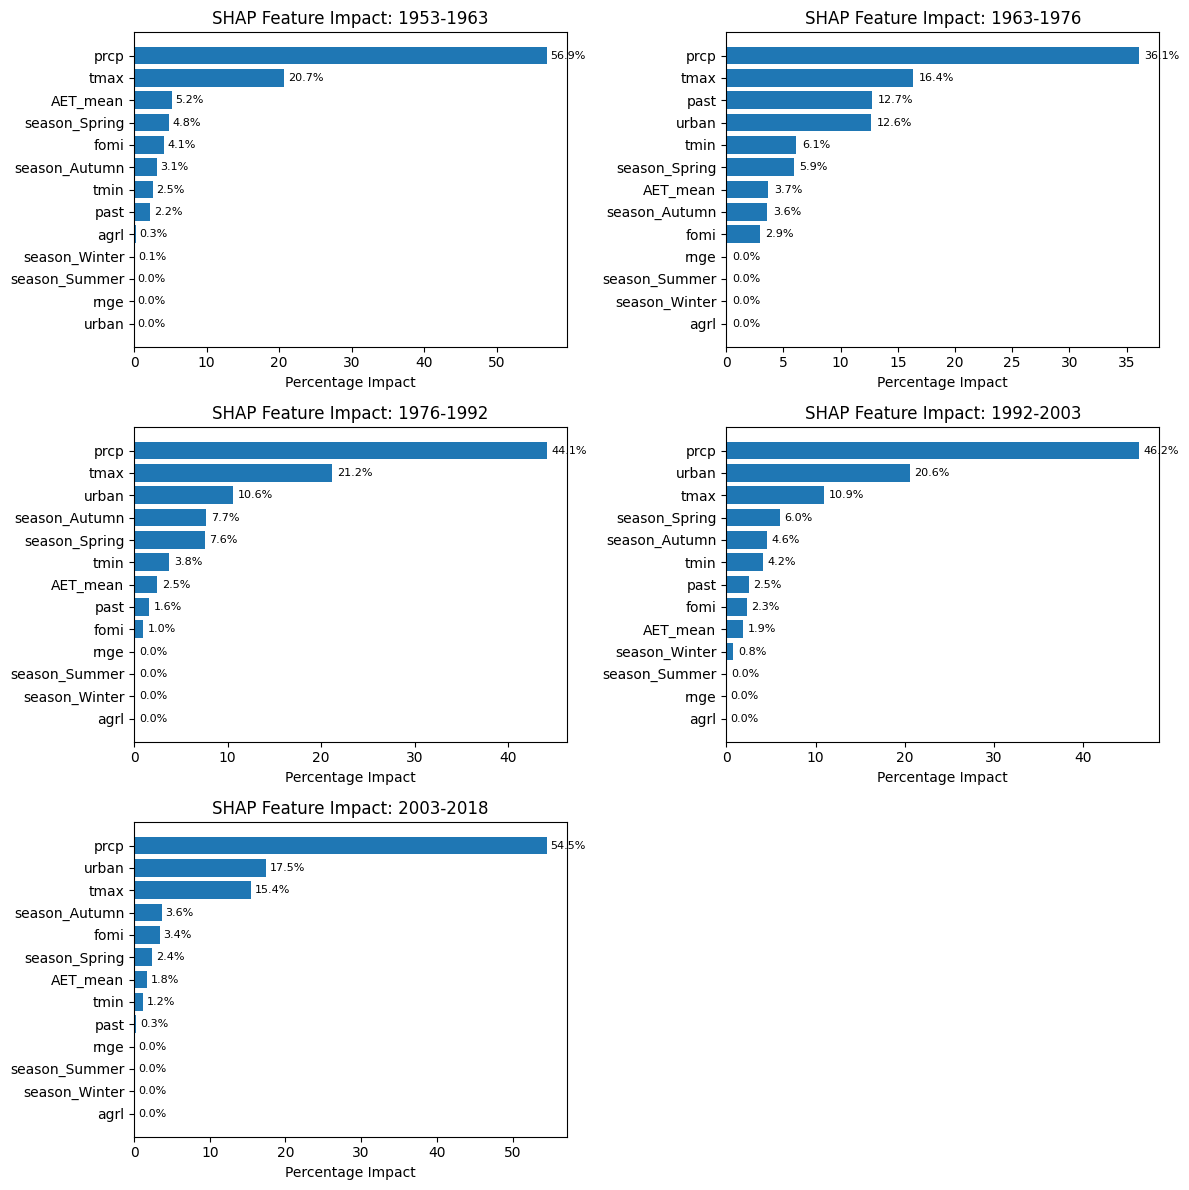

In [63]:
df_monthly = df_monthly.copy()
print(turning_points)
target = 'cumec'
features = [col for col in df_monthly.columns if col not in ['year', target, 'Base flow (cumec)', 'month']]
group_map = {
    "urban": ["urban_precip", "urbn", "urban_tmin"]
}

# Best model params
best_params = {
    'colsample_bytree': 1,
    'learning_rate': 0.01,
    'max_depth': 3,
    'n_estimators': 300,
    'subsample': 0.8
}

intervals = intervals

# Function to compute percentage impact
def get_percentage_impact(shap_vals, columns, group_map):
    df_shap = pd.DataFrame(shap_vals, columns=columns)
    grouped_shap = {}

    for group_name, feature_list in group_map.items():
        grouped_shap[group_name] = df_shap[feature_list].abs().sum(axis=1)

    for col in columns:
        if not any(col in v for v in group_map.values()):
            grouped_shap[col] = df_shap[col].abs()

    grouped_df = pd.DataFrame(grouped_shap)
    mean_abs = grouped_df.mean()
    pct = 100 * mean_abs / mean_abs.sum()
    return pct.sort_values()

# Store all results
interval_importances = {}

for start, end in intervals:
    print(f" Processing interval: {start} to {end}")

    df_interval = df_monthly[(df_monthly['year'] >= start) & (df_monthly['year'] < end)]
    X = df_interval[features].copy()
    y = df_interval[target]
    bool_cols = X.select_dtypes(include='bool').columns
    X[bool_cols] = X[bool_cols].astype(int)

    model = xgb.XGBRegressor(**best_params, random_state=42)
    model.fit(X, y)

    explainer = shap.Explainer(model, X)
    shap_values = explainer(X)

    # SHAP values array
    shap_vals = shap_values.values if hasattr(shap_values, 'values') else shap_values

    impact = get_percentage_impact(shap_vals, features, group_map)
    interval_importances[f"{start}-{end}"] = impact

# =======================
# Plot All Intervals
# =======================
n_intervals = len(interval_importances)
n_cols = 2
n_rows = math.ceil(n_intervals / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows), sharex=False)
axes = axes.flatten()

for ax, (interval, imp) in zip(axes, interval_importances.items()):
    ax.barh(imp.index, imp.values)
    ax.set_title(f"SHAP Feature Impact: {interval}")
    ax.set_xlabel("Percentage Impact")
    for i, v in enumerate(imp.values):
        ax.text(v + 0.5, i, f"{v:.1f}%", va='center', fontsize=8)

# Remove unused subplots if any
for i in range(len(interval_importances), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# fig, axes = plt.subplots(nrows=len(interval_importances), figsize=(12, len(interval_importances)*3), sharex=True)

# for ax, (interval, imp) in zip(axes, interval_importances.items()):
#     ax.barh(imp.index, imp.values)
#     ax.set_title(f"SHAP Feature Impact: {interval}")
#     ax.set_xlabel("Percentage Impact")
#     for i, v in enumerate(imp.values):
#         ax.text(v + 0.5, i, f"{v:.1f}%", va='center', fontsize=8)

# plt.tight_layout()
# plt.show();


In [64]:
df_monthly.head()

year  month  AET_mean  Base flow (cumec)      cumec       prcp       tmin  \
0  1953      1  0.583884           1.910381   2.477263   2.451741   4.776238   
1  1953      2  0.816403           6.706953   8.405033   6.489219   5.023421   
2  1953      3  0.946147           3.309123   4.121465   3.062908  12.463922   
3  1953      4  1.284196          11.491697  15.090967   9.570047  11.506437   
4  1953      5  2.992212          18.721938  23.146700  11.184686  17.678627   

        tmax  urbn  agrl    past    fomi  rnge  season_Autumn  season_Spring  \
0  18.717121   0.0   0.0  0.0197  0.8917   0.0          False          False   
1  16.718589   0.0   0.0  0.0197  0.8917   0.0          False          False   
2  23.972142   0.0   0.0  0.0197  0.8917   0.0          False           True   
3  25.207965   0.0   0.0  0.0197  0.8917   0.0          False           True   
4  29.080061   0.0   0.0  0.0197  0.8917   0.0          False           True   

   season_Summer  season_Winter  urban_precip  urban_tmin  
0          False           True           0.0         0.0  
1          False           True           0.0         0.0  
2          False          False           0.0         0.0  
3          False          False           0.0         0.0  
4          False          False           0.0         0.0

In [65]:
df_seasons = df_monthly.drop(columns=['season_Autumn','season_Spring','season_Summer','season_Winter'])
df_seasons.head()

year  month  AET_mean  Base flow (cumec)      cumec       prcp       tmin  \
0  1953      1  0.583884           1.910381   2.477263   2.451741   4.776238   
1  1953      2  0.816403           6.706953   8.405033   6.489219   5.023421   
2  1953      3  0.946147           3.309123   4.121465   3.062908  12.463922   
3  1953      4  1.284196          11.491697  15.090967   9.570047  11.506437   
4  1953      5  2.992212          18.721938  23.146700  11.184686  17.678627   

        tmax  urbn  agrl    past    fomi  rnge  urban_precip  urban_tmin  
0  18.717121   0.0   0.0  0.0197  0.8917   0.0           0.0         0.0  
1  16.718589   0.0   0.0  0.0197  0.8917   0.0           0.0         0.0  
2  23.972142   0.0   0.0  0.0197  0.8917   0.0           0.0         0.0  
3  25.207965   0.0   0.0  0.0197  0.8917   0.0           0.0         0.0  
4  29.080061   0.0   0.0  0.0197  0.8917   0.0           0.0         0.0

In [66]:
season_months = {
    'Summer': [6, 7, 8],    # June, July, August
    'Autumn': [9, 10, 11],  # September, October, November
    'Winter': [12, 1, 2],   # December, January, February
    'Spring': [3, 4, 5]     # March, April, May
}

# A dictionary to hold seasonal data
seasonal_means = {}

for season, months in season_months.items():

    season_df = df_seasons[df_seasons['month'].isin(months)]

    season_mean = season_df.groupby('year').mean()
    seasonal_means[season] = season_mean

# Reset index to get 'year' as a column
for season in seasonal_means:
    seasonal_means[season] = seasonal_means[season].reset_index()

# Assign seasonal data
summer_data = seasonal_means['Summer']
winter_data = seasonal_means['Winter']
spring_data = seasonal_means['Spring']
autumn_data = seasonal_means['Autumn']

In [68]:
summer_df = seasonal_means['Summer']
winter_df = seasonal_means['Winter']
spring_df = seasonal_means['Spring']
autumn_df = seasonal_means['Autumn']

In [69]:
def filter_significant_turning_points(df, turning_points, change_threshold=2.5, min_interval_gap=10):
    filtered_tp = []
    start_year = df['year'].min()
    end_year = df['year'].max()

    # First always include the start year
    last_added_year = start_year
    filtered_tp.append(start_year)

    for year in turning_points:
        if year < start_year or year > end_year:
            continue

        cumec_current = df.loc[df['year'] == year, 'cumec'].values[0]
        cumec_last = df.loc[df['year'] == last_added_year, 'cumec'].values[0]

        if cumec_last == 0:
            continue

        relative_change = abs(cumec_current - cumec_last) / abs(cumec_last)

        if (relative_change >= change_threshold) and (year - last_added_year >= min_interval_gap):
            filtered_tp.append(year)
            last_added_year = year

    # Always include the end year if not already included
    if filtered_tp[-1] != end_year:
        filtered_tp.append(end_year)

    return filtered_tp

In [70]:
filtered_tp_sws = [1990]
filtered_tp_aut = [1974]

In [71]:
interval_sws = [(1953,1990),(1991,2018)]
interval_aut = [(1953,1974),(1975,2018)]

In [72]:
def process_season(df_season, season_name, intervals):
    print(f"\n=== Processing Season: {season_name} ===")

    # Excluding first and last 5 years
    min_year = df_season['year'].min() + 5
    max_year = df_season['year'].max() - 5
    filtered_df = df_season[(df_season['year'] >= min_year) & (df_season['year'] <= max_year)]

    # Sequential Mann-Kendall (SMK) Test
    data_array = filtered_df[['year', 'cumec']].to_numpy()
    result = seq_mk(data_array)

    # Using provided intervals
    print("Intervals:", intervals)

    for interval in intervals:
        start, end = interval
        interval_data = df_season[(df_season['year'] >= start) & (df_season['year'] <= end)]
        #print(f"Processing interval {start} - {end} with {len(interval_data)} records.")

    # (Here you can continue with any per-interval analysis...)

# Define intervals
interval_sws = [(1953,1990), (1991,2018)]
interval_aut = [(1953,1974), (1975,2018)]

# Call process_season
process_season(summer_df, "Summer", interval_sws)
process_season(winter_df, "Winter", interval_sws)
process_season(spring_df, "Spring", interval_sws)
process_season(autumn_df, "Autumn", interval_aut)



=== Processing Season: Summer ===
Intervals: [(1953, 1990), (1991, 2018)]

=== Processing Season: Winter ===
Intervals: [(1953, 1990), (1991, 2018)]

=== Processing Season: Spring ===
Intervals: [(1953, 1990), (1991, 2018)]

=== Processing Season: Autumn ===
Intervals: [(1953, 1974), (1975, 2018)]


In [73]:
# def process_season(df_season, season_name):
#     print(f"\n=== Processing Season: {season_name} ===")

#     # Excluding first and last 5 years
#     min_year = df_season['year'].min() + 5
#     max_year = df_season['year'].max() - 5
#     filtered_df = df_season[(df_season['year'] >= min_year) & (df_season['year'] <= max_year)]

#     # Sequential Mann-Kendall (SMK) Test
#     data_array = filtered_df[['year', 'cumec']].to_numpy()
#     result = seq_mk(data_array)

#     # Find turning points
#     turning_points = result[result['turning_point'] == 1]['year'].drop_duplicates().sort_values().astype(int).tolist()
#     print("Raw Turning Points:", turning_points)

#     # Filter turning points
#     start_year = df_season['year'].min()
#     end_year = df_season['year'].max()

#     filtered_tp = filter_significant_turning_points(df_season, turning_points, change_threshold=0.15, min_interval_gap=10)

#     # Ensure start and end year included properly
#     if filtered_tp[0] != start_year:
#         filtered_tp = [start_year] + filtered_tp
#     if filtered_tp[-1] != end_year:
#         filtered_tp.append(end_year)

#     # Remove duplicates if any
#     filtered_tp = sorted(list(set(filtered_tp)))

#     # Create intervals
#     intervals = [(filtered_tp[i], filtered_tp[i+1]) for i in range(len(filtered_tp)-1)]

#     #print("Filtered Turning Points:", filtered_tp)
#     print("Intervals:", intervals)


In [74]:
process_season(summer_df, "Summer",interval_sws)
process_season(winter_df, "Winter",interval_sws)
process_season(spring_df, "Spring",interval_sws)
process_season(autumn_df, "Autumn",interval_aut)


=== Processing Season: Summer ===
Intervals: [(1953, 1990), (1991, 2018)]

=== Processing Season: Winter ===
Intervals: [(1953, 1990), (1991, 2018)]

=== Processing Season: Spring ===
Intervals: [(1953, 1990), (1991, 2018)]

=== Processing Season: Autumn ===
Intervals: [(1953, 1974), (1975, 2018)]


In [75]:
# def plot_season_features(df_season, season_name, change_points):
#     features = ['AET_mean', 'cumec', 'prcp', 'tmin', 'tmax', 'urbn', 'agrl']
#     all_years = [df_season['year'].min()] + change_points + [df_season['year'].max()]

#     n_features = len(features)
#     n_cols = 3
#     n_rows = math.ceil(n_features / n_cols)

#     fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows), sharex=True)
#     axes = axes.flatten()

#     for i, feature in enumerate(features):
#         ax = axes[i]
#         sns.lineplot(x=df_season['year'], y=df_season[feature], ax=ax)

#         for j in range(len(all_years) - 1):
#             start = all_years[j]
#             end = all_years[j + 1]
#             mask = (df_season['year'] >= start) & (df_season['year'] < end)
#             mean_val = df_season.loc[mask, feature].mean()

#             ax.hlines(mean_val, xmin=start, xmax=end, colors='C'+str(j), linestyles='dashed', label=f'Mean {start}-{end-1}')

#         ax.set_title(f"{feature}")
#         ax.set_ylabel(feature)
#         ax.grid(True)
#         ax.legend(fontsize='small')

#     for j in range(i + 1, len(axes)):
#         fig.delaxes(axes[j])

#     plt.xlabel("Year")
#     plt.tight_layout()
#     plt.suptitle(f"{season_name} - Time Series with Mean Lines", fontsize=16, y=1.02)
#     plt.show()

# def process_season(df_season, season_name):
#     print(f"\n=== Processing Season: {season_name} ===")

#     # Step 1: Exclude first and last 5 years
#     min_year = df_season['year'].min() + 5
#     max_year = df_season['year'].max() - 5
#     filtered_df = df_season[(df_season['year'] >= min_year) & (df_season['year'] <= max_year)]

#     # Step 2: Sequential Mann-Kendall (SMK) Test
#     data_array = filtered_df[['year', 'cumec']].to_numpy()
#     result = seq_mk(data_array)

#     # Step 3: Find turning points
#     turning_points = result[result['turning_point'] == 1]['year'].drop_duplicates().sort_values().astype(int).tolist()
#     #print("Raw Turning Points:", turning_points)

#     # Step 4: Filter turning points
#     start_year = df_season['year'].min()
#     end_year = df_season['year'].max()

#     filtered_tp = filter_significant_turning_points(df_season, turning_points, change_threshold=0.15, min_interval_gap=10)

#     # Ensure start and end year included properly
#     if filtered_tp[0] != start_year:
#         filtered_tp = [start_year] + filtered_tp
#     if filtered_tp[-1] != end_year:
#         filtered_tp.append(end_year)

#     # Remove duplicates if any
#     filtered_tp = sorted(list(set(filtered_tp)))

#     # Step 5: Create intervals
#     intervals = [(filtered_tp[i], filtered_tp[i+1]) for i in range(len(filtered_tp)-1)]

#     print("Filtered Turning Points:", filtered_tp)
#     print("Intervals:", intervals)

#     # Step 6: Plotting
#     plot_season_features(df_season, season_name, filtered_tp)
#     return intervals


In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

def plot_season_features(df_season, season_name, intervals):
    features = ['AET_mean', 'cumec', 'prcp', 'tmin', 'tmax', 'urbn', 'agrl']

    n_features = len(features)
    n_cols = 3
    n_rows = math.ceil(n_features / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows), sharex=True)
    axes = axes.flatten()

    for i, feature in enumerate(features):
        ax = axes[i]
        sns.lineplot(x=df_season['year'], y=df_season[feature], ax=ax, label='Actual', color='black')

        for j, (start, end) in enumerate(intervals):
            mask = (df_season['year'] >= start) & (df_season['year'] <= end)
            mean_val = df_season.loc[mask, feature].mean()

            ax.hlines(mean_val, xmin=start, xmax=end, colors=f'C{j}', linestyles='dashed', label=f'Mean {start}-{end}')

        ax.set_title(f"{feature}")
        ax.set_ylabel(feature)
        ax.grid(True)
        ax.legend(fontsize='small')

    # Remove any extra empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.xlabel("Year")
    plt.tight_layout()
    plt.suptitle(f"{season_name} - Time Series with Mean Lines", fontsize=16, y=1.02)
    plt.show()


In [77]:
def process_season(df_season, season_name, intervals):
    print(f"\n=== Processing Season: {season_name} ===")
    print("Intervals:", intervals)

    plot_season_features(df_season, season_name, intervals)



=== Processing Season: Summer ===
Intervals: [(1953, 1990), (1991, 2018)]


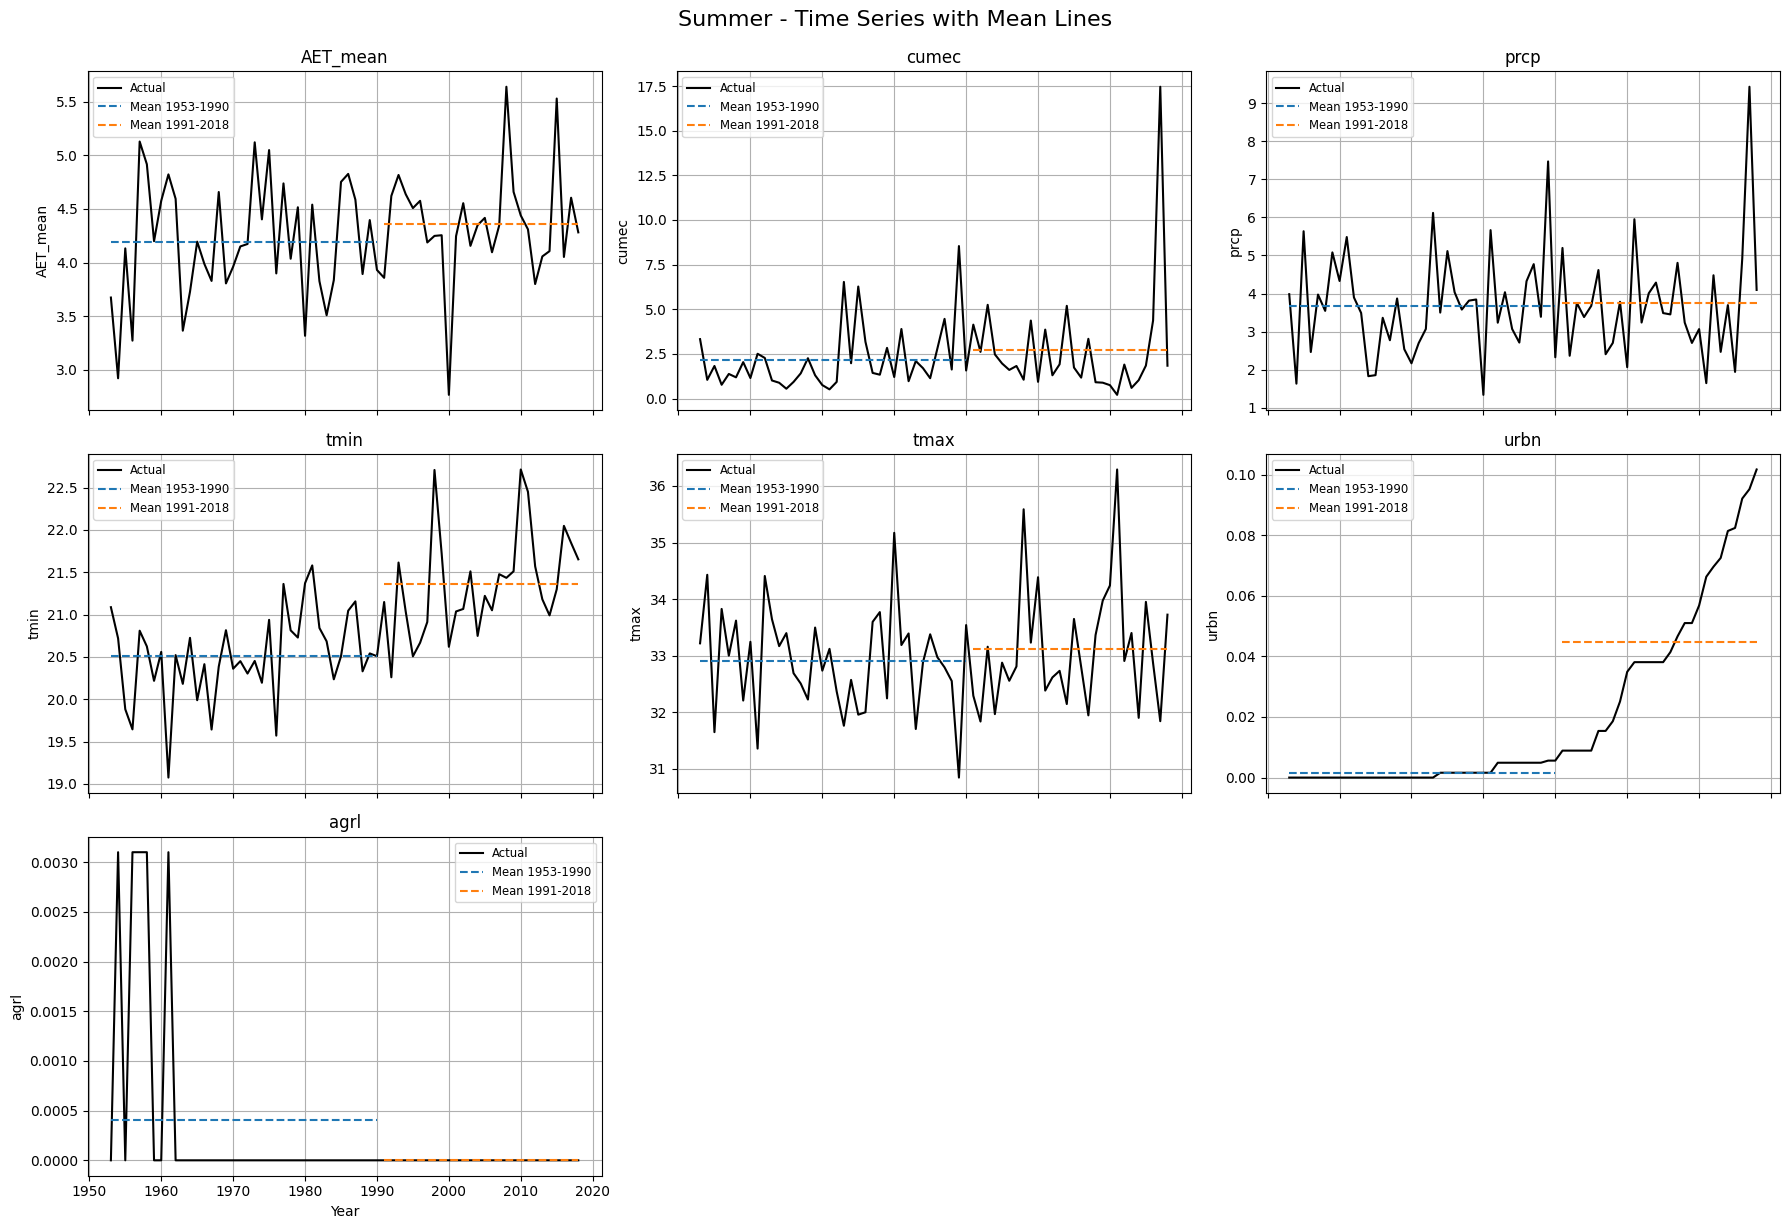


=== Processing Season: Winter ===
Intervals: [(1953, 1990), (1991, 2018)]


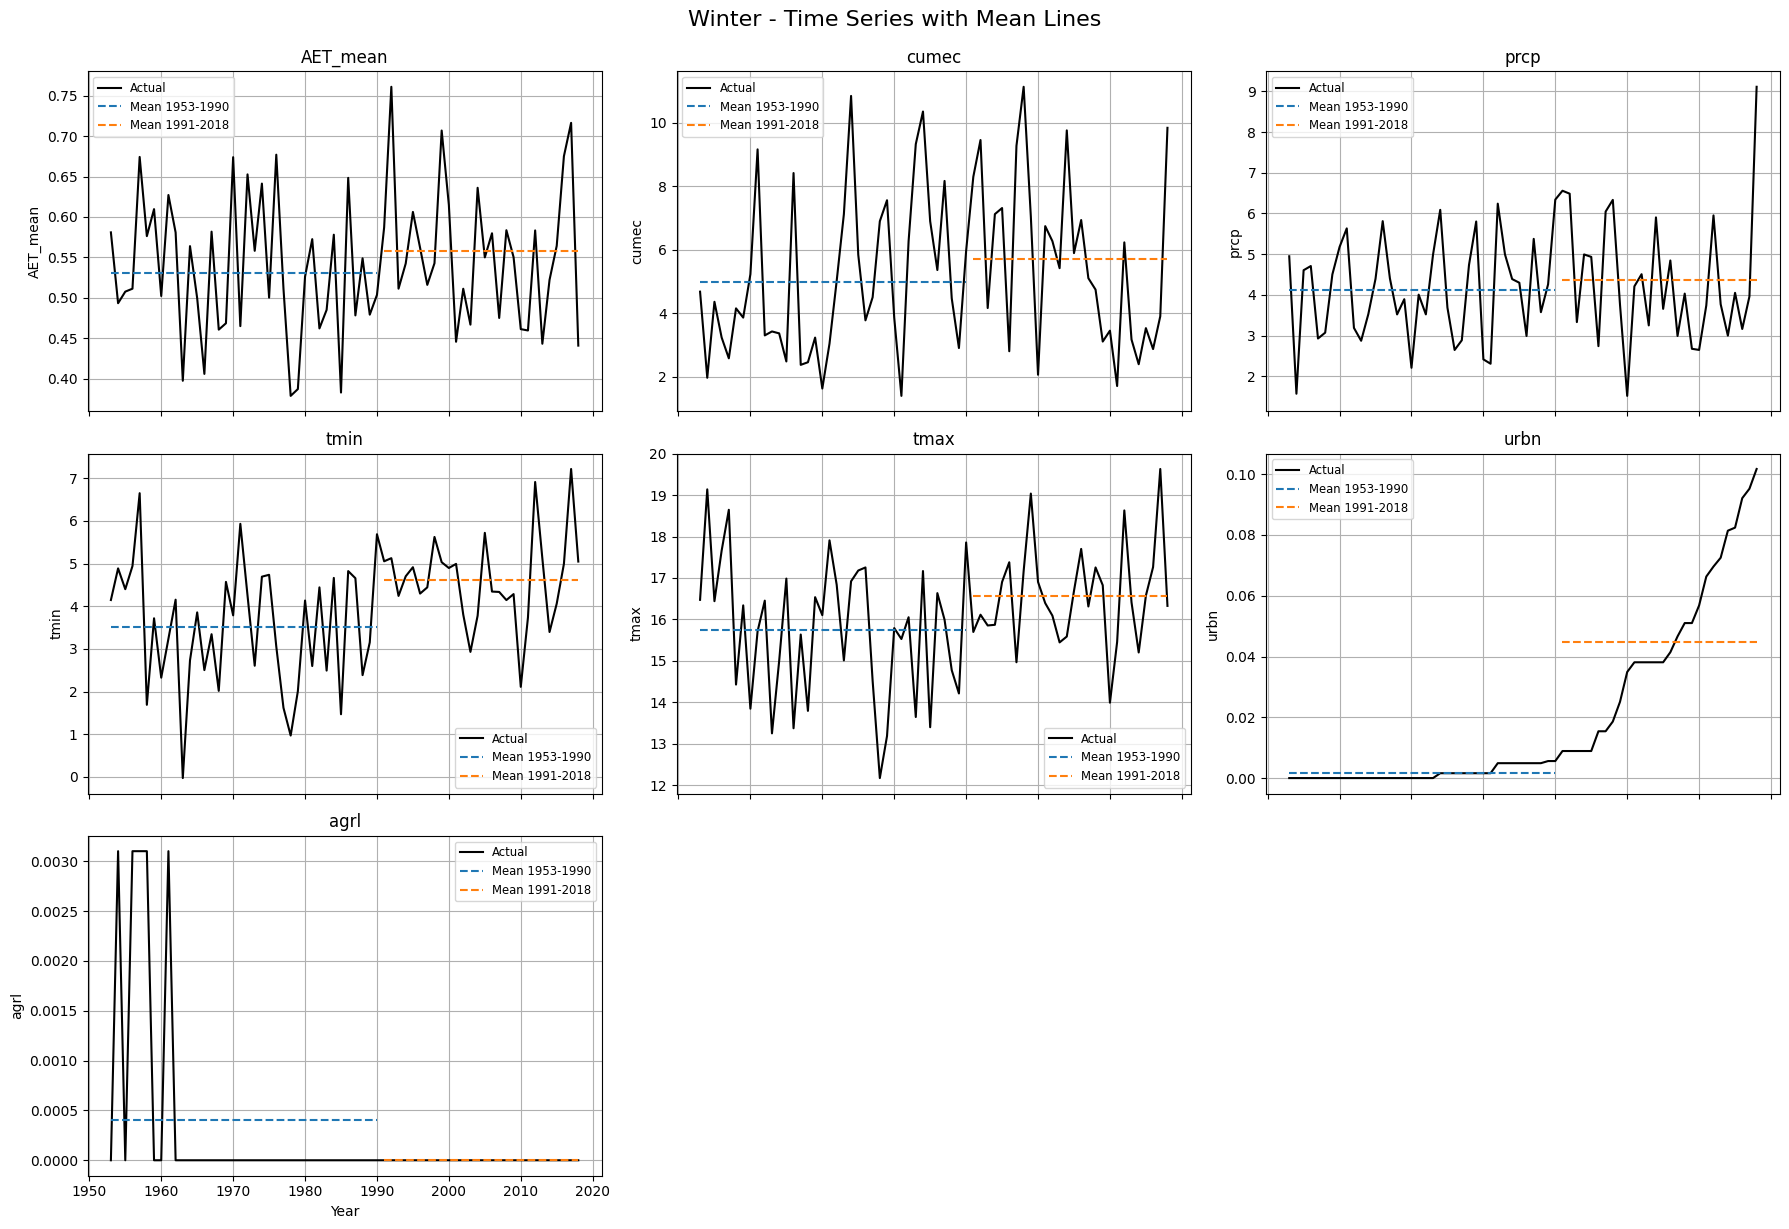


=== Processing Season: Spring ===
Intervals: [(1953, 1990), (1991, 2018)]


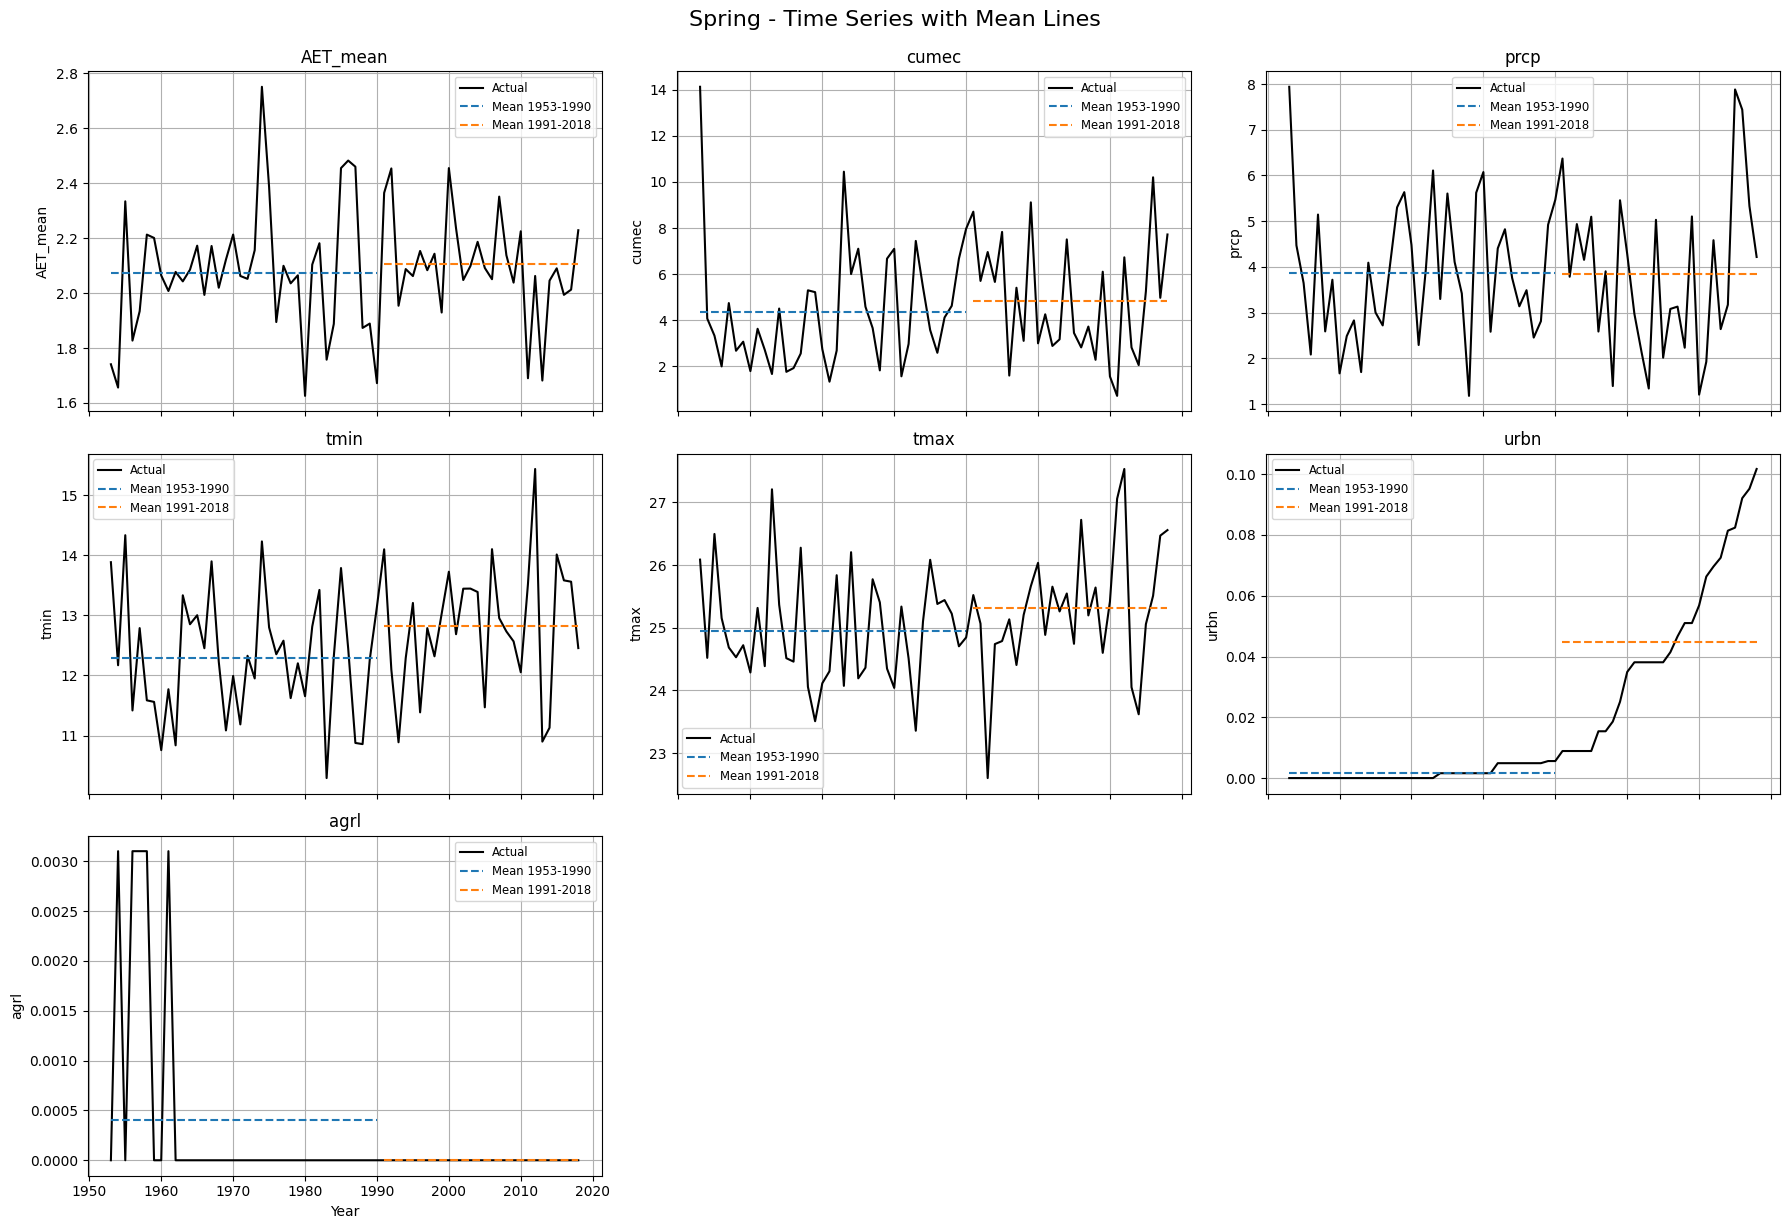


=== Processing Season: Autumn ===
Intervals: [(1953, 1974), (1975, 2018)]


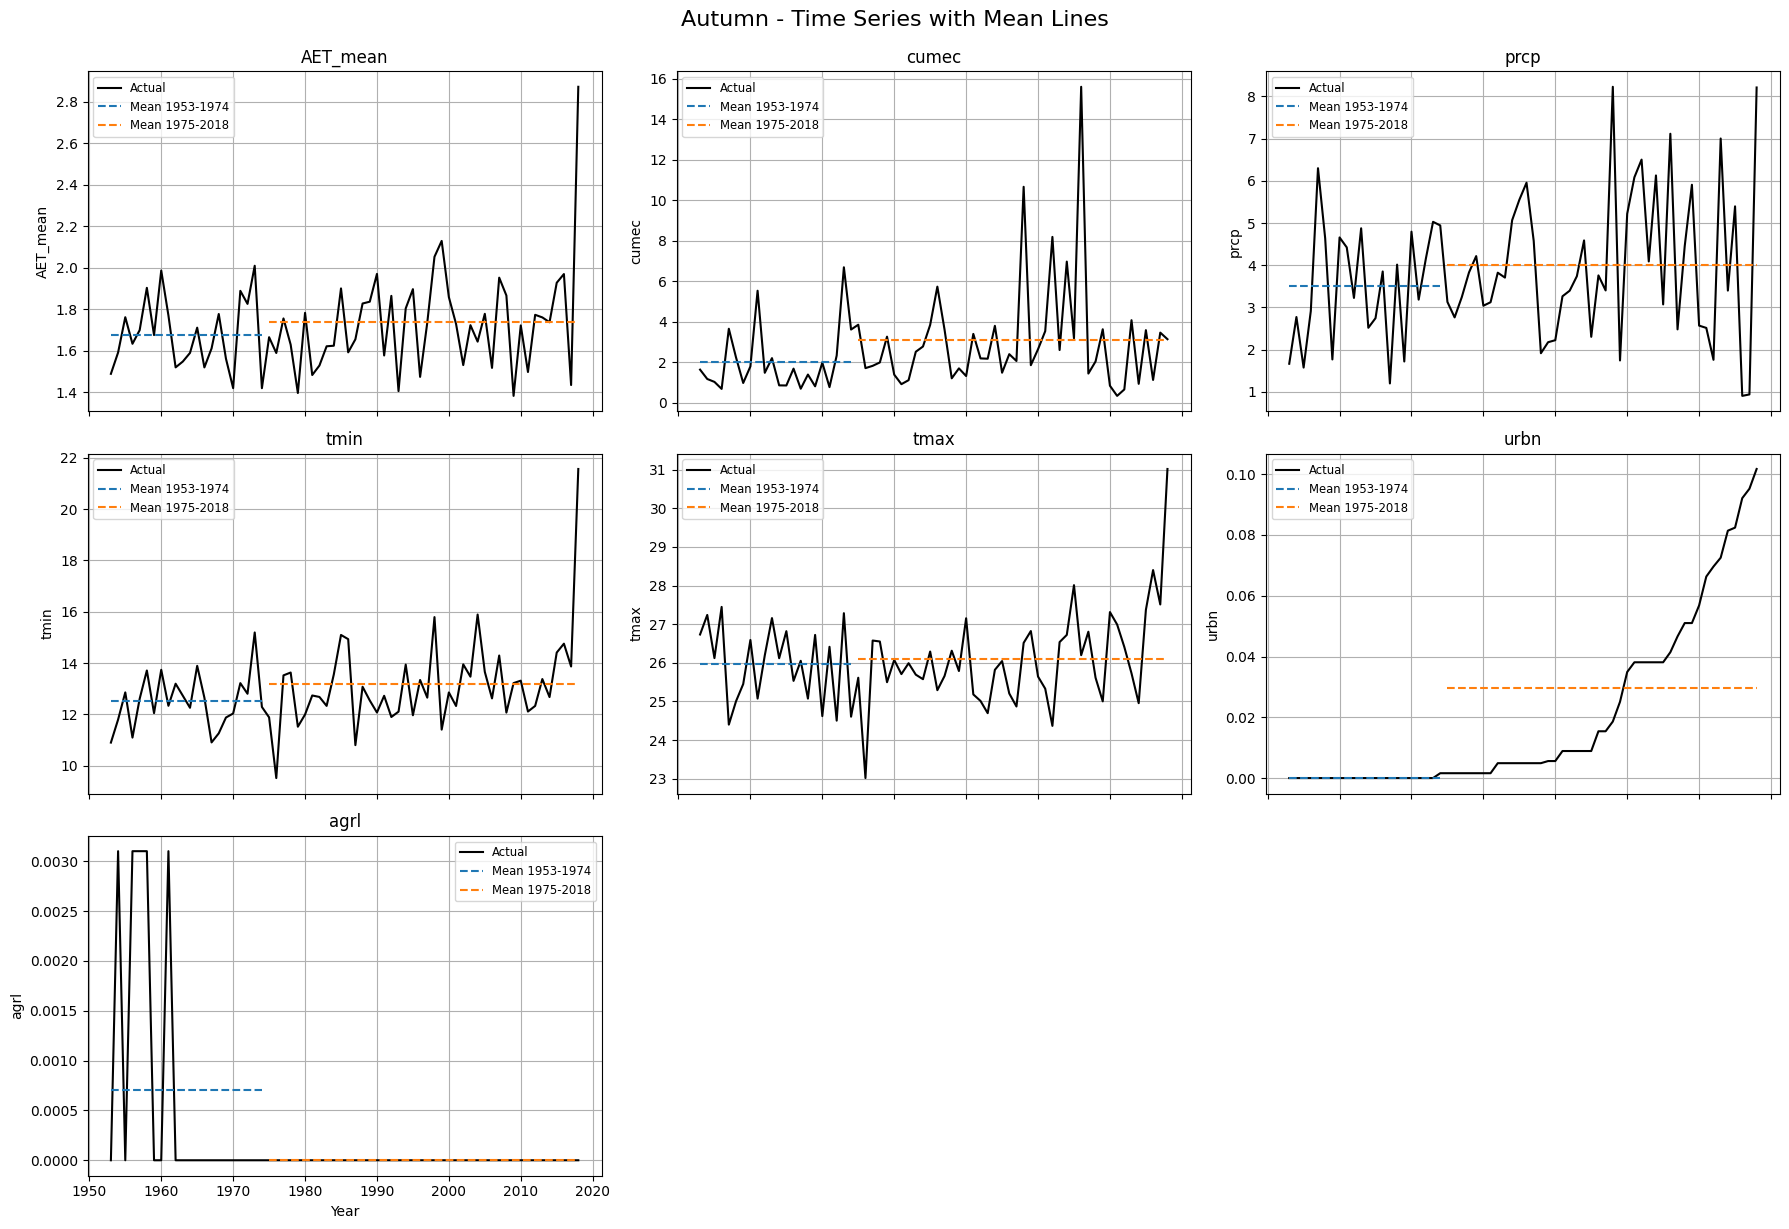

In [78]:
interval_sws = [(1953, 1990), (1991, 2018)]
interval_aut = [(1953, 1974), (1975, 2018)]

process_season(summer_df, "Summer", interval_sws)
process_season(winter_df, "Winter", interval_sws)
process_season(spring_df, "Spring", interval_sws)
process_season(autumn_df, "Autumn", interval_aut)

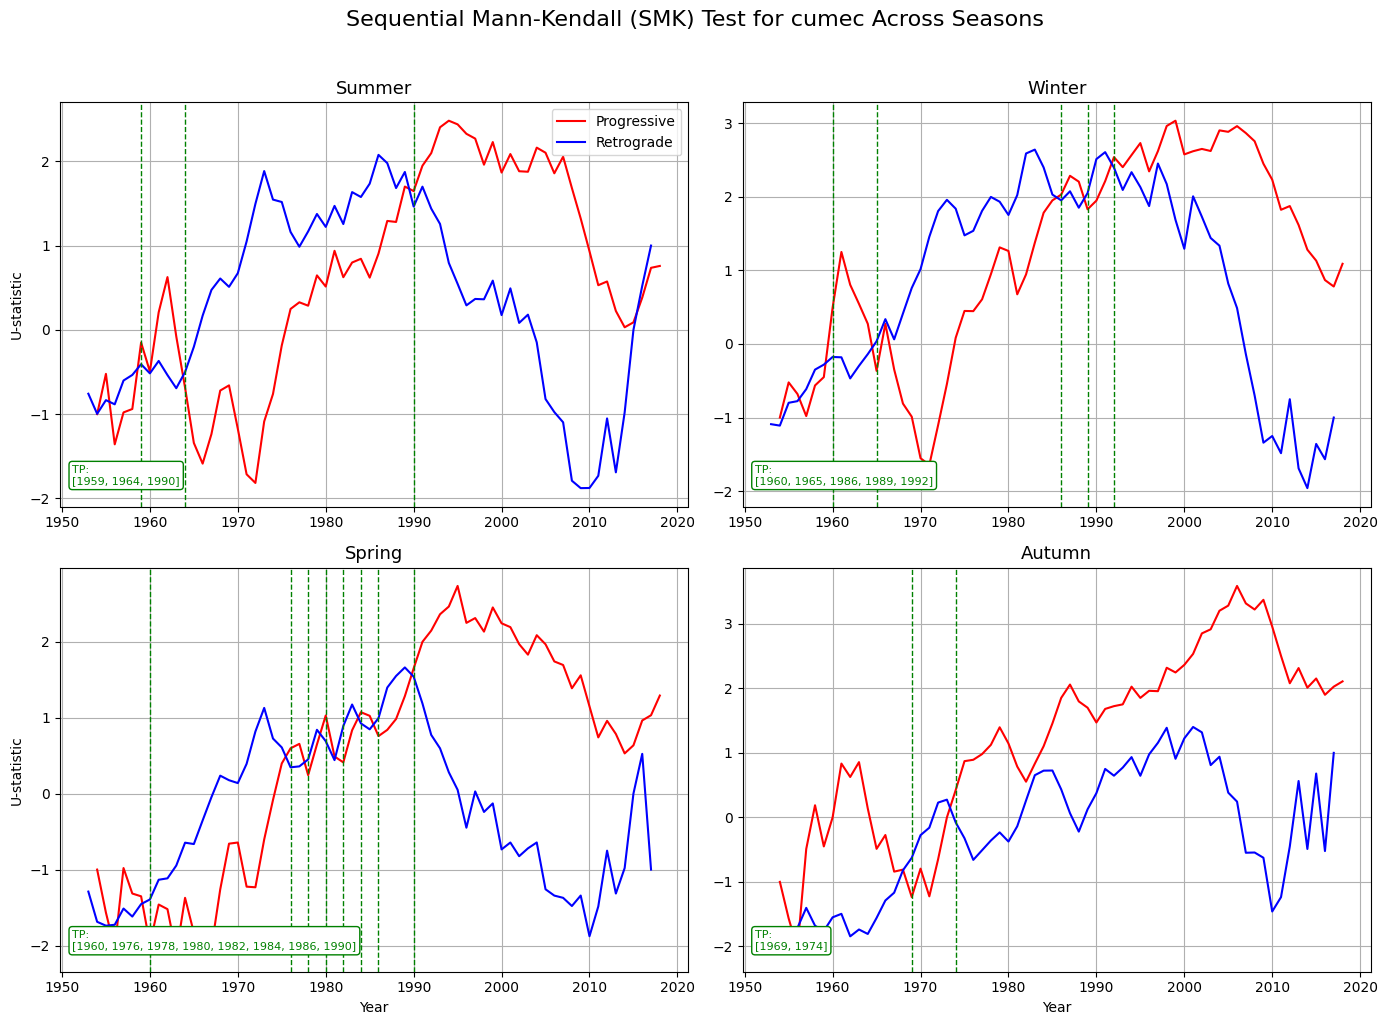

In [88]:
def plot_all_seasons_cumec(season_dfs, season_names):
    feature = 'cumec'
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    for idx, (df_season, season_name) in enumerate(zip(season_dfs, season_names)):
        ax = axes[idx]

        # Prepare data
        data_array = df_season[['year', feature]].to_numpy()
        result = seq_mk(data_array)

        year = result['year']
        u_prog = result['u_prog']
        u_retr = result['u_retr']

        # Exclude first and last 5 years
        min_year, max_year = year.min(), year.max()
        exclude_range = 4
        valid_turning = sorted(set(
            result[
                (result['turning_point'] == 1) &
                (result['year'] > min_year + exclude_range) &
                (result['year'] < max_year - exclude_range)
            ]['year'].astype(int)
        ))

        # Plot U-statistics
        ax.plot(year, u_prog, 'r', label='Progressive')
        ax.plot(year, u_retr, 'b', label='Retrograde')

        # Plot vertical lines for turning points
        for ty in valid_turning:
            ax.axvline(ty, color='green', linestyle='--', linewidth=1)

        # Add turning points as text
        tp_text = f"TP:\n{valid_turning}"
        ax.text(0.02, 0.05, tp_text,
                transform=ax.transAxes,
                fontsize=8, color='green',
                verticalalignment='bottom',
                bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.3'))

        ax.set_title(f"{season_name}", fontsize=13)
        ax.grid(True)

        if idx in [0, 2]:  # Left column
            ax.set_ylabel("U-statistic")
        if idx in [2, 3]:  # Bottom row
            ax.set_xlabel("Year")

    # Hide any extra subplots if fewer than 4
    for j in range(len(season_dfs), len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle("Sequential Mann-Kendall (SMK) Test for cumec Across Seasons", fontsize=16, y=1.02)
    axes[0].legend(loc='upper right')
    plt.tight_layout()
    plt.show()

season_dfs = [summer_df, winter_df, spring_df, autumn_df]
season_names = ["Summer", "Winter", "Spring", "Autumn"]

plot_all_seasons_cumec(season_dfs, season_names)



=== Processing Season: Summer ===


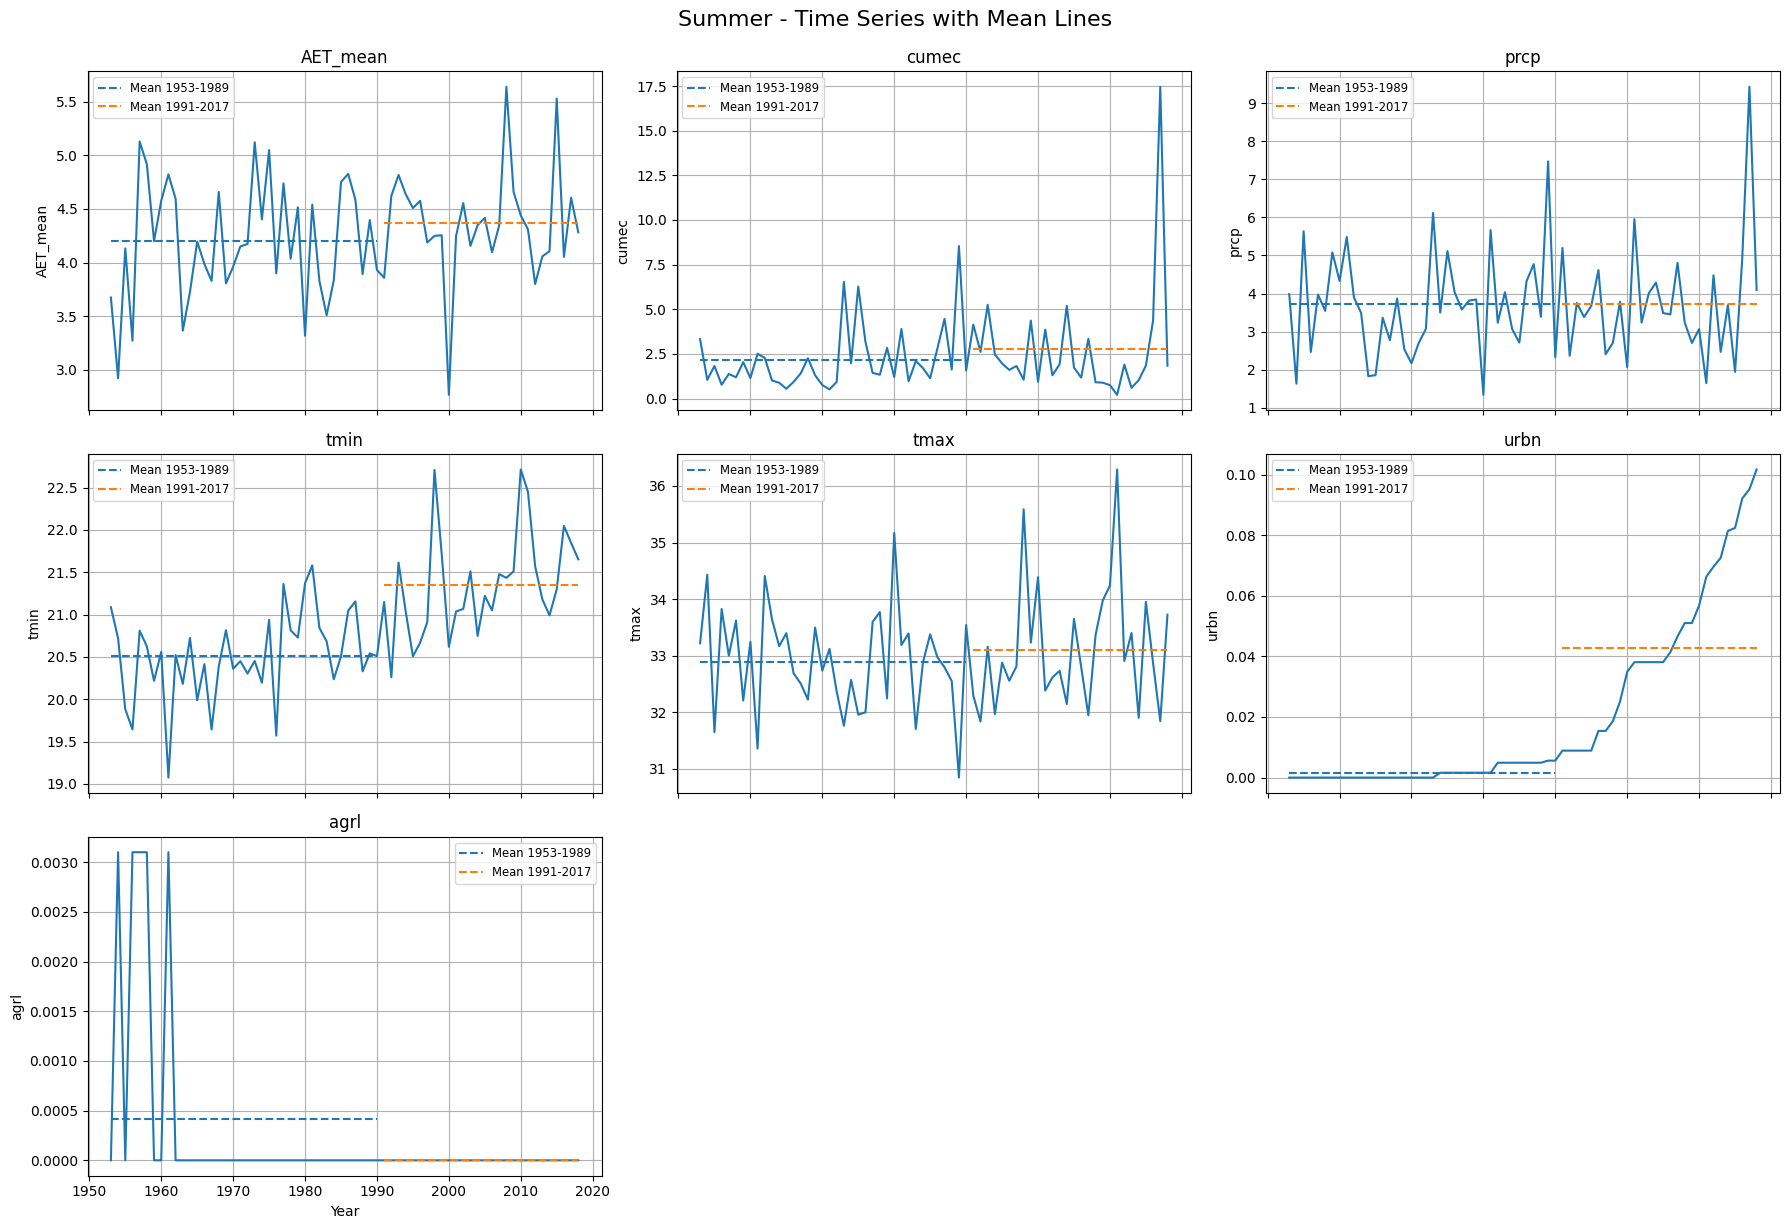

Processing interval 1953-1990 for Summer...
Processing interval 1991-2018 for Summer...


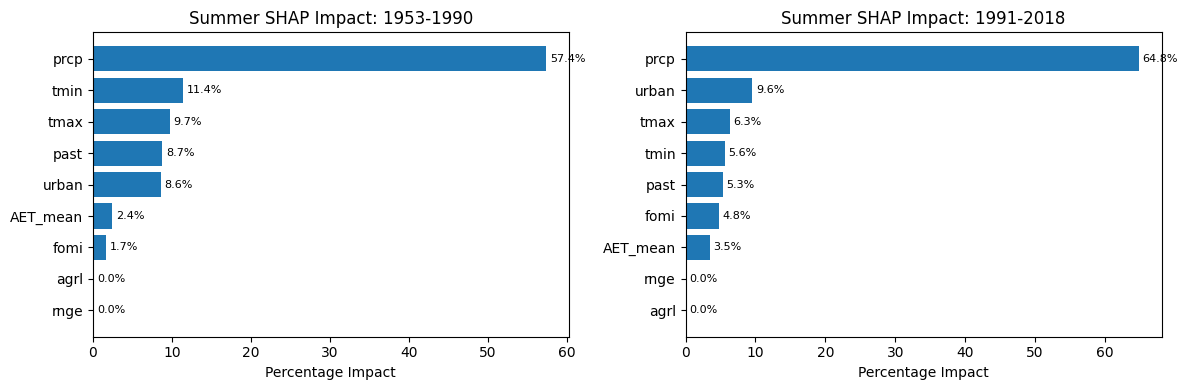


=== Processing Season: Winter ===


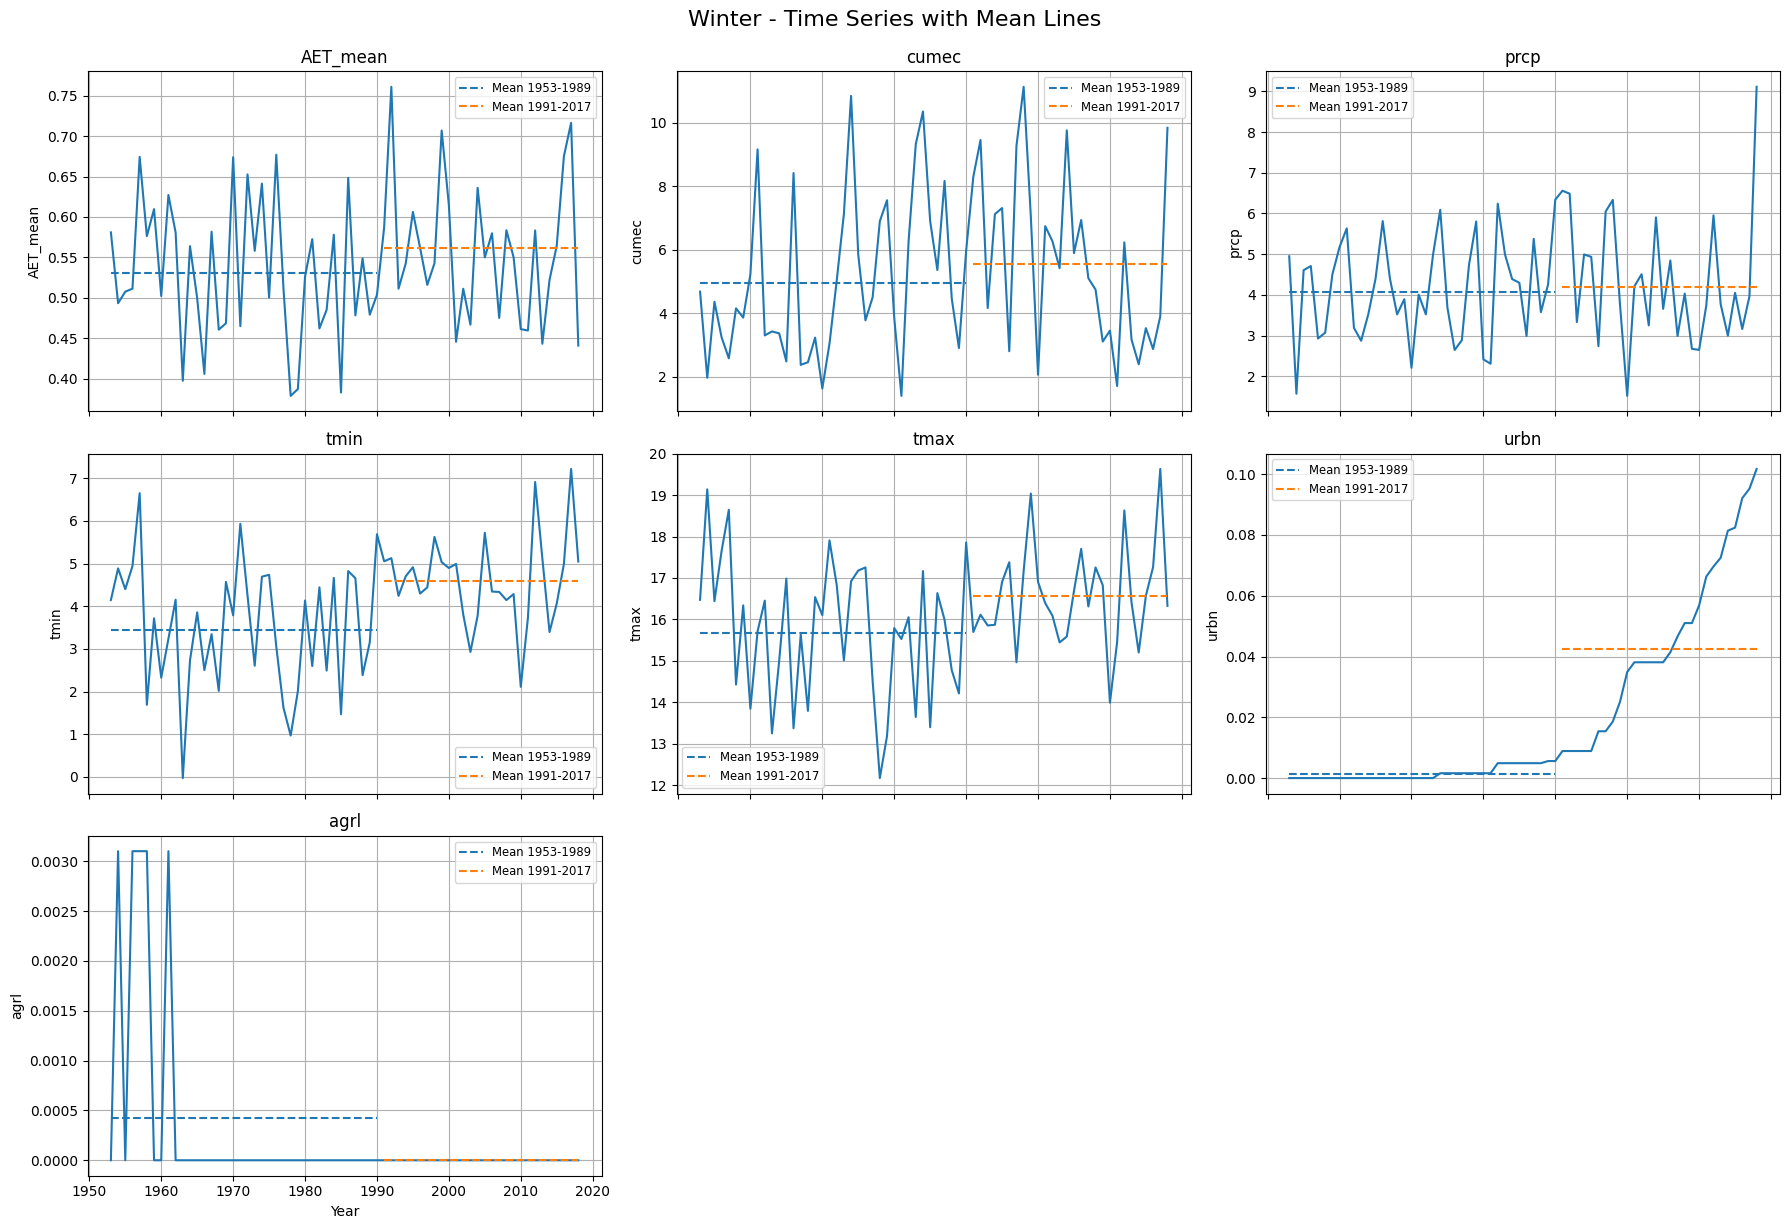

Processing interval 1953-1990 for Winter...
Processing interval 1991-2018 for Winter...


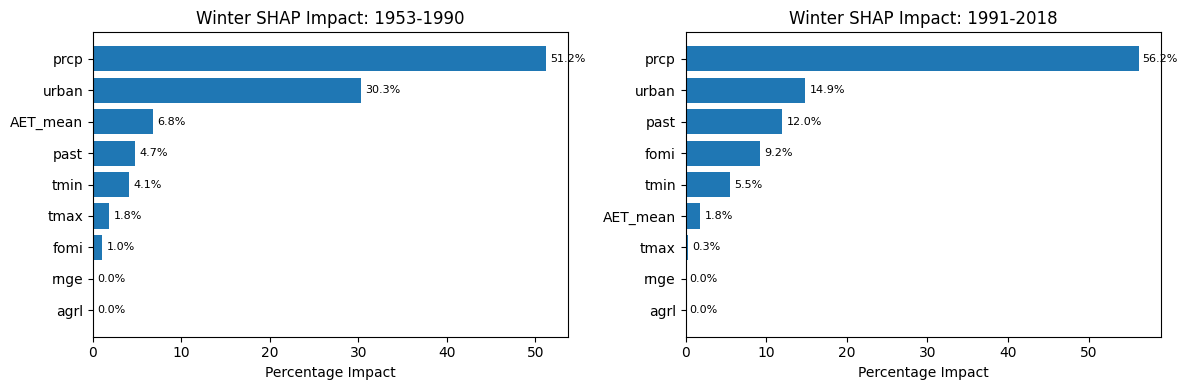


=== Processing Season: Spring ===


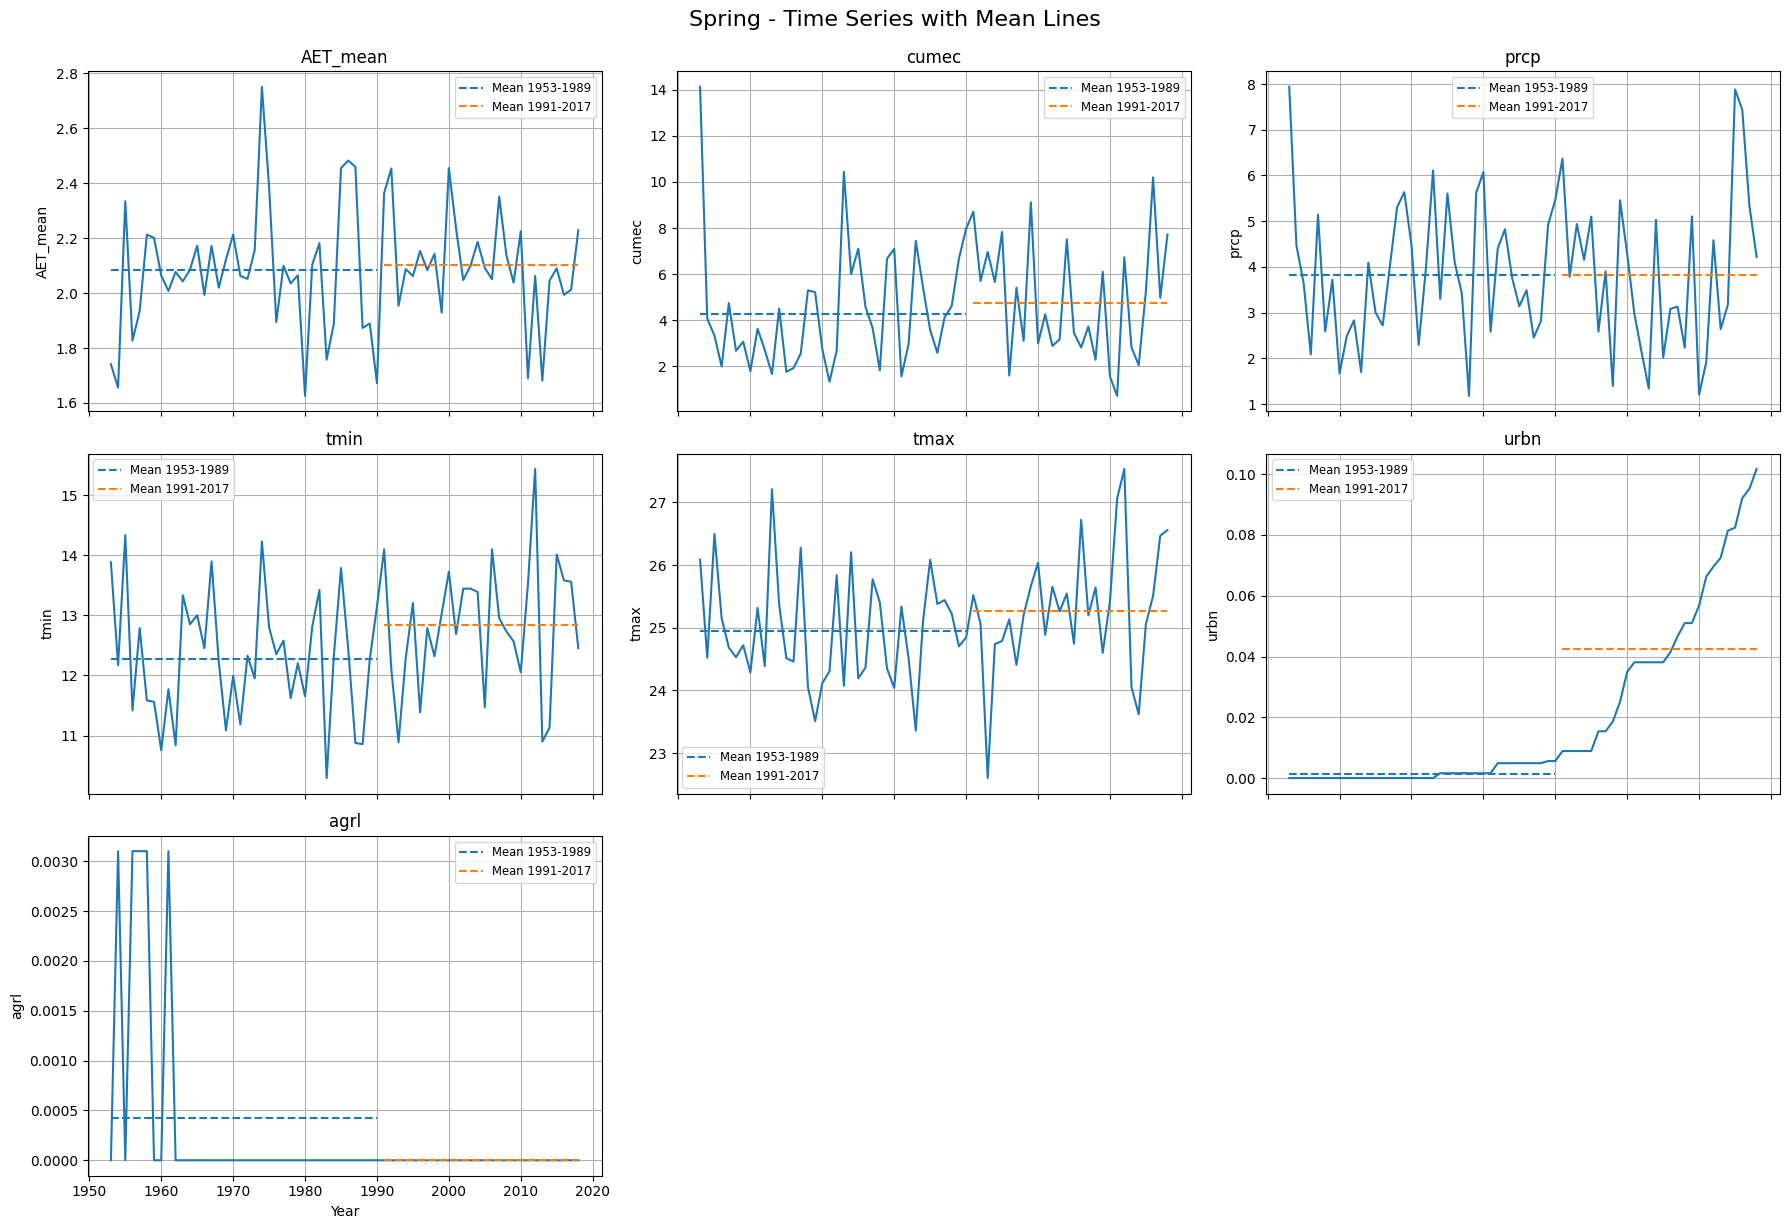

Processing interval 1953-1990 for Spring...
Processing interval 1991-2018 for Spring...


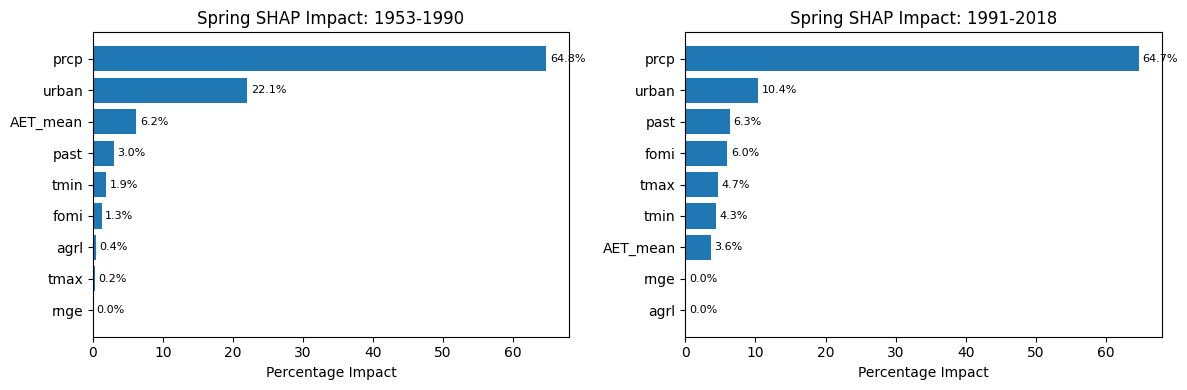


=== Processing Season: Autumn ===


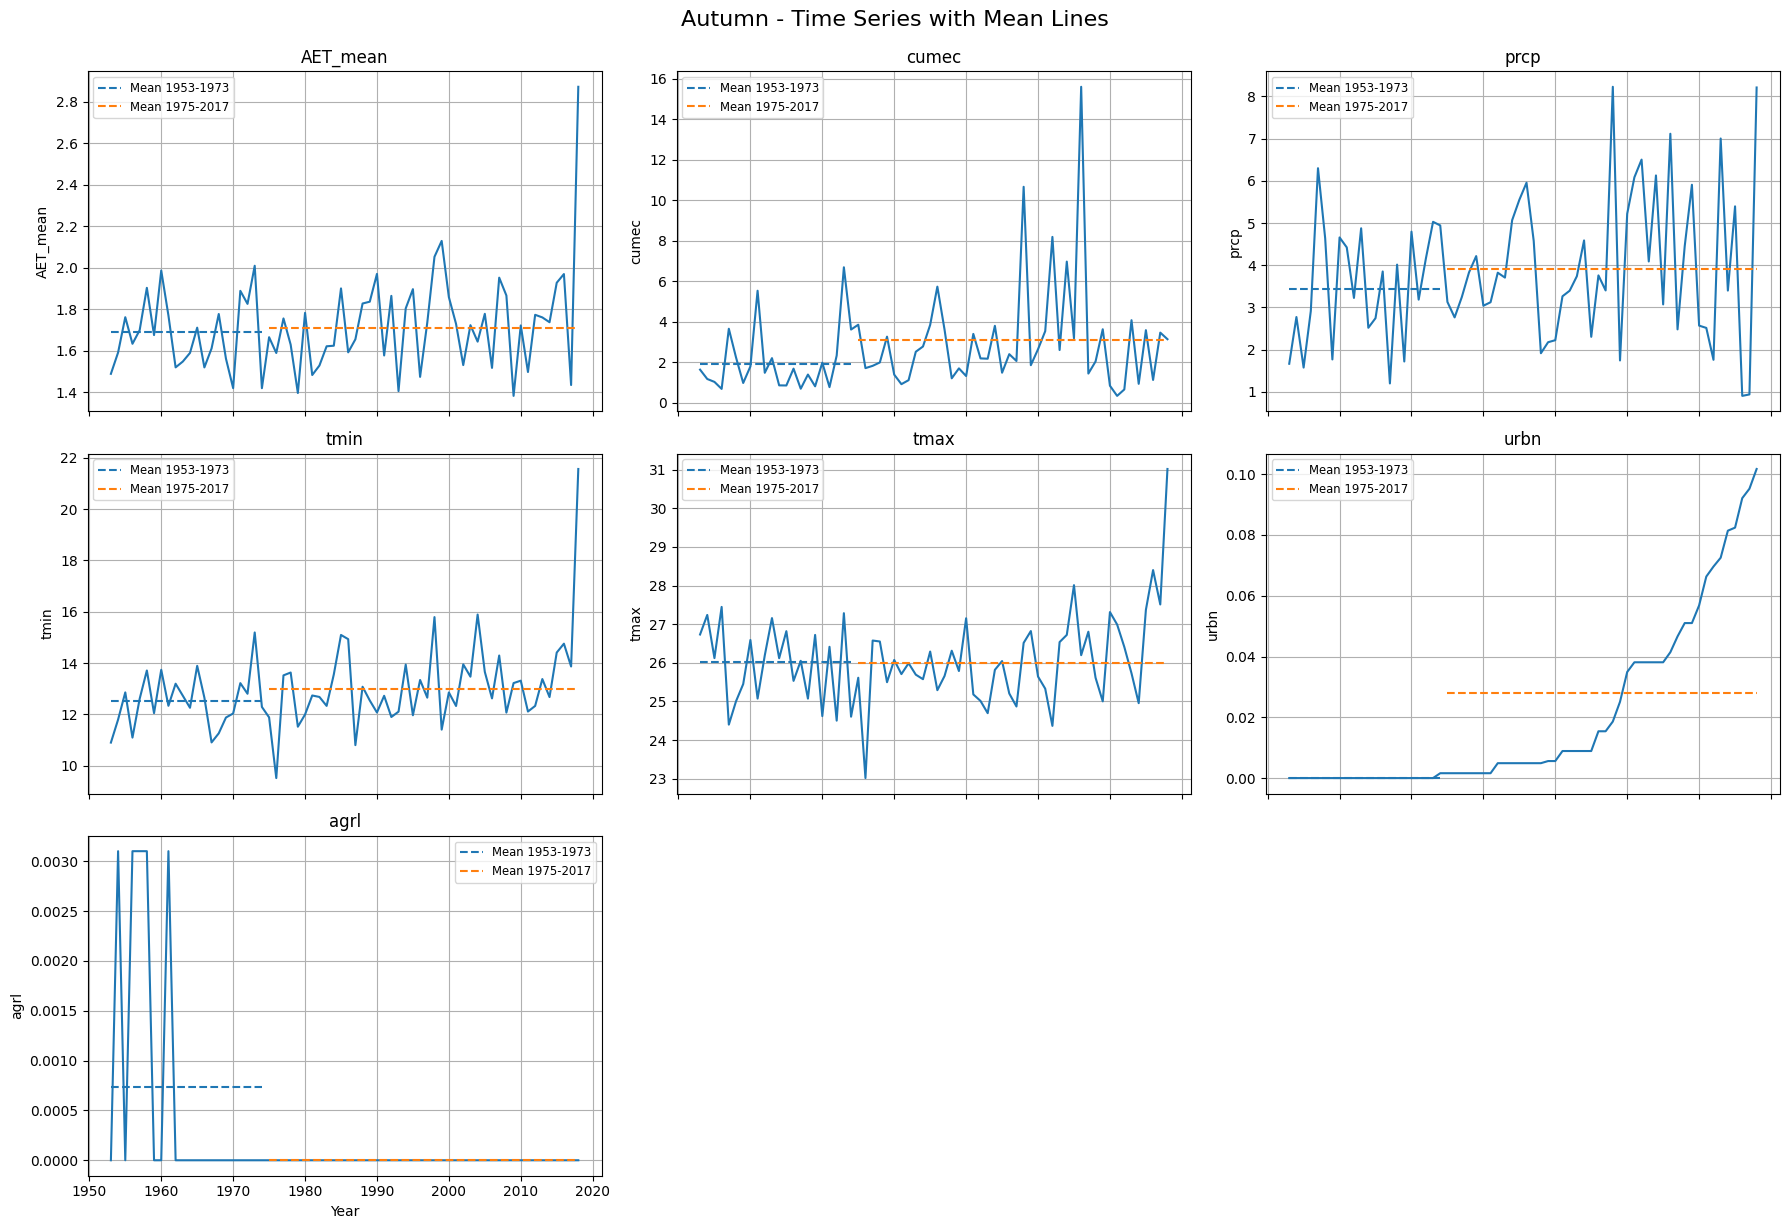

Processing interval 1953-1974 for Autumn...
Processing interval 1975-2018 for Autumn...


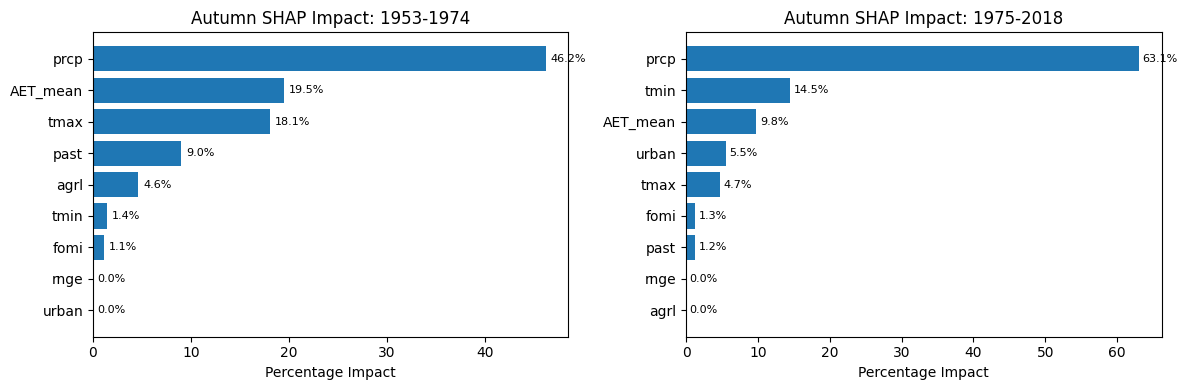

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import shap
import xgboost as xgb

# ======= 1. Plot Season Features (with Interval Means) ======= #
def plot_season_features(df_season, season_name, intervals):
    features = ['AET_mean', 'cumec', 'prcp', 'tmin', 'tmax', 'urbn', 'agrl']
    n_features = len(features)
    n_cols = 3
    n_rows = math.ceil(n_features / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows), sharex=True)
    axes = axes.flatten()

    for i, feature in enumerate(features):
        ax = axes[i]
        sns.lineplot(x=df_season['year'], y=df_season[feature], ax=ax)

        for idx, (start, end) in enumerate(intervals):
            mask = (df_season['year'] >= start) & (df_season['year'] < end)
            mean_val = df_season.loc[mask, feature].mean()

            ax.hlines(mean_val, xmin=start, xmax=end, colors=f'C{idx}', linestyles='dashed',
                      label=f'Mean {start}-{end-1}')

        ax.set_title(feature)
        ax.set_ylabel(feature)
        ax.grid(True)
        ax.legend(fontsize='small')

    # Remove extra subplots if any
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.xlabel("Year")
    plt.tight_layout()
    plt.suptitle(f"{season_name} - Time Series with Mean Lines", fontsize=16, y=1.02)
    plt.show()

# ======= 2. Get Percentage Impact from SHAP Values ======= #

def get_percentage_impact(shap_vals, columns, group_map):
    df_shap = pd.DataFrame(shap_vals, columns=columns)
    grouped_shap = {}

    for group_name, feature_list in group_map.items():
        grouped_shap[group_name] = df_shap[feature_list].sum(axis=1)

    for col in columns:
        if not any(col in v for v in group_map.values()):
            grouped_shap[col] = df_shap[col].abs()

    grouped_df = pd.DataFrame(grouped_shap)
    #print(grouped_df)
    mean_abs = grouped_df.abs().mean()
    pct = 100 * mean_abs / mean_abs.sum()
    return pct.sort_values()

# ======= 3. Train Model, Compute SHAP, Plot ======= #
def train_and_plot_shap(df_season, season_name, intervals, features, target, group_map, best_params):
    interval_importances = {}

    for start, end in intervals:
        print(f"Processing interval {start}-{end} for {season_name}...")

        df_interval = df_season[(df_season['year'] >= start) & (df_season['year'] < end)]
        X = df_interval[features].copy()
        y = df_interval[target]

        if X.empty:
            print(f"Skipped {start}-{end} due to no data.")
            continue

        bool_cols = X.select_dtypes(include='bool').columns
        X[bool_cols] = X[bool_cols].astype(int)

        model = xgb.XGBRegressor(**best_params, random_state=42)
        model.fit(X, y)

        explainer = shap.Explainer(model, X)
        shap_values = explainer.shap_values(X)

        #print(f"Generating SHAP summary plot for {season_name} interval {start}-{end}...")


        shap_vals = shap_values.values if hasattr(shap_values, 'values') else shap_values
        impact = get_percentage_impact(shap_vals, features, group_map)
        interval_importances[f"{start}-{end}"] = impact

    # === Plotting impact across intervals ===
    n_intervals = len(interval_importances)
    if n_intervals == 0:
        return

    n_cols = 2
    n_rows = math.ceil(n_intervals / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows), sharex=False)
    axes = axes.flatten()

    for ax, (interval, imp) in zip(axes, interval_importances.items()):
        ax.barh(imp.index, imp.values)
        ax.set_title(f"{season_name} SHAP Impact: {interval}")
        ax.set_xlabel("Percentage Impact")
        for i, v in enumerate(imp.values):
            ax.text(v + 0.5, i, f"{v:.1f}%", va='center', fontsize=8)

    # Remove unused subplots
    for i in range(len(interval_importances), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

# ======= 4. Loop Over All Seasons ======= #
def process_season(df_season, season_name, intervals, features, target, group_map, best_params):
    print(f"\n=== Processing Season: {season_name} ===")
    #print(grouped_df)

    plot_season_features(df_season, season_name, intervals)
    train_and_plot_shap(df_season, season_name, intervals, features, target, group_map, best_params)

# ======= 5. Main Execution ======= #
# Define your features, target, group map, best_params as given
features = [col for col in df_monthly.columns if col not in ['year', 'cumec', 'Base flow (cumec)', 'month',
                                                             'season_Autumn', 'season_Spring', 'season_Summer', 'season_Winter']]
target = 'cumec'
group_map = {
    "urban": ["urban_precip", "urbn", "urban_tmin"]
}
best_params = {
    'colsample_bytree': 1,
    'learning_rate': 0.01,
    'max_depth': 3,
    'n_estimators': 300,
    'subsample': 0.8
}

# Assume these are already defined correctly:
# summer_df, winter_df, spring_df, autumn_df
# Interval_summer, Interval_winter, Interval_spring, Interval_autumn

season_dfs = [summer_df, winter_df, spring_df, autumn_df]
season_names = ["Summer", "Winter", "Spring", "Autumn"]
intervals_list = [interval_sws, interval_sws, interval_sws, interval_aut]

for df_season, season_name, intervals in zip(season_dfs, season_names, intervals_list):
    process_season(df_season, season_name, intervals, features, target, group_map, best_params)



=== Processing Season: Summer ===


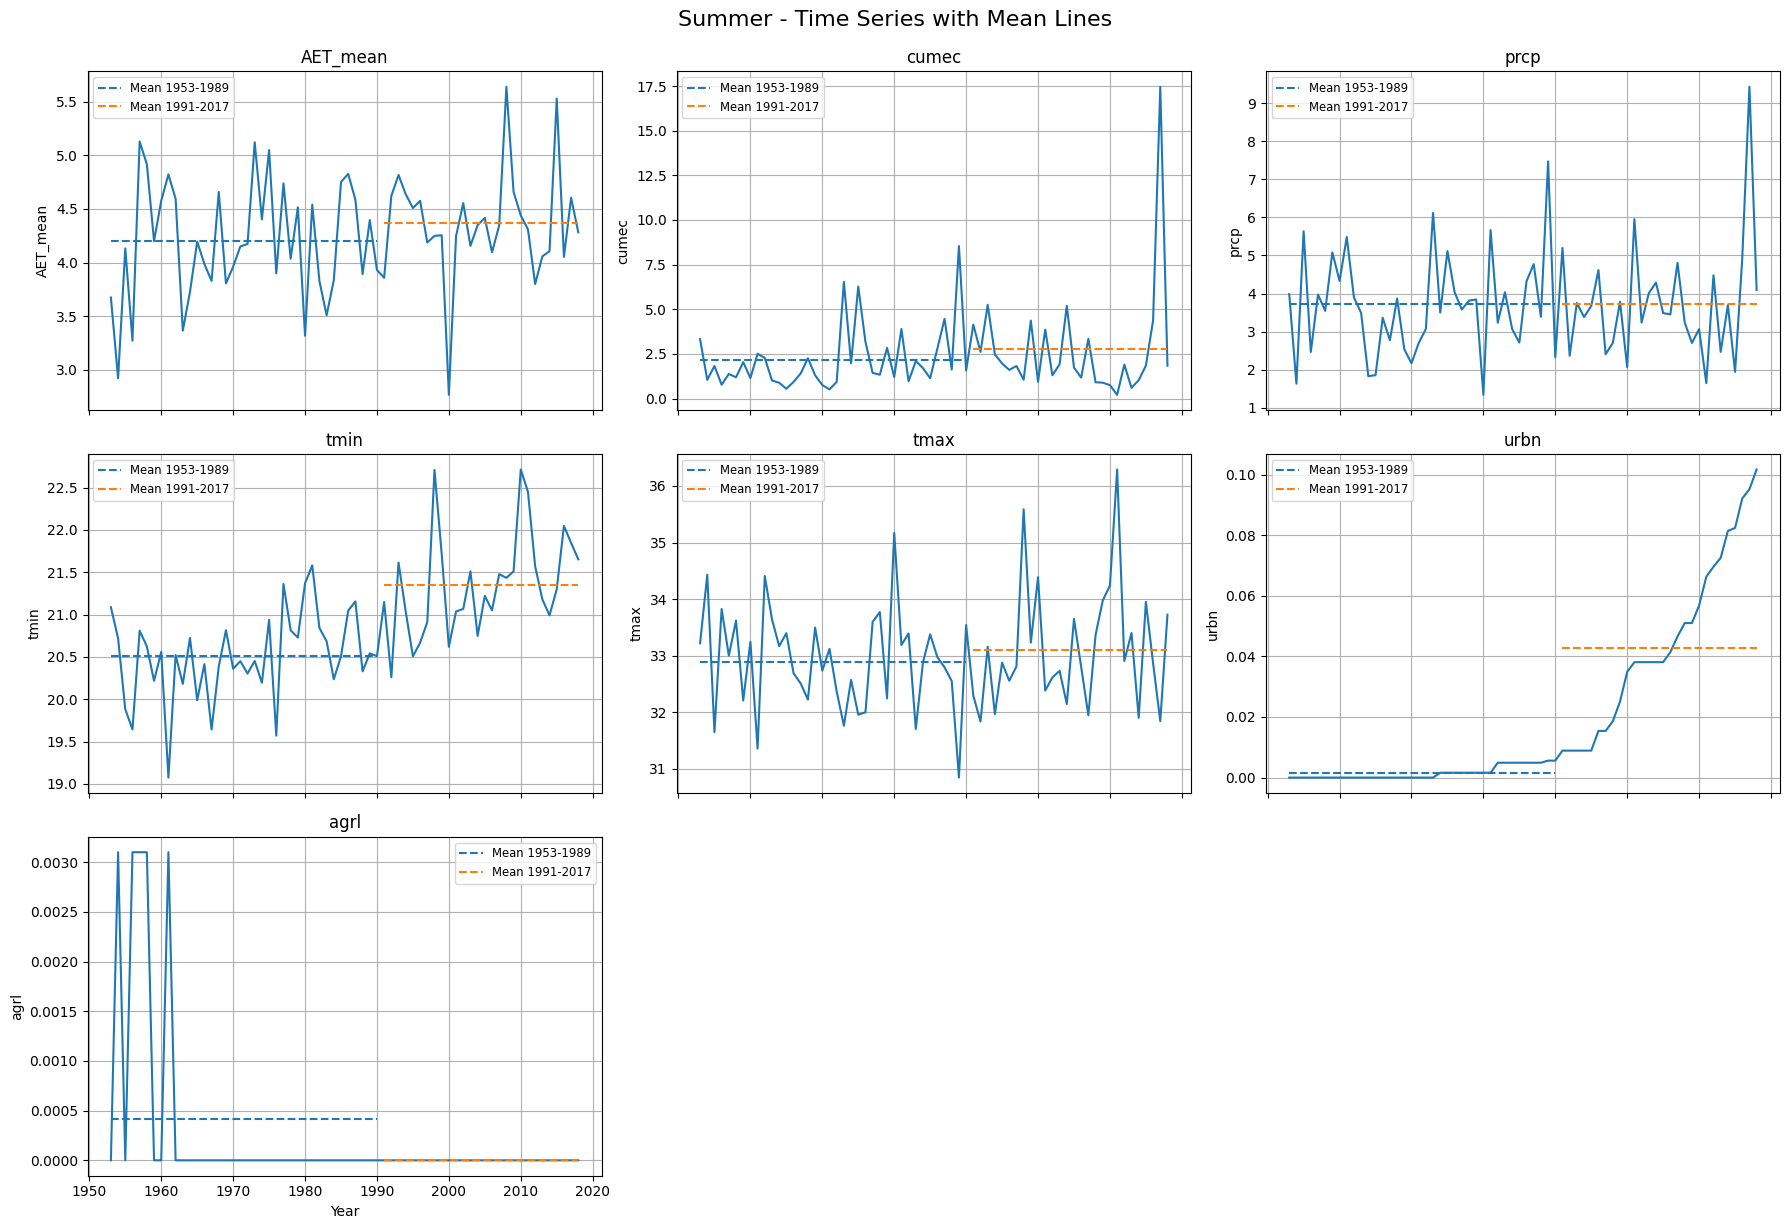

Processing interval 1953-1990 for Summer...
Processing interval 1991-2018 for Summer...


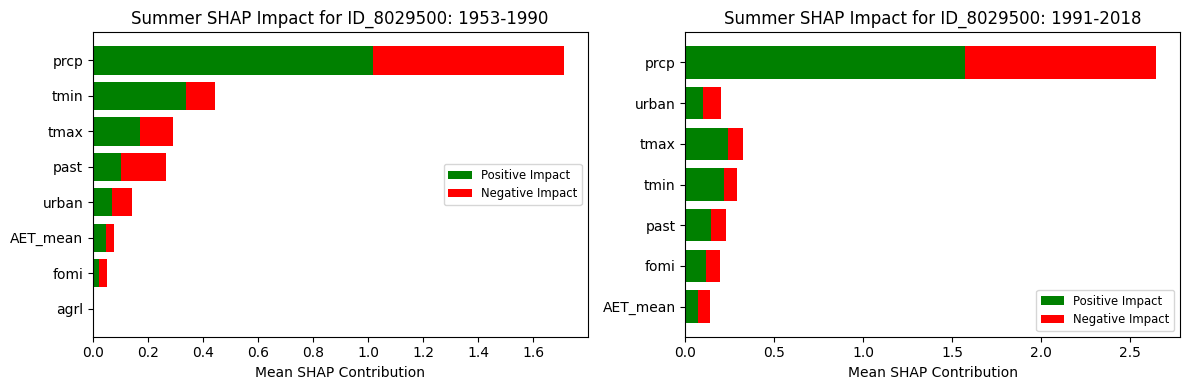


=== Processing Season: Winter ===


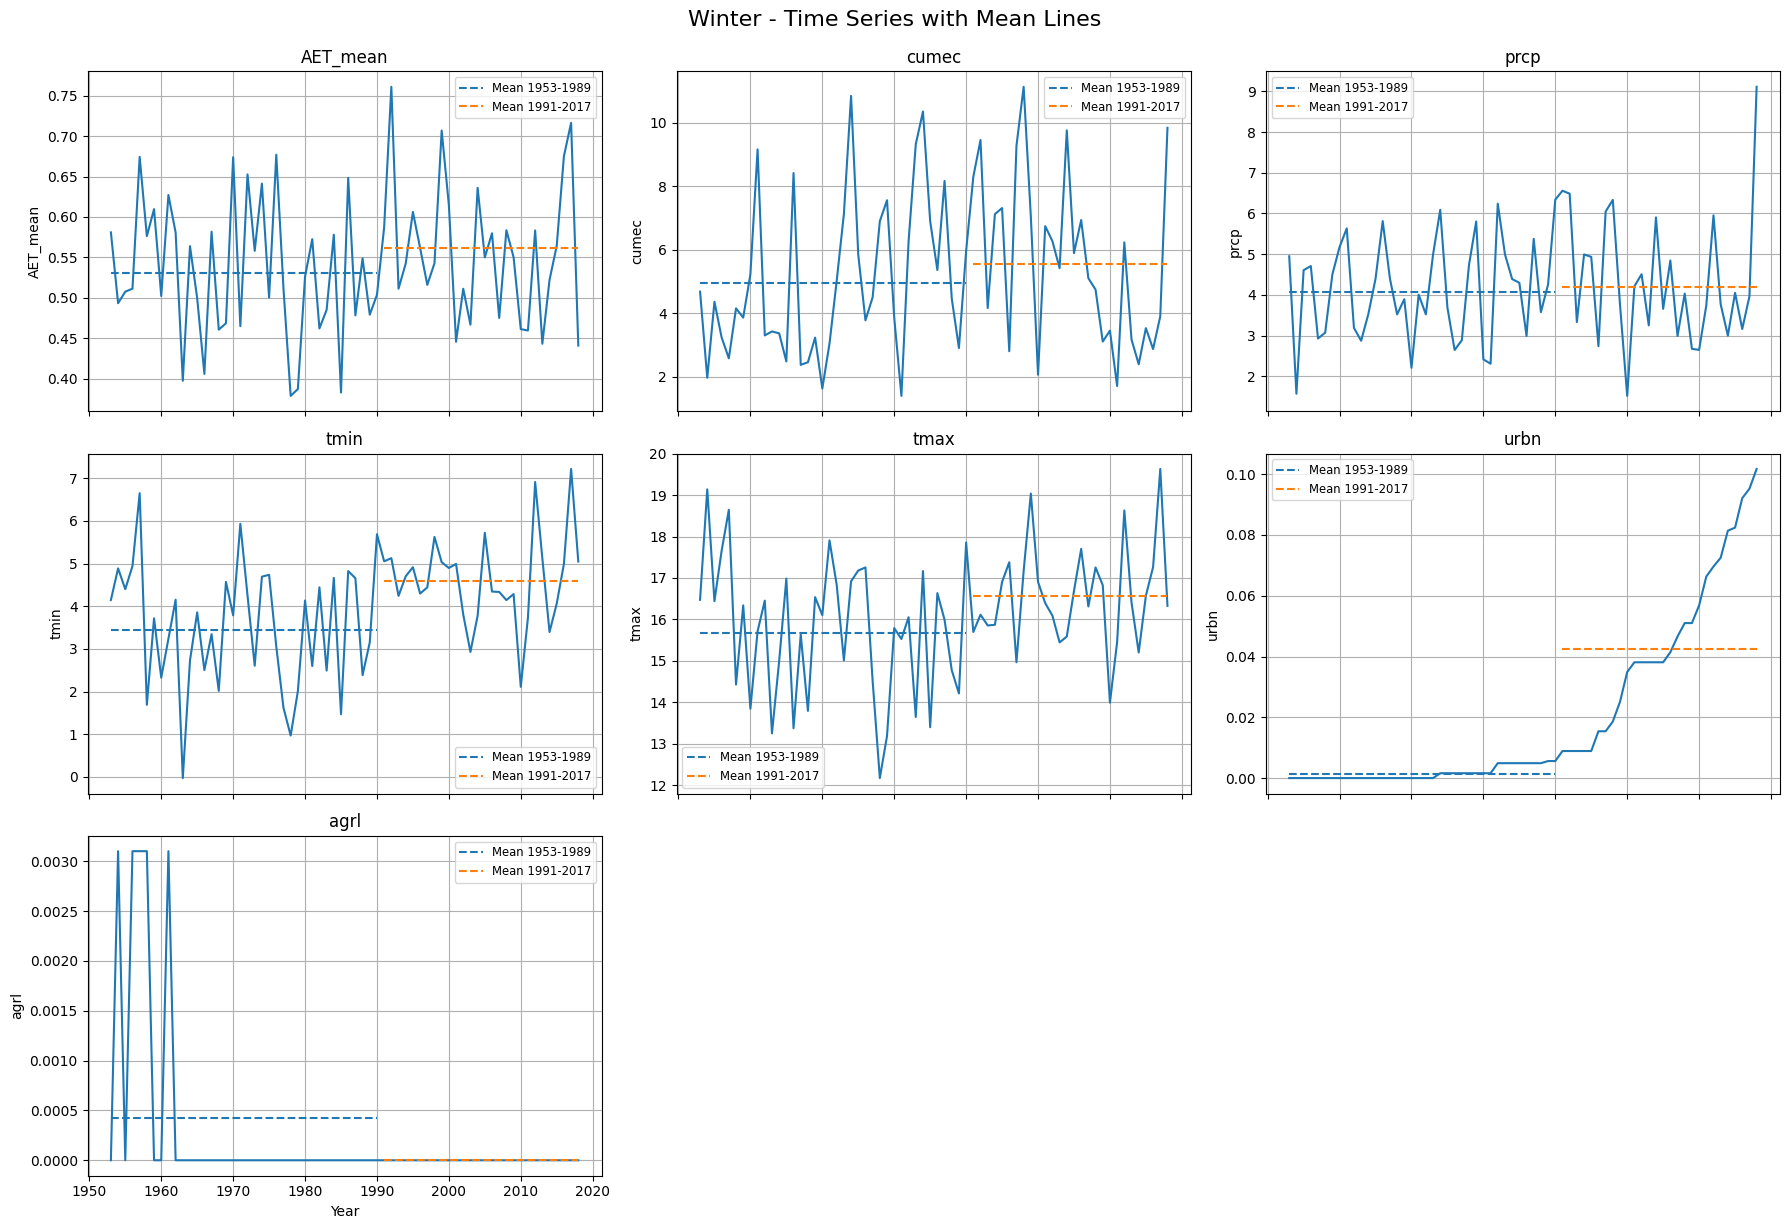

Processing interval 1953-1990 for Winter...
Processing interval 1991-2018 for Winter...


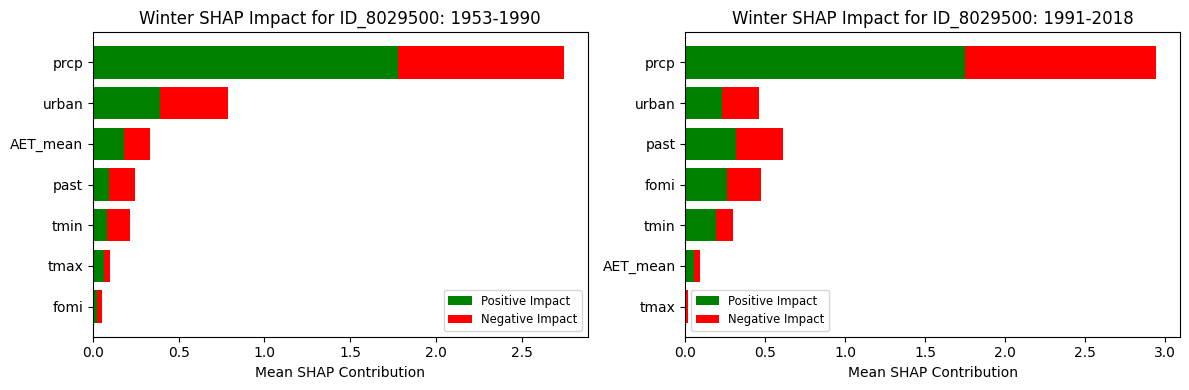


=== Processing Season: Spring ===


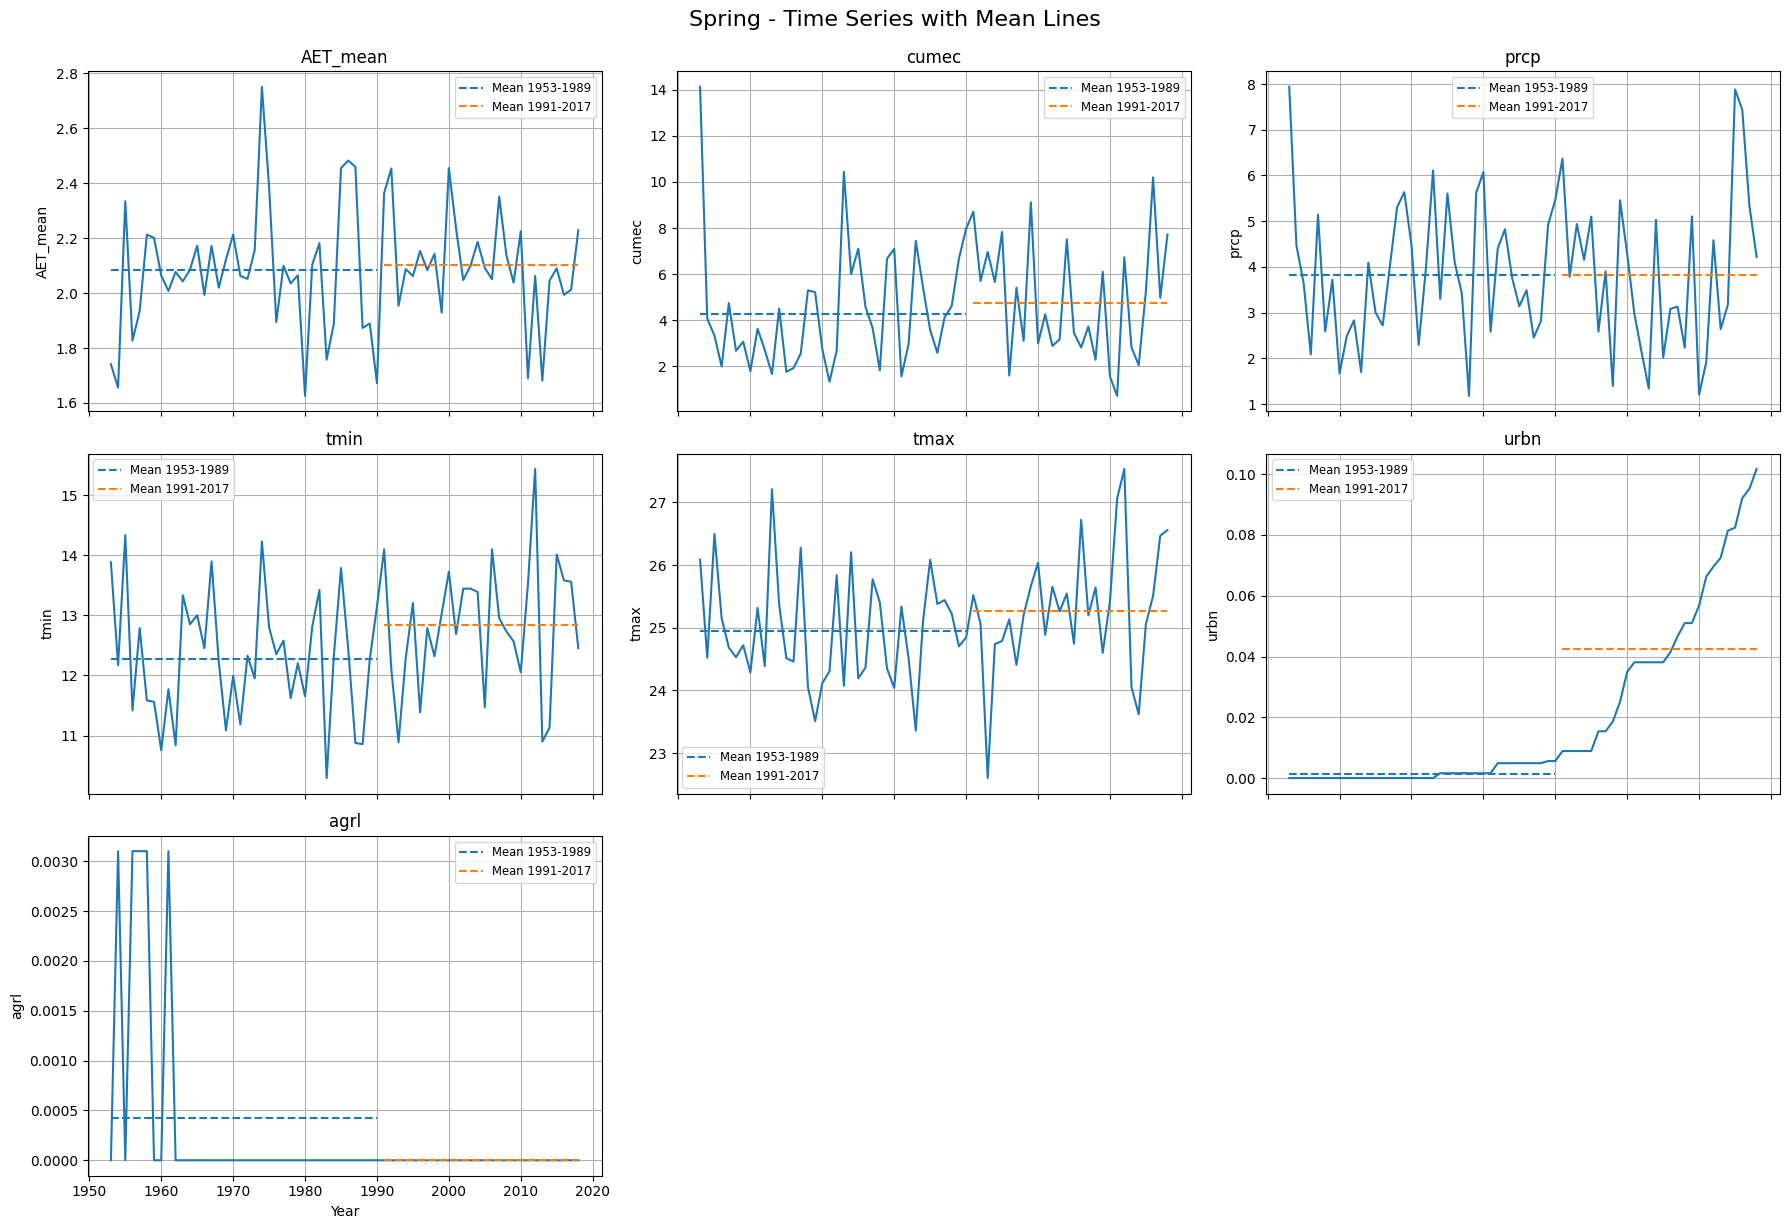

Processing interval 1953-1990 for Spring...
Processing interval 1991-2018 for Spring...


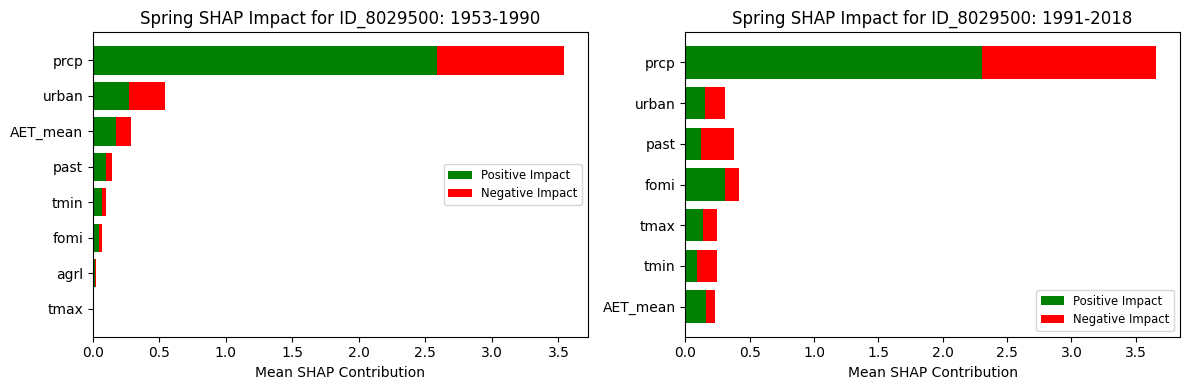


=== Processing Season: Autumn ===


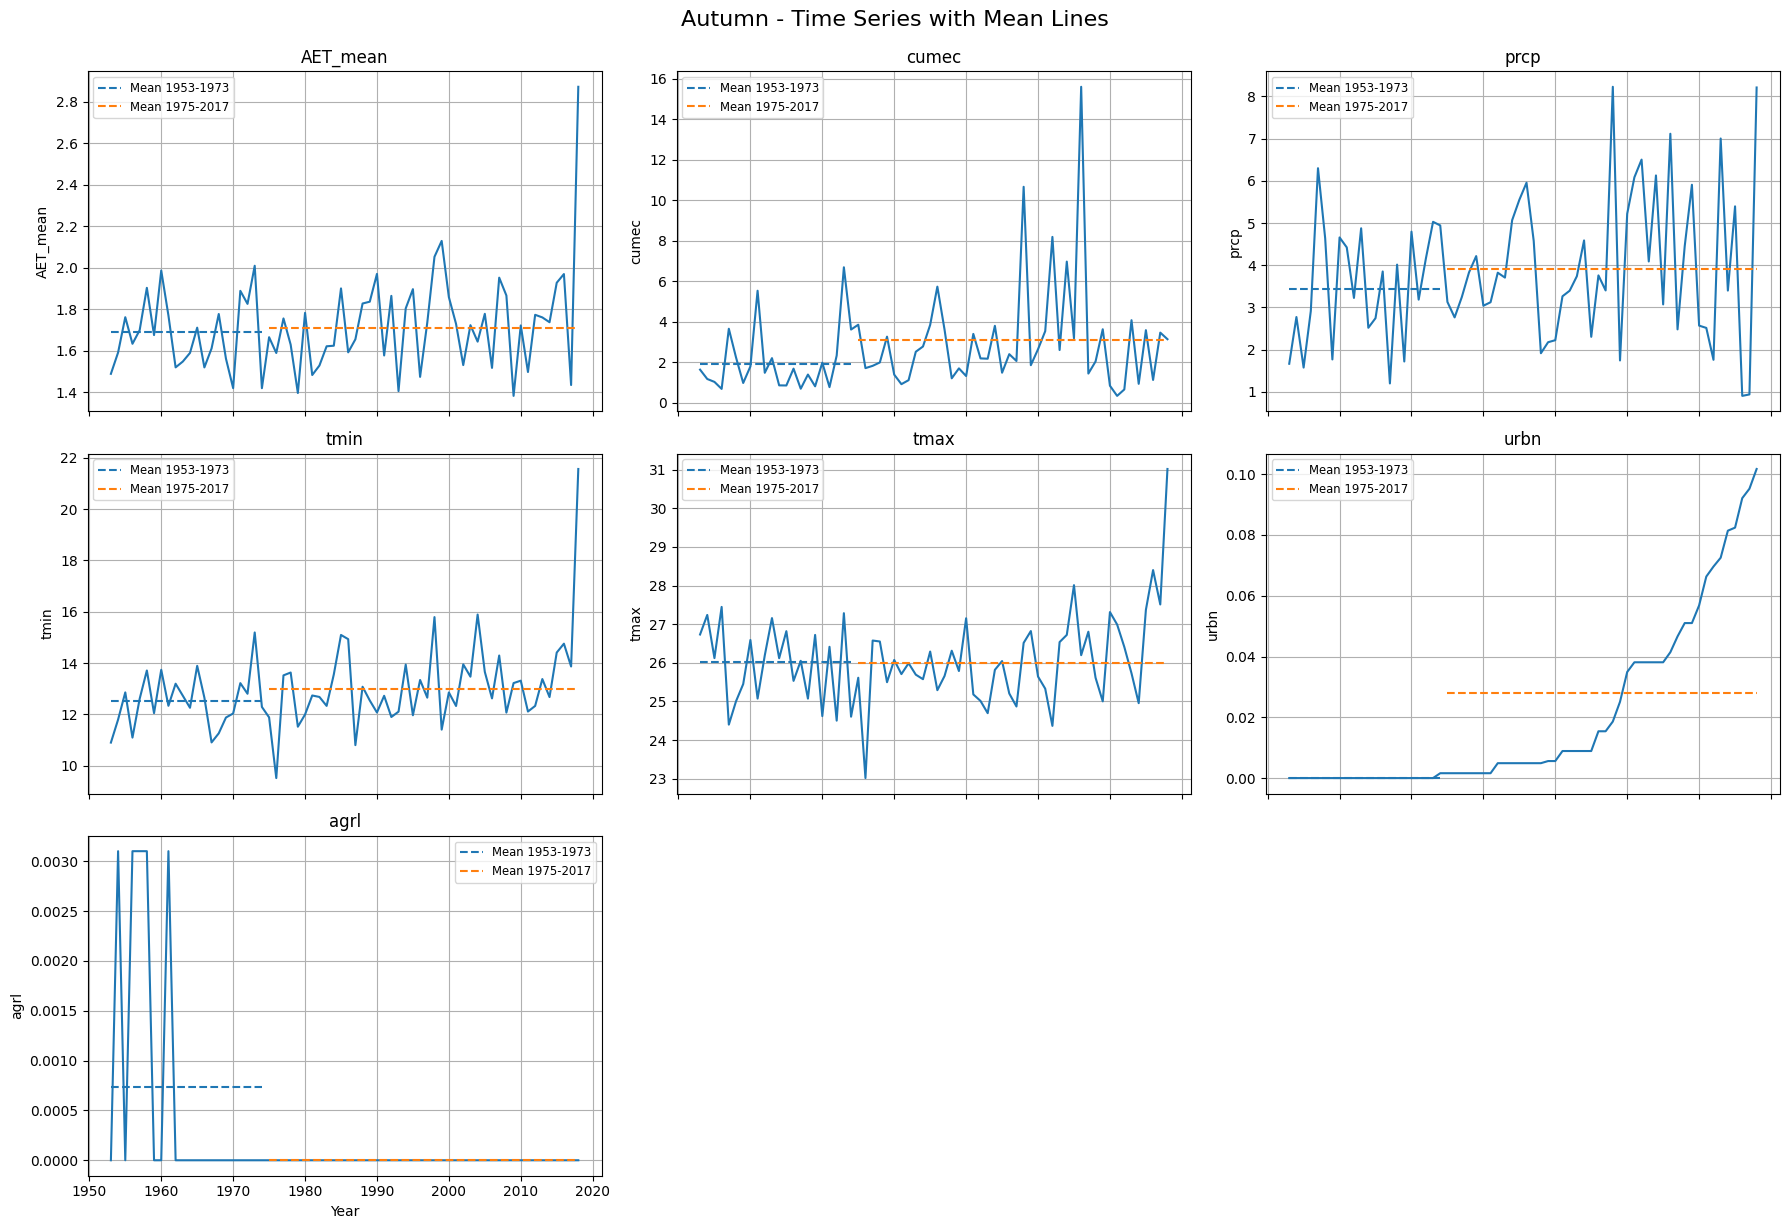

Processing interval 1953-1974 for Autumn...
Processing interval 1975-2018 for Autumn...


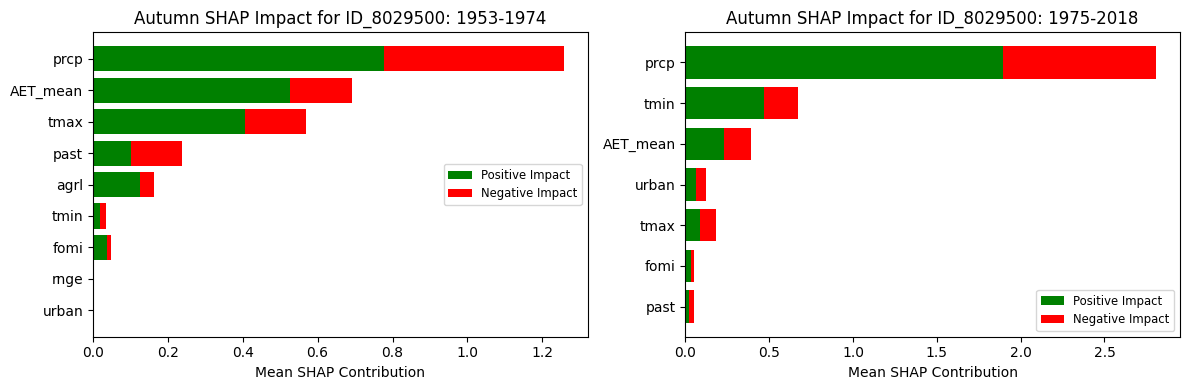

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import shap
import xgboost as xgb

# ======= Helper: Get Positive & Negative SHAP Impact ======= #
def get_pos_neg_impact(shap_vals, columns, group_map):
    df_shap = pd.DataFrame(shap_vals, columns=columns)
    grouped_pos = {}
    grouped_neg = {}

    for group_name, feature_list in group_map.items():
        shap_group = df_shap[feature_list]
        grouped_pos[group_name] = shap_group[shap_group > 0].sum(axis=1)
        grouped_neg[group_name] = shap_group[shap_group < 0].sum(axis=1)

    # Handle ungrouped features
    for col in columns:
        if not any(col in v for v in group_map.values()):
            grouped_pos[col] = df_shap[col][df_shap[col] > 0]
            grouped_neg[col] = df_shap[col][df_shap[col] < 0]

    pos_mean = pd.DataFrame(grouped_pos).mean()
    neg_mean = pd.DataFrame(grouped_neg).mean().abs()  # take absolute for clean plotting

    return pos_mean, neg_mean


# ======= 1. Plot Season Features (with Interval Means) ======= #
def plot_season_features(df_season, season_name, intervals):
    features = ['AET_mean', 'cumec', 'prcp', 'tmin', 'tmax', 'urbn', 'agrl']
    n_features = len(features)
    n_cols = 3
    n_rows = math.ceil(n_features / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows), sharex=True)
    axes = axes.flatten()

    for i, feature in enumerate(features):
        ax = axes[i]
        sns.lineplot(x=df_season['year'], y=df_season[feature], ax=ax)

        for idx, (start, end) in enumerate(intervals):
            mask = (df_season['year'] >= start) & (df_season['year'] < end)
            mean_val = df_season.loc[mask, feature].mean()

            ax.hlines(mean_val, xmin=start, xmax=end, colors=f'C{idx}', linestyles='dashed',
                      label=f'Mean {start}-{end-1}')

        ax.set_title(feature)
        ax.set_ylabel(feature)
        ax.grid(True)
        ax.legend(fontsize='small')

    # Remove extra subplots if any
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.xlabel("Year")
    plt.tight_layout()
    plt.suptitle(f"{season_name} - Time Series with Mean Lines", fontsize=16, y=1.02)
    plt.show()

# ======= 2. Get Percentage Impact from SHAP Values ======= #

def get_percentage_impact(shap_vals, columns, group_map):
    df_shap = pd.DataFrame(shap_vals, columns=columns)
    grouped_shap = {}

    for group_name, feature_list in group_map.items():
        grouped_shap[group_name] = df_shap[feature_list].sum(axis=1)

    for col in columns:
        if not any(col in v for v in group_map.values()):
            grouped_shap[col] = df_shap[col].abs()

    grouped_df = pd.DataFrame(grouped_shap)
    #print(grouped_df)
    mean_abs = grouped_df.abs().mean()
    pct = 100 * mean_abs / mean_abs.sum()
    return pct.sort_values()

# ======= 3. Train Model, Compute SHAP, Plot ======= #
def train_and_plot_shap(df_season, season_name, intervals, features, target, group_map, best_params):
    interval_importances = {}

    for start, end in intervals:
        print(f"Processing interval {start}-{end} for {season_name}...")

        df_interval = df_season[(df_season['year'] >= start) & (df_season['year'] < end)]
        X = df_interval[features].copy()
        y = df_interval[target]

        if X.empty:
            print(f"Skipped {start}-{end} due to no data.")
            continue

        bool_cols = X.select_dtypes(include='bool').columns
        X[bool_cols] = X[bool_cols].astype(int)

        model = xgb.XGBRegressor(**best_params, random_state=42)
        model.fit(X, y)

        explainer = shap.Explainer(model, X)
        shap_values = explainer.shap_values(X)

        #print(f"Generating SHAP summary plot for {season_name} interval {start}-{end}...")


        shap_vals = shap_values.values if hasattr(shap_values, 'values') else shap_values
        impact = get_percentage_impact(shap_vals, features, group_map)
        pos_mean, neg_mean = get_pos_neg_impact(shap_vals, features, group_map)

        interval_importances[f"{start}-{end}"] = {
            'impact': impact,
            'pos': pos_mean,
            'neg': neg_mean
        }


    # === Plotting impact across intervals ===
    n_intervals = len(interval_importances)
    if n_intervals == 0:
        return

    n_cols = 2
    n_rows = math.ceil(n_intervals / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows), sharex=False)
    axes = axes.flatten()

    for ax, (interval, vals) in zip(axes, interval_importances.items()):
      impact = vals['impact']
      pos = vals['pos'].reindex(impact.index, fill_value=0)
      neg = vals['neg'].reindex(impact.index, fill_value=0)

      ax.barh(impact.index, pos, color='green', label='Positive Impact')
      ax.barh(impact.index, neg, color='red', label='Negative Impact', left=pos)

      ax.set_title(f"{season_name} SHAP Impact for {site_id}: {interval}")
      ax.set_xlabel("Mean SHAP Contribution")
      ax.legend(fontsize='small')


    # Remove unused subplots
    for i in range(len(interval_importances), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()



# ======= 4. Loop Over All Seasons ======= #
def process_season(df_season, season_name, intervals, features, target, group_map, best_params):
    print(f"\n=== Processing Season: {season_name} ===")
    #print(grouped_df)

    plot_season_features(df_season, season_name, intervals)
    train_and_plot_shap(df_season, season_name, intervals, features, target, group_map, best_params)

# ======= 5. Main Execution ======= #
# Define your features, target, group map, best_params as given
features = [col for col in df_monthly.columns if col not in ['year', 'cumec', 'Base flow (cumec)', 'month',
                                                             'season_Autumn', 'season_Spring', 'season_Summer', 'season_Winter']]
target = 'cumec'
group_map = {
    "urban": ["urban_precip", "urbn", "urban_tmin"]
}
best_params = {
    'colsample_bytree': 1,
    'learning_rate': 0.01,
    'max_depth': 3,
    'n_estimators': 300,
    'subsample': 0.8
}

# Assume these are already defined correctly:
# summer_df, winter_df, spring_df, autumn_df
# Interval_summer, Interval_winter, Interval_spring, Interval_autumn

season_dfs = [summer_df, winter_df, spring_df, autumn_df]
season_names = ["Summer", "Winter", "Spring", "Autumn"]
intervals_list = [interval_sws, interval_sws, interval_sws, interval_aut]

for df_season, season_name, intervals in zip(season_dfs, season_names, intervals_list):
    process_season(df_season, season_name, intervals, features, target, group_map, best_params)


## Prediction

In [97]:
df = pd.read_csv('df_monthly.csv')
df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month'].astype(str) + '-01')

# Define target and features
target = 'cumec'
features = ['AET_mean', 'prcp', 'tmin', 'tmax', 'urbn', 'agrl', 'past', 'fomi', 'rnge',
            'season_Autumn', 'season_Spring', 'season_Summer', 'season_Winter']

X = df[features]
y = df[target]

# Train-test split (time series aware!)
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)


In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Define base model
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)


In [189]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

df = pd.read_csv('df_monthly.csv')

# Drop identifiers(like year, month)
X = df.drop(columns=['cumec', 'year', 'month'])
y = df['cumec']

# Ensure sorted by time
df_sorted = df.sort_values(by=['year', 'month']).reset_index(drop=True)
X = X.loc[df_sorted.index]
y = y.loc[df_sorted.index]

In [190]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
split_idx = int(0.70 * len(df_monthly))
X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# XGBoost regressor
xgbr = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 200,300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 1],
    'colsample_bytree': [0.7, 1],
}

# TimeSeries cross-validation
tscv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(
    estimator=xgbr,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    verbose=2,
    n_jobs=-1
)

# Fit grid search
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_
print("Best hyperparameters:", grid_search.best_params_)

# Predict on test set
y_test_pred = best_model.predict(X_test)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best hyperparameters: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1}


In [185]:
train_years = df['year'].iloc[:split_idx]
print("Training data spans from", train_years.iloc[0], "to", train_years.iloc[-1])

test_years = df['year'].iloc[split_idx:]
print("Test data spans from", test_years.iloc[0], "to", test_years.iloc[-1])


Training data spans from 1953 to 1998
Test data spans from 1999 to 2018


Test RMSE: 1.853
Test R²: 0.860


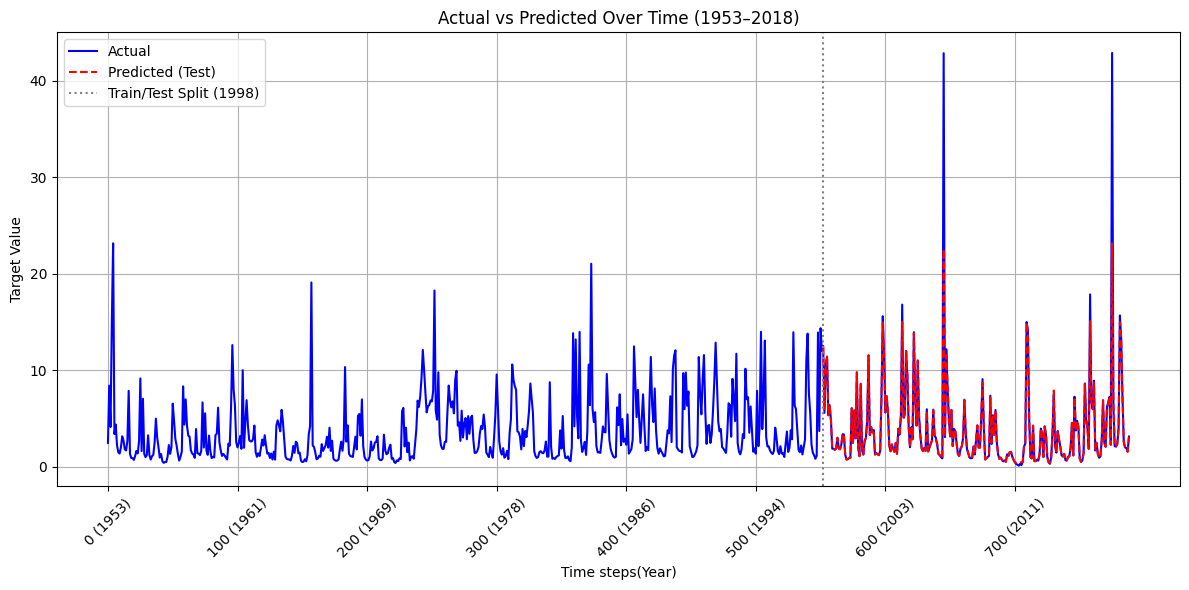

In [196]:
# Evaluate
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_test = r2_score(y_test, y_test_pred)

print(f"Test RMSE: {rmse_test:.3f}")
print(f"Test R²: {r2_test:.3f}")

results_df = pd.DataFrame({
    'Year': df.index,
    'Actual': y,
    'Predicted': [np.nan]*len(y)  # Fill predictions only for test years
})

# Insert test predictions
results_df.loc[split_idx:, 'Predicted'] = y_test_pred

# Plot
plt.figure(figsize=(12, 6))
plt.plot(results_df['Year'], results_df['Actual'], label='Actual', color='blue')
plt.plot(results_df['Year'], results_df['Predicted'], label='Predicted (Test)', color='red', linestyle='--')
plt.axvline(x=results_df['Year'].iloc[split_idx], color='gray', linestyle=':', label='Train/Test Split (1998)')
tick_positions = list(range(0, len(results_df), 100))  # Every 100 time steps
tick_labels = [f"{i} ({1953 + i // 12})" for i in tick_positions]

plt.xticks(tick_positions, tick_labels, rotation=45)

plt.title('Actual vs Predicted Over Time (1953–2018)')
plt.xlabel('Time steps(Year)')
plt.ylabel('Target Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [174]:
# # Dummy predictor: predict mean of training set
# dummy_pred = np.full_like(y_test, y_train.mean())
# dummy_r2 = r2_score(y_test, dummy_pred)
# print(f"Baseline R² (mean predictor): {dummy_r2:.3f}")
